In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from typing import List, Tuple

print("=" * 80)
print("SNIPPET S1: RAW NIFTI INDEX BUILDER")
print("=" * 80)

# ============================================================================
# STEP 1: Define and Check Dataset Roots
# ============================================================================

OASIS2_P1_ROOT = Path("/kaggle/input/oaisis-dataset-3-p1/OAS2_RAW_PART1")
OASIS2_P2_ROOT = Path("/kaggle/input/oaisis-3-p2/OAS2_RAW_PART2")
OASIS3_ROOT    = Path("/kaggle/input/oaisis-3/oaisis3")

def check_root(path: Path, name: str) -> None:
    """
    Verify that a dataset root path exists.
    Raise FileNotFoundError with helpful message if missing.
    """
    print(f"\nChecking dataset root for {name}:")
    print(f"  Path: {path}")
    
    if not path.exists():
        error_msg = (
            f"\n{'='*80}\n"
            f"ERROR: Dataset root not found for {name}\n"
            f"Path: {path}\n"
            f"{'='*80}\n"
            f"FIX: In Kaggle notebook, click 'Add Data' → Search for:\n"
            f"  - 'oaisis-dataset-3-p1' (for OASIS2 Part 1)\n"
            f"  - 'oaisis-3-p2' (for OASIS2 Part 2)\n"
            f"  - 'oaisis-3' (for OASIS3)\n"
            f"Then re-run this cell.\n"
            f"{'='*80}\n"
        )
        raise FileNotFoundError(error_msg)
    else:
        print(f"  [✓] Found {name}")

# Check all roots
check_root(OASIS2_P1_ROOT, "OASIS2_P1")
check_root(OASIS2_P2_ROOT, "OASIS2_P2")
check_root(OASIS3_ROOT,    "OASIS3")

print("\n" + "=" * 80)
print("All dataset roots verified successfully!")
print("=" * 80)

# ============================================================================
# STEP 2: Build NIfTI Index Function
# ============================================================================

def build_nifti_index(root: Path, dataset_name: str, source_tag: str) -> pd.DataFrame:
    """
    Recursively scan a root directory for NIfTI/Analyze files.
    
    Parameters:
    -----------
    root : Path
        Root directory to scan
    dataset_name : str
        "OASIS2" or "OASIS3"
    source_tag : str
        "PART1", "PART2", or "FULL"
    
    Returns:
    --------
    pd.DataFrame with columns:
        - nifti_path: full path as string
        - dataset: dataset name
        - source: source tag
        - filename: file name only
        - parent_dir: parent directory path
        - ext: file extension
    """
    print(f"\n{'='*80}")
    print(f"Scanning {dataset_name} ({source_tag})")
    print(f"Root: {root}")
    print("=" * 80)
    
    all_paths = []
    
    if dataset_name == "OASIS3":
        # OASIS3 uses NIfTI format (.nii)
        print("Searching for *.nii files (NIfTI format)...")
        nii_files = list(root.rglob("*.nii"))
        all_paths = nii_files
        print(f"  Found {len(nii_files)} .nii files")
        
    else:  # OASIS2
        # OASIS2 uses Analyze format (.hdr + .img pairs)
        print("Searching for *.hdr files (Analyze format)...")
        hdr_files = list(root.rglob("*.hdr"))
        all_paths = hdr_files
        print(f"  Found {len(hdr_files)} .hdr files")
    
    # Sort paths for reproducibility
    all_paths = sorted(all_paths)
    
    if len(all_paths) == 0:
        print(f"\n  WARNING: No files found in {root}")
        print(f"  Check if dataset structure matches expected patterns:")
        print(f"    - OASIS2: OAS2_XXXX_MRY/RAW/mpr-1.nifti.hdr")
        print(f"    - OASIS3: OASXXXXX_MR_dXXXX/anat*/NIFTI/*/sub-*_T1w.nii")
    
    # Build DataFrame
    records = []
    for path in all_paths:
        records.append({
            'nifti_path': str(path),
            'dataset': dataset_name,
            'source': source_tag,
            'filename': path.name,
            'parent_dir': str(path.parent),
            'ext': path.suffix
        })
    
    df = pd.DataFrame(records)
    
    # Show sample
    if len(df) > 0:
        print(f"\nSample paths (first 3):")
        for idx, row in df.head(3).iterrows():
            print(f"  {idx+1}. {row['filename']}")
            print(f"     {row['parent_dir']}")
    
    return df

# ============================================================================
# STEP 3: Build Index for Each Dataset
# ============================================================================

print("\n" + "=" * 80)
print("BUILDING INDICES FOR ALL DATASETS")
print("=" * 80)

# OASIS2 Part 1
df_o2_p1 = build_nifti_index(OASIS2_P1_ROOT, "OASIS2", "PART1")

# OASIS2 Part 2
df_o2_p2 = build_nifti_index(OASIS2_P2_ROOT, "OASIS2", "PART2")

# OASIS3
df_o3 = build_nifti_index(OASIS3_ROOT, "OASIS3", "FULL")

# ============================================================================
# STEP 4: Combine and Save
# ============================================================================

print("\n" + "=" * 80)
print("COMBINING INDICES")
print("=" * 80)

# Concatenate all DataFrames
combined_index = pd.concat([df_o2_p1, df_o2_p2, df_o3], ignore_index=True)

print(f"\nTotal candidate MRI volumes: {len(combined_index)}")

# Group by dataset and source
print("\nCounts by dataset + source:")
counts = combined_index.groupby(['dataset', 'source']).size().reset_index(name='count')
print(counts.to_string(index=False))

# Additional statistics
print("\n" + "-" * 80)
print("File Extension Distribution:")
print("-" * 80)
ext_counts = combined_index['ext'].value_counts()
for ext, count in ext_counts.items():
    print(f"  {ext:10s}: {count:5d} files")

# Save to CSV
output_file = "raw_nifti_index.csv"
combined_index.to_csv(output_file, index=False)
print(f"\n{'='*80}")
print(f"✓ Saved index to: {output_file}")
print(f"  Total rows: {len(combined_index)}")
print(f"  File size: {os.path.getsize(output_file) / 1024:.2f} KB")
print("=" * 80)

# ============================================================================
# STEP 5: Preview Combined Index
# ============================================================================

print("\n" + "=" * 80)
print("COMBINED INDEX PREVIEW (First 10 rows)")
print("=" * 80)

# Display with better formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 80)

print("\n" + combined_index.head(10).to_string())

# ============================================================================
# STEP 6: Sanity Checks
# ============================================================================

print("\n" + "=" * 80)
print("SANITY CHECKS")
print("=" * 80)

# Check for duplicate paths
duplicates = combined_index['nifti_path'].duplicated().sum()
print(f"\n1. Duplicate paths: {duplicates}")
if duplicates > 0:
    print("   WARNING: Found duplicate paths (should be zero)")
    print(combined_index[combined_index['nifti_path'].duplicated(keep=False)]['nifti_path'].head(5))

# Check for missing values
missing = combined_index.isnull().sum()
print(f"\n2. Missing values per column:")
for col, count in missing.items():
    if count > 0:
        print(f"   {col}: {count} missing")
if missing.sum() == 0:
    print("   [✓] No missing values")

# Verify all paths exist (sample check - first 5)
print(f"\n3. File existence check (sampling first 5 paths):")
for idx, path_str in enumerate(combined_index['nifti_path'].head(5), 1):
    path = Path(path_str)
    status = "✓" if path.exists() else "✗"
    print(f"   {status} Path {idx}: {path.name}")

print("\n" + "=" * 80)
print("SNIPPET S1 COMPLETE")
print("=" * 80)
print("\nNext Steps:")
print("  → S2: Parse subject_id, session_id from file paths")
print("  → S3: Load clinical data (CDR, MMSE scores)")
print("  → S4: Test loading sample volumes with nibabel")
print("\n" + "=" * 80)


SNIPPET S1: RAW NIFTI INDEX BUILDER

Checking dataset root for OASIS2_P1:
  Path: /kaggle/input/oaisis-dataset-3-p1/OAS2_RAW_PART1
  [✓] Found OASIS2_P1

Checking dataset root for OASIS2_P2:
  Path: /kaggle/input/oaisis-3-p2/OAS2_RAW_PART2
  [✓] Found OASIS2_P2

Checking dataset root for OASIS3:
  Path: /kaggle/input/oaisis-3/oaisis3
  [✓] Found OASIS3

All dataset roots verified successfully!

BUILDING INDICES FOR ALL DATASETS

Scanning OASIS2 (PART1)
Root: /kaggle/input/oaisis-dataset-3-p1/OAS2_RAW_PART1
Searching for *.hdr files (Analyze format)...
  Found 772 .hdr files

Sample paths (first 3):
  1. mpr-1.nifti.hdr
     /kaggle/input/oaisis-dataset-3-p1/OAS2_RAW_PART1/OAS2_0001_MR1/RAW
  2. mpr-2.nifti.hdr
     /kaggle/input/oaisis-dataset-3-p1/OAS2_RAW_PART1/OAS2_0001_MR1/RAW
  3. mpr-3.nifti.hdr
     /kaggle/input/oaisis-dataset-3-p1/OAS2_RAW_PART1/OAS2_0001_MR1/RAW

Scanning OASIS2 (PART2)
Root: /kaggle/input/oaisis-3-p2/OAS2_RAW_PART2
Searching for *.hdr files (Analyze format).

In [2]:
"""
SNIPPET S2: Parse Subject, Visit, Run IDs from Paths
Goal to Extract structured metadata (subject_id, visit_code, run_id, modality)
      from raw file paths and create unique scan_uid for each volume.
"""

import pandas as pd
from pathlib import Path
import numpy as np

print("=" * 80)
print("SNIPPET S2: PARSE SUBJECT/VISIT/RUN IDs FROM PATHS")
print("=" * 80)

# ============================================================================
# STEP 1: Load Raw Index
# ============================================================================

print("\n" + "=" * 80)
print("LOADING RAW NIFTI INDEX")
print("=" * 80)

input_file = "raw_nifti_index.csv"
df = pd.read_csv(input_file)

print(f"\nLoaded: {input_file}")
print(f"  Rows: {len(df)}")
print(f"  Columns: {df.columns.tolist()}")

# Verify expected columns exist
expected_cols = ['nifti_path', 'dataset', 'source', 'filename', 'parent_dir', 'ext']
missing_cols = [col for col in expected_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing expected columns: {missing_cols}")

print("\nDataset distribution:")
print(df.groupby(['dataset', 'source']).size())

# ============================================================================
# STEP 2: Initialize New Columns
# ============================================================================

print("\n" + "=" * 80)
print("INITIALIZING NEW METADATA COLUMNS")
print("=" * 80)

# Create new columns with default values
df['subject_id'] = None
df['visit_code'] = None
df['run_id'] = None
df['modality'] = None
df['is_t1w'] = False

print("\nNew columns added:")
print("  - subject_id (str)")
print("  - visit_code (str)")
print("  - run_id (str)")
print("  - modality (str)")
print("  - is_t1w (bool)")

# ============================================================================
# STEP 3: Parse OASIS2 Rows
# ============================================================================

print("\n" + "=" * 80)
print("PARSING OASIS2 METADATA")
print("=" * 80)

mask_o2 = df['dataset'] == 'OASIS2'
n_o2 = mask_o2.sum()
print(f"\nProcessing {n_o2} OASIS2 rows...")

parse_errors_o2 = []

for idx in df[mask_o2].index:
    try:
        parent_dir = df.loc[idx, 'parent_dir']
        filename = df.loc[idx, 'filename']
        
        # Parse session directory
        # Example: /path/to/OAS2_0001_MR1/RAW/mpr-1.nifti.hdr
        # parent_dir ends with "RAW", parent of that is session dir
        raw_dir = Path(parent_dir)
        session_dir = raw_dir.parent.name  # "OAS2_0001_MR1"
        
        # Split session directory name
        tokens = session_dir.split('_')
        
        if len(tokens) < 3:
            raise ValueError(f"Unexpected session_dir format: {session_dir}")
        
        # Extract subject_id and visit_code
        subject_id = f"{tokens[0]}_{tokens[1]}"  # "OAS2_0001"
        visit_code = tokens[2]                    # "MR1"
        
        # Parse run_id from filename
        # Example: "mpr-1.nifti.hdr" → run_id = "1"
        base_no_ext = filename.split('.')[0]  # "mpr-1"
        base_tokens = base_no_ext.split('-')
        
        if len(base_tokens) < 2:
            # Handle cases like "mpr.nifti.hdr" (no run number)
            run_id = "1"  # default
        else:
            run_id = base_tokens[1]  # "1", "2", etc.
        
        # Set modality (OASIS2 mpr-* are T1-weighted)
        modality = "T1w"
        is_t1w = True
        
        # Write to DataFrame
        df.loc[idx, 'subject_id'] = subject_id
        df.loc[idx, 'visit_code'] = visit_code
        df.loc[idx, 'run_id'] = run_id
        df.loc[idx, 'modality'] = modality
        df.loc[idx, 'is_t1w'] = is_t1w
        
    except Exception as e:
        parse_errors_o2.append({
            'index': idx,
            'filename': filename,
            'error': str(e)
        })

# Report OASIS2 parsing results
n_parsed_o2 = df[mask_o2]['subject_id'].notna().sum()
print(f"\n✓ Successfully parsed: {n_parsed_o2}/{n_o2} rows")

if parse_errors_o2:
    print(f"\n⚠ Parse errors: {len(parse_errors_o2)}")
    print("\nFirst 3 errors:")
    for i, err in enumerate(parse_errors_o2[:3], 1):
        print(f"  {i}. Index {err['index']}: {err['filename']}")
        print(f"     Error: {err['error']}")

# Show sample parsed OASIS2 data
print("\nSample OASIS2 parsed data (first 3 rows):")
o2_sample = df[mask_o2][['filename', 'subject_id', 'visit_code', 'run_id', 'modality', 'is_t1w']].head(3)
print(o2_sample.to_string(index=False))

# ============================================================================
# STEP 4: Parse OASIS3 Rows
# ============================================================================

print("\n" + "=" * 80)
print("PARSING OASIS3 METADATA")
print("=" * 80)

mask_o3 = df['dataset'] == 'OASIS3'
n_o3 = mask_o3.sum()
print(f"\nProcessing {n_o3} OASIS3 rows...")

parse_errors_o3 = []

for idx in df[mask_o3].index:
    try:
        filename = df.loc[idx, 'filename']
        
        # Normalize "sess-" → "ses-"
        fname_norm = filename.replace('sess-', 'ses-')
        
        # Remove extension
        # Example: "sub-OAS30001_ses-d0129_run-01_T1w.nii" → "sub-OAS30001_ses-d0129_run-01_T1w"
        base_no_ext = fname_norm.split('.')[0]
        
        # Split on underscore
        parts = base_no_ext.split('_')
        
        if len(parts) < 3:
            raise ValueError(f"Unexpected filename format: {filename} (parts: {parts})")
        
        # Extract subject_id
        subject_token = parts[0]  # "sub-OAS30001"
        if not subject_token.startswith('sub-'):
            raise ValueError(f"Expected 'sub-' prefix, got: {subject_token}")
        subject_id = subject_token.replace('sub-', '')  # "OAS30001"
        
        # Extract visit_code (session)
        session_token = None
        for part in parts:
            if part.startswith('ses-'):
                session_token = part
                break
        
        if session_token is None:
            raise ValueError(f"No 'ses-' token found in: {parts}")
        
        visit_code = session_token.replace('ses-', '')  # "d0129"
        
        # Extract run_id
        run_token = None
        for part in parts:
            if part.startswith('run-'):
                run_token = part
                break
        
        if run_token is None:
            # Some scans may not have run- prefix, default to "01"
            run_id = "01"
        else:
            run_id = run_token.replace('run-', '')  # "01", "02"
        
        # Extract modality (last token)
        modality = parts[-1]  # "T1w", "T2w", "FLAIR", etc.
        is_t1w = 'T1w' in modality
        
        # Write to DataFrame
        df.loc[idx, 'subject_id'] = subject_id
        df.loc[idx, 'visit_code'] = visit_code
        df.loc[idx, 'run_id'] = run_id
        df.loc[idx, 'modality'] = modality
        df.loc[idx, 'is_t1w'] = is_t1w
        
    except Exception as e:
        parse_errors_o3.append({
            'index': idx,
            'filename': filename,
            'error': str(e)
        })

# Report OASIS3 parsing results
n_parsed_o3 = df[mask_o3]['subject_id'].notna().sum()
print(f"\n✓ Successfully parsed: {n_parsed_o3}/{n_o3} rows")

if parse_errors_o3:
    print(f"\n⚠ Parse errors: {len(parse_errors_o3)}")
    print("\nFirst 3 errors:")
    for i, err in enumerate(parse_errors_o3[:3], 1):
        print(f"  {i}. Index {err['index']}: {err['filename']}")
        print(f"     Error: {err['error']}")

# Show sample parsed OASIS3 data
print("\nSample OASIS3 parsed data (first 3 rows):")
o3_sample = df[mask_o3][['filename', 'subject_id', 'visit_code', 'run_id', 'modality', 'is_t1w']].head(3)
print(o3_sample.to_string(index=False))

# ============================================================================
# STEP 5: Build scan_uid
# ============================================================================

print("\n" + "=" * 80)
print("CREATING UNIQUE SCAN_UIDs")
print("=" * 80)

# Create scan_uid: "{dataset}|{subject_id}|{visit_code}|{run_id}"
df['scan_uid'] = (
    df['dataset'].astype(str) + '|' + 
    df['subject_id'].astype(str) + '|' + 
    df['visit_code'].astype(str) + '|' + 
    df['run_id'].astype(str)
)

print(f"\n✓ Generated {len(df)} scan_uid values")

# Check for duplicate scan_uid (should be zero)
n_duplicates = df['scan_uid'].duplicated().sum()
print(f"\nDuplicate scan_uid count: {n_duplicates}")

if n_duplicates > 0:
    print("\n⚠ WARNING: Found duplicate scan_uid values!")
    print("This indicates multiple files for the same (subject, visit, run) combination.")
    print("\nSample duplicates:")
    dup_df = df[df['scan_uid'].duplicated(keep=False)].sort_values('scan_uid')
    print(dup_df[['scan_uid', 'filename', 'nifti_path']].head(10).to_string())

# Show sample scan_uid
print("\nSample scan_uid values:")
print(df['scan_uid'].head(5).tolist())

# ============================================================================
# STEP 6: Sanity Checks & Statistics
# ============================================================================

print("\n" + "=" * 80)
print("SANITY CHECKS & STATISTICS")
print("=" * 80)

# Check for missing values in parsed columns
print("\n1. Missing values in parsed columns:")
parsed_cols = ['subject_id', 'visit_code', 'run_id', 'modality', 'scan_uid']
for col in parsed_cols:
    n_missing = df[col].isna().sum()
    pct_missing = 100 * n_missing / len(df)
    print(f"   {col:15s}: {n_missing:4d} missing ({pct_missing:5.2f}%)")

# Unique subjects per dataset
print("\n2. Unique subjects per dataset:")
for dataset in df['dataset'].unique():
    mask = df['dataset'] == dataset
    n_subjects = df[mask]['subject_id'].nunique()
    print(f"   {dataset:10s}: {n_subjects:4d} subjects")

# Visit distribution per dataset
print("\n3. Visits per subject distribution:")
for dataset in df['dataset'].unique():
    mask = df['dataset'] == dataset
    visits_per_subject = df[mask].groupby('subject_id')['visit_code'].nunique()
    print(f"\n   {dataset}:")
    print(f"     Mean visits/subject: {visits_per_subject.mean():.2f}")
    print(f"     Median visits/subject: {visits_per_subject.median():.1f}")
    print(f"     Max visits/subject: {visits_per_subject.max()}")
    
    # Distribution
    visit_counts = visits_per_subject.value_counts().sort_index()
    for n_visits, count in visit_counts.head(5).items():
        print(f"       {count:3d} subjects with {n_visits} visit(s)")

# T1w distribution (OASIS3 only)
print("\n4. Modality distribution (OASIS3):")
o3_modality = df[mask_o3]['modality'].value_counts()
for mod, count in o3_modality.items():
    print(f"   {mod:10s}: {count:4d} scans")

n_t1w_o3 = df[mask_o3]['is_t1w'].sum()
print(f"\n   T1w scans (is_t1w=True): {n_t1w_o3}/{n_o3} ({100*n_t1w_o3/n_o3:.1f}%)")

# Run distribution
print("\n5. Run distribution:")
for dataset in df['dataset'].unique():
    mask = df['dataset'] == dataset
    run_counts = df[mask]['run_id'].value_counts().sort_index()
    print(f"\n   {dataset}:")
    for run, count in run_counts.head(5).items():
        print(f"     run-{run}: {count:4d} scans")

# ============================================================================
# STEP 7: Save Parsed Index
# ============================================================================

print("\n" + "=" * 80)
print("SAVING PARSED INDEX")
print("=" * 80)

output_file = "nifti_index_parsed.csv"
df.to_csv(output_file, index=False)

print(f"\n✓ Saved parsed index to: {output_file}")
print(f"  Total rows: {len(df)}")
print(f"  Total columns: {len(df.columns)}")
print(f"  File size: {Path(output_file).stat().st_size / 1024:.2f} KB")

# Final column list
print("\nFinal columns:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

# ============================================================================
# STEP 8: Preview Parsed Data
# ============================================================================

print("\n" + "=" * 80)
print("PARSED INDEX PREVIEW")
print("=" * 80)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Show mixed sample (OASIS2 + OASIS3)
print("\nOASIS2 samples (first 3):")
o2_display = df[mask_o2][['dataset', 'subject_id', 'visit_code', 'run_id', 'modality', 'is_t1w', 'scan_uid', 'filename']].head(3)
print(o2_display.to_string(index=False))

print("\nOASIS3 samples (first 3):")
o3_display = df[mask_o3][['dataset', 'subject_id', 'visit_code', 'run_id', 'modality', 'is_t1w', 'scan_uid', 'filename']].head(3)
print(o3_display.to_string(index=False))

print("\n" + "=" * 80)
print("SNIPPET S2 COMPLETE")
print("=" * 80)
print("\nNext Steps:")
print("  → S3: Load/generate clinical data (CDR, MMSE scores)")
print("  → S4: Select one representative scan per (subject, visit)")
print("  → S5: Test loading sample volumes with nibabel")
print("\n" + "=" * 80)

SNIPPET S2: PARSE SUBJECT/VISIT/RUN IDs FROM PATHS

LOADING RAW NIFTI INDEX

Loaded: raw_nifti_index.csv
  Rows: 2626
  Columns: ['nifti_path', 'dataset', 'source', 'filename', 'parent_dir', 'ext']

Dataset distribution:
dataset  source
OASIS2   PART1      772
         PART2      596
OASIS3   FULL      1258
dtype: int64

INITIALIZING NEW METADATA COLUMNS

New columns added:
  - subject_id (str)
  - visit_code (str)
  - run_id (str)
  - modality (str)
  - is_t1w (bool)

PARSING OASIS2 METADATA

Processing 1368 OASIS2 rows...

✓ Successfully parsed: 1368/1368 rows

Sample OASIS2 parsed data (first 3 rows):
       filename subject_id visit_code run_id modality  is_t1w
mpr-1.nifti.hdr  OAS2_0001        MR1      1      T1w    True
mpr-2.nifti.hdr  OAS2_0001        MR1      2      T1w    True
mpr-3.nifti.hdr  OAS2_0001        MR1      3      T1w    True

PARSING OASIS3 METADATA

Processing 1258 OASIS3 rows...

✓ Successfully parsed: 1258/1258 rows

Sample OASIS3 parsed data (first 3 rows):
 

In [3]:
# ============================================
# Snippet 3: Build OASIS-2 subject/session index
# ============================================

import os
import glob
import pandas as pd
from pathlib import Path

# ============================================
# Configuration
# ============================================

ROOT_P1 = "/kaggle/input/oaisis-dataset-3-p1/OAS2_RAW_PART1"
ROOT_P2 = "/kaggle/input/oaisis-3-p2/OAS2_RAW_PART2"
OUTPUT_CSV = "oasis_index.csv"

print("="*70)
print("OASIS-2 Dataset Indexing Pipeline")
print("="*70)
print(f"Part 1 root: {ROOT_P1}")
print(f"Part 2 root: {ROOT_P2}")
print(f"Output file: {OUTPUT_CSV}")
print("="*70)


# ============================================
# FUNCTION: Collect records from one root directory
# ============================================

def collect_records_for_root(root_path, part_name):
    """
    Scan a root directory (PART1 or PART2) and collect metadata for all valid scans.
    
    Args:
        root_path (str): Path to OAS2_RAW_PART1 or OAS2_RAW_PART2
        part_name (str): "PART1" or "PART2" for tracking
        
    Returns:
        list: List of dictionaries, each representing one scan record
    """
    print(f"\n{'='*70}")
    print(f"Processing {part_name}: {root_path}")
    print(f"{'='*70}")
    
    # Verify root exists
    if not os.path.exists(root_path):
        print(f"❌ ERROR: Root path does not exist: {root_path}")
        return []
    
    if not os.path.isdir(root_path):
        print(f"❌ ERROR: Path is not a directory: {root_path}")
        return []
    
    records = []
    skipped_count = 0
    warning_log = []
    
    # 1. List all entries in root directory (sorted for determinism)
    try:
        dir_names = sorted(os.listdir(root_path))
    except Exception as e:
        print(f"❌ ERROR: Cannot list directory {root_path}: {e}")
        return []
    
    print(f"Found {len(dir_names)} entries in {part_name}")
    
    # 2. Process each directory
    for idx, dir_name in enumerate(dir_names):
        full_dir = os.path.join(root_path, dir_name)
        
        # Skip non-directories
        if not os.path.isdir(full_dir):
            continue
        
        # Only process directories starting with "OAS2_"
        if not dir_name.startswith("OAS2_"):
            continue
        
        # Parse folder name: expected format "OAS2_XXXX_MRY"
        parts = dir_name.split("_")
        if len(parts) < 3:
            warning_msg = f"⚠️  Unexpected folder name format (skipping): {dir_name}"
            warning_log.append(warning_msg)
            skipped_count += 1
            continue
        
        # Extract IDs
        subject_id = f"{parts[0]}_{parts[1]}"  # e.g., "OAS2_0001"
        session_id = parts[2]                   # e.g., "MR1"
        subject_session = dir_name              # e.g., "OAS2_0001_MR1"
        
        # 3. Look for RAW folder
        raw_dir = os.path.join(full_dir, "RAW")
        if not os.path.exists(raw_dir) or not os.path.isdir(raw_dir):
            warning_msg = f"⚠️  No RAW folder: {subject_session}"
            warning_log.append(warning_msg)
            skipped_count += 1
            continue
        
        # 4. Find .nifti.hdr files in RAW folder
        pattern = os.path.join(raw_dir, "*.nifti.hdr")
        nifti_files = sorted(glob.glob(pattern))
        
        if len(nifti_files) == 0:
            warning_msg = f"⚠️  No .nifti.hdr files: {subject_session}/RAW/"
            warning_log.append(warning_msg)
            skipped_count += 1
            continue
        
        # 5. Select first file (deterministic if multiple exist)
        nifti_path = nifti_files[0]
        
        # Verify corresponding .img file exists
        img_path = nifti_path.replace(".hdr", ".img")
        if not os.path.exists(img_path):
            warning_msg = f"⚠️  Missing .img pair: {subject_session} (has .hdr but no .img)"
            warning_log.append(warning_msg)
            skipped_count += 1
            continue
        
        # 6. Create record
        record = {
            "part": part_name,
            "subject_session": subject_session,
            "subject_id": subject_id,
            "session_id": session_id,
            "nifti_path": nifti_path,
        }
        records.append(record)
        
        # Progress indicator (every 20 scans)
        if (len(records)) % 20 == 0:
            print(f"  ✓ Processed {len(records)} valid scans...", end="\r")
    
    # Summary
    print(f"\n{'─'*70}")
    print(f"✅ {part_name} Complete")
    print(f"  Valid scans found: {len(records)}")
    print(f"  Skipped entries: {skipped_count}")
    
    # Print warnings if any (limited to first 10)
    if warning_log:
        print(f"\n  Warnings ({len(warning_log)} total):")
        for warn in warning_log[:10]:
            print(f"    {warn}")
        if len(warning_log) > 10:
            print(f"    ... and {len(warning_log) - 10} more warnings")
    
    return records


# ============================================
# MAIN EXECUTION
# ============================================

print("\n" + "="*70)
print("Step 1: Scanning PART1")
print("="*70)
records_p1 = collect_records_for_root(ROOT_P1, part_name="PART1")

print("\n" + "="*70)
print("Step 2: Scanning PART2")
print("="*70)
records_p2 = collect_records_for_root(ROOT_P2, part_name="PART2")

# ============================================
# Combine and create DataFrame
# ============================================

print("\n" + "="*70)
print("Step 3: Building Index DataFrame")
print("="*70)

all_records = records_p1 + records_p2

if len(all_records) == 0:
    print("❌ ERROR: No valid records found! Check paths and data structure.")
    exit(1)

# Create DataFrame
df = pd.DataFrame(all_records)

# ============================================
# Data Quality Checks
# ============================================

print(f"\n{'─'*70}")
print("📊 Dataset Statistics")
print(f"{'─'*70}")

print(f"✓ Total scans (rows): {len(df)}")
print(f"✓ Unique subjects: {df['subject_id'].nunique()}")
print(f"✓ Unique sessions per subject: {df.groupby('subject_id').size().mean():.2f} (avg)")

print(f"\n✓ Scans per part:")
print(df['part'].value_counts().to_string())

print(f"\n✓ Sessions distribution:")
session_counts = df['session_id'].value_counts().sort_index()
print(session_counts.head(10).to_string())
if len(session_counts) > 10:
    print(f"  ... and {len(session_counts) - 10} more session types")

# Check for duplicates
duplicates = df.duplicated(subset=['subject_session'], keep=False)
if duplicates.any():
    print(f"\n⚠️  WARNING: Found {duplicates.sum()} duplicate subject_session entries!")
    print(df[duplicates][['part', 'subject_session']].head())
else:
    print(f"\n✅ No duplicate subject_session entries (good!)")

# Verify paths exist (sample check)
print(f"\n✓ Path validation (sampling 5 random scans):")
sample_paths = df.sample(min(5, len(df)))['nifti_path'].tolist()
for path in sample_paths:
    exists = "✓" if os.path.exists(path) else "✗"
    print(f"  {exists} {Path(path).name}")

# ============================================
# Display sample rows
# ============================================

print(f"\n{'─'*70}")
print("📋 First 10 Rows (Preview)")
print(f"{'─'*70}")
print(df.head(10).to_string(index=False))

print(f"\n{'─'*70}")
print("📋 Last 5 Rows (Preview)")
print(f"{'─'*70}")
print(df.tail(5).to_string(index=False))

# ============================================
# Save to CSV
# ============================================

print(f"\n{'='*70}")
print("Step 4: Saving Index")
print(f"{'='*70}")

try:
    df.to_csv(OUTPUT_CSV, index=False)
    file_size = os.path.getsize(OUTPUT_CSV) / 1024  # KB
    print(f"✅ Successfully saved index to: {OUTPUT_CSV}")
    print(f"   File size: {file_size:.2f} KB")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Shape: {df.shape}")
except Exception as e:
    print(f"❌ ERROR saving CSV: {e}")
    exit(1)

# ============================================
# Final Summary
# ============================================

print(f"\n{'='*70}")
print("✅ OASIS-2 Indexing Complete!")
print(f"{'='*70}")
print(f"📊 Summary:")
print(f"   • Total scans indexed: {len(df)}")
print(f"   • Unique subjects: {df['subject_id'].nunique()}")
print(f"   • PART1 scans: {len(records_p1)}")
print(f"   • PART2 scans: {len(records_p2)}")
print(f"   • Output saved: {OUTPUT_CSV}")
print(f"\n🎯 Next Steps:")
print(f"   1. Load clinical metadata CSV (CDR labels)")
print(f"   2. Join labels with this index")
print(f"   3. Create stratified train/val/test splits (subject-level)")
print(f"   4. Build PyTorch Dataset class")
print(f"{'='*70}")


OASIS-2 Dataset Indexing Pipeline
Part 1 root: /kaggle/input/oaisis-dataset-3-p1/OAS2_RAW_PART1
Part 2 root: /kaggle/input/oaisis-3-p2/OAS2_RAW_PART2
Output file: oasis_index.csv

Step 1: Scanning PART1

Processing PART1: /kaggle/input/oaisis-dataset-3-p1/OAS2_RAW_PART1
Found 209 entries in PART1
  ✓ Processed 200 valid scans...
──────────────────────────────────────────────────────────────────────
✅ PART1 Complete
  Valid scans found: 209
  Skipped entries: 0

Step 2: Scanning PART2

Processing PART2: /kaggle/input/oaisis-3-p2/OAS2_RAW_PART2
Found 164 entries in PART2
  ✓ Processed 160 valid scans...
──────────────────────────────────────────────────────────────────────
✅ PART2 Complete
  Valid scans found: 164
  Skipped entries: 0

Step 3: Building Index DataFrame

──────────────────────────────────────────────────────────────────────
📊 Dataset Statistics
──────────────────────────────────────────────────────────────────────
✓ Total scans (rows): 373
✓ Unique subjects: 150
✓ Unique s

In [4]:
# ============================================
# SNIPPET S3.5: BUILD VISIT-LEVEL INDEX
# ============================================

import pandas as pd
from pathlib import Path

print("=" * 80)
print("SNIPPET S3: BUILD VISIT-LEVEL INDEX FROM PARSED SCANS")
print("=" * 80)

# ---------------------------------------------------------
# 1. Load parsed index from S2
# ---------------------------------------------------------
parsed_file = "nifti_index_parsed.csv"
df = pd.read_csv(parsed_file)

print(f"\nLoaded: {parsed_file}")
print(f"  Rows: {len(df)}")
print(f"  Columns: {df.columns.tolist()}")

# Sanity: required columns
required_cols = ["dataset", "subject_id", "visit_code", "run_id",
                 "nifti_path", "filename", "is_t1w"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in {parsed_file}: {missing}")

# ---------------------------------------------------------
# 2. Filter to T1w scans only
# ---------------------------------------------------------
t1_df = df[df["is_t1w"] == True].copy()
print(f"\nT1w scans: {len(t1_df)}/{len(df)}")

# ---------------------------------------------------------
# 3. Pick ONE run per (dataset, subject_id, visit_code)
#    Strategy: smallest numeric run_id (stable, deterministic)
# ---------------------------------------------------------
def to_run_order(x):
    # Extract digits if needed, convert to int; fall back to 999 if bad
    s = str(x)
    digits = "".join(ch for ch in s if ch.isdigit())
    try:
        return int(digits) if digits else 999
    except ValueError:
        return 999

t1_df["run_order"] = t1_df["run_id"].apply(to_run_order)

t1_sorted = t1_df.sort_values(
    ["dataset", "subject_id", "visit_code", "run_order"]
)

# Take first scan per (dataset, subject_id, visit_code)
visit_df = (
    t1_sorted
    .groupby(["dataset", "subject_id", "visit_code"], as_index=False)
    .first()
)

print("\nPer-visit representative scans:")
print(f"  Total visits: {len(visit_df)}")
print("  Visits per dataset:")
print(visit_df["dataset"].value_counts())

# ---------------------------------------------------------
# 4. Build visit_uid and final schema for S4
# ---------------------------------------------------------
visit_df["visit_uid"] = (
    visit_df["dataset"].astype(str)
    + "|" + visit_df["subject_id"].astype(str)
    + "|" + visit_df["visit_code"].astype(str)
)

# Reorder columns: minimal set S4 expects + some useful extras
cols = [
    "dataset",
    "visit_uid",
    "subject_id",
    "visit_code",
    "nifti_path",
    "filename",
    "run_id",
    "modality",
    "scan_uid",
]
cols = [c for c in cols if c in visit_df.columns]

visit_index = visit_df[cols].copy()

print("\nvisit_level_index preview (first 5 rows):")
print(visit_index.head().to_string(index=False))

# ---------------------------------------------------------
# 5. Save to CSV
# ---------------------------------------------------------
output_file = "visit_level_index.csv"
visit_index.to_csv(output_file, index=False)

size_kb = Path(output_file).stat().st_size / 1024
print(f"\n✓ Saved visit-level index to: {output_file}")
print(f"  Rows: {len(visit_index)}")
print(f"  Columns: {list(visit_index.columns)}")
print(f"  File size: {size_kb:.2f} KB")

print("\nSNIPPET S3 COMPLETE")
print("=" * 80)

SNIPPET S3: BUILD VISIT-LEVEL INDEX FROM PARSED SCANS

Loaded: nifti_index_parsed.csv
  Rows: 2626
  Columns: ['nifti_path', 'dataset', 'source', 'filename', 'parent_dir', 'ext', 'subject_id', 'visit_code', 'run_id', 'modality', 'is_t1w', 'scan_uid']

T1w scans: 2626/2626

Per-visit representative scans:
  Total visits: 796
  Visits per dataset:
dataset
OASIS3    423
OASIS2    373
Name: count, dtype: int64

visit_level_index preview (first 5 rows):
dataset            visit_uid subject_id visit_code                                                                         nifti_path        filename  run_id modality               scan_uid
 OASIS2 OASIS2|OAS2_0001|MR1  OAS2_0001        MR1 /kaggle/input/oaisis-dataset-3-p1/OAS2_RAW_PART1/OAS2_0001_MR1/RAW/mpr-1.nifti.hdr mpr-1.nifti.hdr       1      T1w OASIS2|OAS2_0001|MR1|1
 OASIS2 OASIS2|OAS2_0001|MR2  OAS2_0001        MR2 /kaggle/input/oaisis-dataset-3-p1/OAS2_RAW_PART1/OAS2_0001_MR2/RAW/mpr-1.nifti.hdr mpr-1.nifti.hdr       1      T1w 

In [5]:
"""
SNIPPET S4: Clinical Data Merge
Merge visit_level_index.csv with clinical data (CDR, MMSE, demographics)
      to create master_visit_metadata.csv with diagnosis labels.

Merge Strategy:
- OASIS2: Join on MRI_ID (subject_id + "_" + visit_code)
- OASIS3: Join on (subject_id, visit_code extracted from session_label)
"""

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SNIPPET S4: CLINICAL DATA MERGE")
print("=" * 80)

# ============================================================================
# STEP 1: Load Visit-Level Index
# ============================================================================

print("\n" + "=" * 80)
print("LOADING VISIT-LEVEL INDEX")
print("=" * 80)

visit_df = pd.read_csv("visit_level_index.csv")

print(f"\nLoaded visit_level_index.csv")
print(f"  Total visits: {len(visit_df)}")
print(f"  OASIS2: {(visit_df['dataset'] == 'OASIS2').sum()}")
print(f"  OASIS3: {(visit_df['dataset'] == 'OASIS3').sum()}")

# ============================================================================
# STEP 2: OASIS2 - Load and Inspect Clinical Data
# ============================================================================

print("\n" + "=" * 80)
print("OASIS2: LOADING CLINICAL DATA")
print("=" * 80)

o2_clin_path = "/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv"

try:
    o2_clin = pd.read_csv(o2_clin_path)
    print(f"\n✓ Loaded: {o2_clin_path}")
    print(f"  Rows: {len(o2_clin)}")
    print(f"  Columns: {len(o2_clin.columns)}")
    
    # Show columns
    print("\nAvailable columns:")
    for i, col in enumerate(o2_clin.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Show sample
    print("\nFirst 3 rows:")
    print(o2_clin.head(3).to_string())
    
    o2_clinical_available = True
    
except FileNotFoundError:
    print(f"\n⚠ WARNING: Clinical file not found at {o2_clin_path}")
    print("  Continuing without OASIS2 clinical data...")
    o2_clinical_available = False
    o2_clin = pd.DataFrame()

# ============================================================================
# STEP 3: OASIS2 - Merge Imaging + Clinical
# ============================================================================

if o2_clinical_available:
    print("\n" + "=" * 80)
    print("OASIS2: MERGING IMAGING + CLINICAL")
    print("=" * 80)
    
    # Subset OASIS2 imaging visits
    o2_img = visit_df[visit_df['dataset'] == 'OASIS2'].copy()
    print(f"\nOASIS2 imaging visits: {len(o2_img)}")
    
    # Create MRI_ID key for matching
    o2_img['MRI_ID_KEY'] = o2_img['subject_id'] + '_' + o2_img['visit_code']
    print(f"  Sample MRI_ID_KEY: {o2_img['MRI_ID_KEY'].iloc[0]}")
    
    # Determine clinical merge key
    # Common column names: 'MRI ID', 'MRI_ID', 'MRIID'
    merge_key_candidates = ['MRI ID', 'MRI_ID', 'MRIID', 'mri_id']
    clinical_merge_key = None
    
    for key in merge_key_candidates:
        if key in o2_clin.columns:
            clinical_merge_key = key
            break
    
    if clinical_merge_key is None:
        print("\n⚠ ERROR: Could not find MRI ID column in clinical data")
        print("  Available columns:", o2_clin.columns.tolist())
        raise ValueError("Cannot merge OASIS2 - missing MRI ID column")
    
    print(f"\nMerge key found: '{clinical_merge_key}'")
    print(f"  Sample clinical key: {o2_clin[clinical_merge_key].iloc[0]}")
    
    # Merge
    o2_merged = pd.merge(
        left=o2_img,
        right=o2_clin,
        left_on='MRI_ID_KEY',
        right_on=clinical_merge_key,
        how='inner'
    )
    
    print(f"\n✓ Merge complete")
    print(f"  Imaging visits: {len(o2_img)}")
    print(f"  Clinical rows:  {len(o2_clin)}")
    print(f"  Merged rows:    {len(o2_merged)}")
    print(f"  Match rate:     {100*len(o2_merged)/len(o2_img):.1f}%")
    
    # Check for Group column
    group_col_candidates = ['Group', 'GROUP', 'group', 'diagnosis']
    group_col = None
    for col in group_col_candidates:
        if col in o2_merged.columns:
            group_col = col
            break
    
    if group_col:
        print(f"\nGroup distribution ('{group_col}'):")
        print(o2_merged[group_col].value_counts())
        
        # Create diagnosis_binary
        # Nondemented -> CN (0)
        # Demented -> AD (1)
        # Others (Converted, etc.) -> NaN
        def map_diagnosis_o2(group_val):
            if pd.isna(group_val):
                return np.nan
            group_str = str(group_val).strip().lower()
            if 'nondemented' in group_str:
                return 0  # CN
            elif 'demented' in group_str and 'non' not in group_str:
                return 1  # AD
            else:
                return np.nan  # MCI/Converted/Unknown
        
        o2_merged['diagnosis_binary'] = o2_merged[group_col].apply(map_diagnosis_o2)
        
        print("\nDiagnosis mapping:")
        print(f"  CN (0): {(o2_merged['diagnosis_binary'] == 0).sum()}")
        print(f"  AD (1): {(o2_merged['diagnosis_binary'] == 1).sum()}")
        print(f"  Unknown/MCI (NaN): {o2_merged['diagnosis_binary'].isna().sum()}")
    else:
        print("\n⚠ WARNING: No Group column found")
        o2_merged['diagnosis_binary'] = np.nan
    
    # Standardize column names
    column_mapping = {
        'Subject ID': 'subject_id_clin',
        'MRI ID': 'mri_id_clin',
        'M/F': 'sex',
        'Age': 'age',
        'Group': 'group',
        'Visit': 'visit_number',
        'MR Delay': 'mr_delay_days',
        'EDUC': 'education',
        'SES': 'ses',
        'MMSE': 'mmse',
        'CDR': 'cdr',
        'eTIV': 'etiv',
        'nWBV': 'nwbv',
        'ASF': 'asf'
    }
    
    # Apply renaming (only for columns that exist)
    rename_dict = {k: v for k, v in column_mapping.items() if k in o2_merged.columns}
    o2_merged.rename(columns=rename_dict, inplace=True)
    
    print("\nStandardized column names applied")
    
    # Select columns for master table
    master_cols = [
        'dataset', 'visit_uid', 'subject_id', 'visit_code', 'nifti_path', 'filename',
        'diagnosis_binary'
    ]
    
    # Add optional columns if they exist
    optional_cols = ['age', 'sex', 'group', 'mmse', 'cdr', 'education', 'ses', 
                     'visit_number', 'mr_delay_days', 'etiv', 'nwbv', 'asf']
    
    for col in optional_cols:
        if col in o2_merged.columns:
            master_cols.append(col)
    
    o2_final = o2_merged[master_cols].copy()
    
    print(f"\nOASIS2 final columns: {len(o2_final.columns)}")
    print(f"  Columns: {o2_final.columns.tolist()}")

else:
    print("\nSkipping OASIS2 merge (no clinical data available)")
    o2_final = pd.DataFrame()

# ============================================================================
# STEP 4: OASIS3 - Load and Inspect Clinical Data
# ============================================================================

print("\n" + "=" * 80)
print("OASIS3: LOADING CLINICAL DATA")
print("=" * 80)

o3_clin_path = "/kaggle/input/oaisis-3-longitiudinal/oaisis3longitiudinal.csv"

try:
    o3_clin = pd.read_csv(o3_clin_path)
    print(f"\n✓ Loaded: {o3_clin_path}")
    print(f"  Rows: {len(o3_clin)}")
    print(f"  Columns: {len(o3_clin.columns)}")
    
    # Show columns
    print("\nAvailable columns:")
    for i, col in enumerate(o3_clin.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Show sample
    print("\nFirst 3 rows:")
    pd.set_option('display.max_columns', 15)
    print(o3_clin.head(3).to_string())
    
    o3_clinical_available = True
    
except FileNotFoundError:
    print(f"\n⚠ WARNING: Clinical file not found at {o3_clin_path}")
    print("  Continuing without OASIS3 clinical data...")
    o3_clinical_available = False
    o3_clin = pd.DataFrame()

# ============================================================================
# STEP 5: OASIS3 - Merge Imaging + Clinical
# ============================================================================

if o3_clinical_available:
    print("\n" + "=" * 80)
    print("OASIS3: MERGING IMAGING + CLINICAL")
    print("=" * 80)
    
    # Subset OASIS3 imaging visits
    o3_img = visit_df[visit_df['dataset'] == 'OASIS3'].copy()
    print(f"\nOASIS3 imaging visits: {len(o3_img)}")
    
    # Extract session_code from OASIS_session_label
    # Example: "OAS30001_UDSb4_d0000" -> "d0000"
    def extract_session_code(label):
        """Extract dXXXX code from session label"""
        if pd.isna(label):
            return np.nan
        parts = str(label).split('_')
        return parts[-1]  # Last part should be dXXXX
    
    # Find session label column
    session_col_candidates = ['OASIS_session_label', 'session_label', 'Session', 'SESSION']
    session_col = None
    for col in session_col_candidates:
        if col in o3_clin.columns:
            session_col = col
            break
    
    if session_col is None:
        print("\n⚠ ERROR: Could not find session label column")
        print("  Available columns:", o3_clin.columns.tolist())
        raise ValueError("Cannot merge OASIS3 - missing session label")
    
    print(f"\nSession label column: '{session_col}'")
    o3_clin['session_code'] = o3_clin[session_col].apply(extract_session_code)
    
    print(f"  Sample session codes: {o3_clin['session_code'].head(3).tolist()}")
    
    # Find subject ID column
    subject_col_candidates = ['OASISID', 'Subject', 'subject_id', 'SUBJECT_ID']
    subject_col = None
    for col in subject_col_candidates:
        if col in o3_clin.columns:
            subject_col = col
            break
    
    if subject_col is None:
        print("\n⚠ ERROR: Could not find subject ID column")
        raise ValueError("Cannot merge OASIS3 - missing subject ID")
    
    print(f"Subject ID column: '{subject_col}'")
    
    # Merge on (subject_id, visit_code) = (OASISID, session_code)
    o3_merged = pd.merge(
        left=o3_img,
        right=o3_clin,
        left_on=['subject_id', 'visit_code'],
        right_on=[subject_col, 'session_code'],
        how='inner'
    )
    
    print(f"\n✓ Merge complete")
    print(f"  Imaging visits: {len(o3_img)}")
    print(f"  Clinical rows:  {len(o3_clin)}")
    print(f"  Merged rows:    {len(o3_merged)}")
    print(f"  Match rate:     {100*len(o3_merged)/len(o3_img):.1f}%")
    
    # Look for CDR column (global CDR for diagnosis)
    cdr_col_candidates = ['cdr_global', 'CDR', 'cdr', 'CDRGLOB']
    cdr_col = None
    for col in cdr_col_candidates:
        if col in o3_merged.columns:
            cdr_col = col
            break
    
    if cdr_col:
        print(f"\nCDR column found: '{cdr_col}'")
        print("CDR distribution:")
        print(o3_merged[cdr_col].value_counts().sort_index())
        
        # Create diagnosis_binary
        # CDR = 0.0 -> CN (0)
        # CDR >= 1.0 -> AD (1)
        # CDR = 0.5 -> MCI (NaN, will exclude later)
        def map_diagnosis_o3(cdr_val):
            if pd.isna(cdr_val):
                return np.nan
            try:
                cdr_float = float(cdr_val)
                if cdr_float == 0.0:
                    return 0  # CN
                elif cdr_float >= 1.0:
                    return 1  # AD
                else:
                    return np.nan  # MCI (0.5)
            except (ValueError, TypeError):
                return np.nan
        
        o3_merged['diagnosis_binary'] = o3_merged[cdr_col].apply(map_diagnosis_o3)
        
        print("\nDiagnosis mapping:")
        print(f"  CN (0): {(o3_merged['diagnosis_binary'] == 0).sum()}")
        print(f"  AD (1): {(o3_merged['diagnosis_binary'] == 1).sum()}")
        print(f"  MCI/Unknown (NaN): {o3_merged['diagnosis_binary'].isna().sum()}")
    else:
        print("\n⚠ WARNING: No CDR column found")
        print("  Available columns:", o3_merged.columns.tolist())
        o3_merged['diagnosis_binary'] = np.nan
    
    # Standardize column names
    column_mapping = {
        'OASISID': 'subject_id_clin',
        'OASIS_session_label': 'session_label',
        'age at visit': 'age',
        'Age': 'age',
        'MMSE': 'mmse',
        'days_to_visit': 'days_to_visit',
        'memory': 'memory',
        'orient': 'orient',
        'judgment': 'judgment',
        'commun': 'commun',
        'homehobb': 'homehobb',
        cdr_col: 'cdr' if cdr_col else None
    }
    
    # Apply renaming
    rename_dict = {k: v for k, v in column_mapping.items() if k and k in o3_merged.columns and v}
    o3_merged.rename(columns=rename_dict, inplace=True)
    
    print("\nStandardized column names applied")
    
    # Select columns for master table
    master_cols = [
        'dataset', 'visit_uid', 'subject_id', 'visit_code', 'nifti_path', 'filename',
        'diagnosis_binary'
    ]
    
    # Add optional columns if they exist
    optional_cols = ['age', 'mmse', 'cdr', 'days_to_visit', 'memory', 'orient', 
                     'judgment', 'commun', 'homehobb', 'session_label']
    
    for col in optional_cols:
        if col in o3_merged.columns:
            master_cols.append(col)
    
    o3_final = o3_merged[master_cols].copy()
    
    print(f"\nOASIS3 final columns: {len(o3_final.columns)}")
    print(f"  Columns: {o3_final.columns.tolist()}")

else:
    print("\nSkipping OASIS3 merge (no clinical data available)")
    o3_final = pd.DataFrame()

# ============================================================================
# STEP 6: Combine OASIS2 + OASIS3 into Master Table
# ============================================================================

print("\n" + "=" * 80)
print("CREATING MASTER VISIT METADATA")
print("=" * 80)

# Combine datasets
master_parts = []
if len(o2_final) > 0:
    master_parts.append(o2_final)
if len(o3_final) > 0:
    master_parts.append(o3_final)

if len(master_parts) == 0:
    raise ValueError("No clinical data merged - cannot create master table")

master = pd.concat(master_parts, ignore_index=True)

print(f"\n✓ Master table created")
print(f"  Total visits: {len(master)}")
print(f"  OASIS2: {(master['dataset'] == 'OASIS2').sum()}")
print(f"  OASIS3: {(master['dataset'] == 'OASIS3').sum()}")

# ============================================================================
# STEP 7: Master Table Statistics
# ============================================================================

print("\n" + "=" * 80)
print("MASTER TABLE STATISTICS")
print("=" * 80)

# Diagnosis distribution
print("\n1. Diagnosis distribution:")
diag_counts = master['diagnosis_binary'].value_counts(dropna=False)
print(f"  CN (0):  {diag_counts.get(0, 0):4d}")
print(f"  AD (1):  {diag_counts.get(1, 0):4d}")
print(f"  Unknown: {master['diagnosis_binary'].isna().sum():4d}")

# Per-dataset diagnosis
print("\n2. Diagnosis by dataset:")
for dataset in ['OASIS2', 'OASIS3']:
    mask = master['dataset'] == dataset
    if mask.sum() > 0:
        cn = ((master['diagnosis_binary'] == 0) & mask).sum()
        ad = ((master['diagnosis_binary'] == 1) & mask).sum()
        unk = (master['diagnosis_binary'].isna() & mask).sum()
        print(f"\n   {dataset}:")
        print(f"     CN:  {cn:4d}")
        print(f"     AD:  {ad:4d}")
        print(f"     Unknown: {unk:4d}")

# Age statistics
if 'age' in master.columns:
    print("\n3. Age statistics:")
    age_stats = master.groupby('diagnosis_binary')['age'].describe()
    print(age_stats)

# MMSE statistics
if 'mmse' in master.columns:
    print("\n4. MMSE statistics:")
    print(f"  Available: {master['mmse'].notna().sum()}/{len(master)}")
    mmse_stats = master.groupby('diagnosis_binary')['mmse'].describe()
    print(mmse_stats)

# Missing data summary
print("\n5. Missing data summary:")
key_cols = ['diagnosis_binary', 'age', 'mmse', 'cdr', 'nifti_path']
for col in key_cols:
    if col in master.columns:
        n_missing = master[col].isna().sum()
        pct = 100 * n_missing / len(master)
        print(f"  {col:20s}: {n_missing:4d} missing ({pct:5.1f}%)")

# ============================================================================
# STEP 8: Save Master Table
# ============================================================================

print("\n" + "=" * 80)
print("SAVING MASTER VISIT METADATA")
print("=" * 80)

output_file = "master_visit_metadata.csv"
master.to_csv(output_file, index=False)

print(f"\n✓ Saved master table to: {output_file}")
print(f"  Total rows: {len(master)}")
print(f"  Total columns: {len(master.columns)}")
print(f"  File size: {Path(output_file).stat().st_size / 1024:.2f} KB")

print("\nColumns in master table:")
for i, col in enumerate(master.columns, 1):
    print(f"  {i:2d}. {col}")

# Show sample rows
print("\n" + "=" * 80)
print("MASTER TABLE PREVIEW")
print("=" * 80)

display_cols = ['dataset', 'subject_id', 'visit_code', 'diagnosis_binary', 'age', 'mmse']
display_cols = [col for col in display_cols if col in master.columns]

print("\nSample rows (first 10):")
print(master[display_cols].head(10).to_string())

print("\n" + "=" * 80)
print("SNIPPET S4 COMPLETE")


SNIPPET S4: CLINICAL DATA MERGE

LOADING VISIT-LEVEL INDEX

Loaded visit_level_index.csv
  Total visits: 796
  OASIS2: 373
  OASIS3: 423

OASIS2: LOADING CLINICAL DATA

✓ Loaded: /kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv
  Rows: 373
  Columns: 15

Available columns:
   1. Subject ID
   2. MRI ID
   3. Group
   4. Visit
   5. MR Delay
   6. M/F
   7. Hand
   8. Age
   9. EDUC
  10. SES
  11. MMSE
  12. CDR
  13. eTIV
  14. nWBV
  15. ASF

First 3 rows:
  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14  2.0  27.0  0.0  1987  0.696  0.883
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14  2.0  30.0  0.0  2004  0.681  0.876
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12  NaN  23.0  0.5  1678  0.736  1.046

OASIS2: MERGING IMAGING + CLINICAL

OASIS2 imaging visits: 373
  Sample M

In [6]:
"""
SNIPPET S4B: OASIS-3 Nearest-Neighbor Temporal Merge
Fix OASIS-3 merge using temporal nearest-neighbor matching
      instead of exact visit code matching.

Problem: MRI visits (d0129, d0757) don't match clinical visit days (0, 339, 722)
Solution: Match each MRI to the nearest clinical visit within ±365 days
"""

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SNIPPET S4B: OASIS-3 NEAREST-NEIGHBOR TEMPORAL MERGE (FIX)")
print("=" * 80)

# ============================================================================
# STEP 1: Load Data
# ============================================================================

print("\n" + "=" * 80)
print("LOADING DATA")
print("=" * 80)

# Load visit-level index
visit_df = pd.read_csv("visit_level_index.csv")
print(f"\nLoaded visit_level_index.csv: {len(visit_df)} rows")

# Subset OASIS-3 imaging visits
o3_img = visit_df[visit_df['dataset'] == 'OASIS3'].copy()
print(f"OASIS-3 imaging visits: {len(o3_img)}")

# Load OASIS-3 clinical data
o3_clin_path = "/kaggle/input/oaisis-3-longitiudinal/oaisis3longitiudinal.csv"

try:
    o3_clin = pd.read_csv(o3_clin_path)
    print(f"\nLoaded clinical data: {o3_clin_path}")
    print(f"  Clinical rows: {len(o3_clin)}")
    print(f"  Unique subjects: {o3_clin['OASISID'].nunique()}")
except FileNotFoundError:
    print(f"\n⚠ ERROR: Clinical file not found at {o3_clin_path}")
    raise

# ============================================================================
# STEP 2: Extract Visit Days from MRI Visit Codes
# ============================================================================

print("\n" + "=" * 80)
print("EXTRACTING MRI VISIT DAYS")
print("=" * 80)

def code_to_days(code):
    """
    Convert visit code like "d0129" to integer days (129).
    
    Parameters:
    -----------
    code : str
        Visit code like "d0129", "d0757"
    
    Returns:
    --------
    int or NaN
        Integer days or NaN if parsing fails
    """
    if pd.isna(code):
        return np.nan
    
    code = str(code).strip()
    
    if not code.startswith('d'):
        return np.nan
    
    digits = code[1:]  # Remove 'd' prefix
    
    try:
        return int(digits)
    except (ValueError, TypeError):
        return np.nan

# Apply conversion
o3_img['visit_days'] = o3_img['visit_code'].apply(code_to_days)

# Check conversion success
n_converted = o3_img['visit_days'].notna().sum()
print(f"\nConverted {n_converted}/{len(o3_img)} visit codes to days")

if n_converted < len(o3_img):
    print(f"  ⚠ Warning: {len(o3_img) - n_converted} visit codes failed conversion")
    failed = o3_img[o3_img['visit_days'].isna()]['visit_code'].unique()
    print(f"  Failed codes: {failed[:5]}")

# Show sample conversions
print("\nSample conversions:")
sample = o3_img[['subject_id', 'visit_code', 'visit_days']].head(5)
print(sample.to_string(index=False))

# Statistics
print(f"\nVisit days statistics:")
print(f"  Min:    {o3_img['visit_days'].min():.0f} days")
print(f"  Median: {o3_img['visit_days'].median():.0f} days")
print(f"  Max:    {o3_img['visit_days'].max():.0f} days")

# ============================================================================
# STEP 3: Prepare Clinical Data
# ============================================================================

print("\n" + "=" * 80)
print("PREPARING CLINICAL DATA")
print("=" * 80)

# Ensure days_to_visit is numeric
o3_clin['days_to_visit'] = pd.to_numeric(o3_clin['days_to_visit'], errors='coerce')

# Check for subjects with clinical data
n_subjects_clin = o3_clin['OASISID'].nunique()
n_subjects_img = o3_img['subject_id'].nunique()

print(f"\nSubjects with clinical data: {n_subjects_clin}")
print(f"Subjects with imaging data:  {n_subjects_img}")

# Find overlap
img_subjects = set(o3_img['subject_id'].unique())
clin_subjects = set(o3_clin['OASISID'].unique())
overlap = img_subjects & clin_subjects

print(f"Subjects in both:            {len(overlap)}")
print(f"Imaging-only subjects:       {len(img_subjects - clin_subjects)}")
print(f"Clinical-only subjects:      {len(clin_subjects - img_subjects)}")

# Show clinical visit days distribution
print(f"\nClinical visit days statistics:")
print(f"  Min:    {o3_clin['days_to_visit'].min():.0f} days")
print(f"  Median: {o3_clin['days_to_visit'].median():.0f} days")
print(f"  Max:    {o3_clin['days_to_visit'].max():.0f} days")

# ============================================================================
# STEP 4: Nearest-Neighbor Temporal Matching
# ============================================================================

print("\n" + "=" * 80)
print("NEAREST-NEIGHBOR TEMPORAL MATCHING")
print("=" * 80)

MAX_DELTA_DAYS = 365  # 1 year tolerance

print(f"\nMatching parameters:")
print(f"  Max temporal delta: {MAX_DELTA_DAYS} days (±1 year)")

matched_rows = []
unmatched_count = 0
delta_days_list = []

# Get unique subjects with imaging
subjects_to_process = o3_img['subject_id'].unique()

print(f"\nProcessing {len(subjects_to_process)} subjects...")

for i, subj in enumerate(subjects_to_process, 1):
    # Progress indicator
    if i % 50 == 0:
        print(f"  Progress: {i}/{len(subjects_to_process)} subjects...")
    
    # Get imaging visits for this subject
    img_sub = o3_img[o3_img['subject_id'] == subj].copy()
    
    # Get clinical visits for this subject
    clin_sub = o3_clin[o3_clin['OASISID'] == subj].copy()
    
    # Skip if no clinical data
    if len(clin_sub) == 0:
        unmatched_count += len(img_sub)
        continue
    
    # Filter clinical rows with valid days_to_visit
    clin_sub = clin_sub[clin_sub['days_to_visit'].notna()].copy()
    
    if len(clin_sub) == 0:
        unmatched_count += len(img_sub)
        continue
    
    # For each imaging visit, find nearest clinical visit
    for idx_img in img_sub.index:
        v_days = img_sub.loc[idx_img, 'visit_days']
        
        if pd.isna(v_days):
            unmatched_count += 1
            continue
        
        # Compute temporal distance to all clinical visits
        clin_sub['delta_days'] = np.abs(clin_sub['days_to_visit'] - v_days)
        
        # Find best match
        best_idx = clin_sub['delta_days'].idxmin()
        best_delta = clin_sub.loc[best_idx, 'delta_days']
        
        # Check if within tolerance
        if best_delta <= MAX_DELTA_DAYS:
            # Merge imaging + clinical data
            img_row = img_sub.loc[idx_img]
            clin_row = clin_sub.loc[best_idx]
            
            # Create merged dictionary
            merged_dict = {}
            
            # Add imaging columns
            for col in img_row.index:
                merged_dict[col] = img_row[col]
            
            # Add clinical columns (avoid overwriting imaging columns)
            for col in clin_row.index:
                if col not in merged_dict:
                    merged_dict[col] = clin_row[col]
                else:
                    # Store clinical version with suffix if duplicate
                    merged_dict[f"{col}_clin"] = clin_row[col]
            
            # Store delta for quality check
            merged_dict['match_delta_days'] = best_delta
            
            matched_rows.append(merged_dict)
            delta_days_list.append(best_delta)
        else:
            unmatched_count += 1

print(f"\n✓ Matching complete")

# ============================================================================
# STEP 5: Build Matched DataFrame
# ============================================================================

print("\n" + "=" * 80)
print("BUILDING MATCHED DATAFRAME")
print("=" * 80)

o3_merged_nn = pd.DataFrame(matched_rows)

print(f"\nMatching results:")
print(f"  Imaging visits:     {len(o3_img)}")
print(f"  Matched visits:     {len(o3_merged_nn)}")
print(f"  Unmatched visits:   {unmatched_count}")
print(f"  Match rate:         {100*len(o3_merged_nn)/len(o3_img):.1f}%")

# Show delta statistics
if len(delta_days_list) > 0:
    delta_array = np.array(delta_days_list)
    print(f"\nTemporal matching quality:")
    print(f"  Mean delta:   {delta_array.mean():.1f} days")
    print(f"  Median delta: {np.median(delta_array):.1f} days")
    print(f"  90th percentile: {np.percentile(delta_array, 90):.1f} days")
    print(f"  Max delta:    {delta_array.max():.1f} days")
    
    # Show delta distribution
    print(f"\nDelta distribution:")
    bins = [0, 30, 90, 180, 365]
    labels = ['0-30 days', '31-90 days', '91-180 days', '181-365 days']
    for i, (low, high) in enumerate(zip(bins[:-1], bins[1:])):
        count = ((delta_array > low) & (delta_array <= high)).sum()
        pct = 100 * count / len(delta_array)
        print(f"  {labels[i]:15s}: {count:4d} ({pct:5.1f}%)")

# ============================================================================
# STEP 6: Extract CDR and Create Diagnosis Labels
# ============================================================================

print("\n" + "=" * 80)
print("CREATING DIAGNOSIS LABELS")
print("=" * 80)

# Look for CDR column
cdr_col_candidates = ['CDRTOT', 'cdr_global', 'CDR', 'cdr']
cdr_col = None

for col in cdr_col_candidates:
    if col in o3_merged_nn.columns:
        cdr_col = col
        break

if cdr_col is None:
    print("\n⚠ ERROR: No CDR column found")
    print(f"  Available columns: {o3_merged_nn.columns.tolist()}")
    raise ValueError("Cannot create diagnosis labels - missing CDR")

print(f"\nUsing CDR column: '{cdr_col}'")

# Copy to standard 'cdr' column
o3_merged_nn['cdr'] = o3_merged_nn[cdr_col]

# Show CDR distribution
print("\nCDR distribution:")
cdr_counts = o3_merged_nn['cdr'].value_counts(dropna=False).sort_index()
for cdr_val, count in cdr_counts.items():
    print(f"  CDR {cdr_val}: {count:4d}")

# Create diagnosis_binary
def map_diagnosis_o3(cdr_val):
    """
    Map CDR to binary diagnosis:
    - CDR = 0.0 -> CN (0)
    - CDR >= 1.0 -> AD (1)
    - CDR = 0.5 or NaN -> Unknown/MCI (NaN)
    """
    if pd.isna(cdr_val):
        return np.nan
    
    try:
        cdr_float = float(cdr_val)
        if cdr_float == 0.0:
            return 0  # CN
        elif cdr_float >= 1.0:
            return 1  # AD
        else:
            return np.nan  # MCI (0.5)
    except (ValueError, TypeError):
        return np.nan

o3_merged_nn['diagnosis_binary'] = o3_merged_nn['cdr'].apply(map_diagnosis_o3)

print("\nDiagnosis mapping:")
print(f"  CN (0):         {(o3_merged_nn['diagnosis_binary'] == 0).sum()}")
print(f"  AD (1):         {(o3_merged_nn['diagnosis_binary'] == 1).sum()}")
print(f"  Unknown/MCI:    {o3_merged_nn['diagnosis_binary'].isna().sum()}")

# ============================================================================
# STEP 7: Standardize Columns
# ============================================================================

print("\n" + "=" * 80)
print("STANDARDIZING COLUMN NAMES")
print("=" * 80)

# Column mapping for consistency with OASIS-2
column_mapping = {
    'OASISID': 'subject_id_clin',
    'OASIS_session_label': 'session_label',
    'age at visit': 'age',
    'MMSE': 'mmse',
    'days_to_visit': 'days_to_visit',
    'memory': 'memory',
    'orient': 'orient',
    'judgment': 'judgment',
    'commun': 'commun',
    'homehobb': 'homehobb'
}

# Apply renaming (only for columns that exist)
rename_dict = {k: v for k, v in column_mapping.items() if k in o3_merged_nn.columns}
o3_merged_nn.rename(columns=rename_dict, inplace=True)

print(f"\nRenamed {len(rename_dict)} columns")

# ============================================================================
# STEP 8: Select Final Columns
# ============================================================================

print("\n" + "=" * 80)
print("SELECTING FINAL COLUMNS")
print("=" * 80)

# Core columns (must have)
core_cols = [
    'dataset', 'visit_uid', 'subject_id', 'visit_code', 'nifti_path', 'filename',
    'diagnosis_binary'
]

# Optional columns (include if available)
optional_cols = [
    'age', 'mmse', 'cdr', 'days_to_visit', 'match_delta_days',
    'memory', 'orient', 'judgment', 'commun', 'homehobb', 'session_label'
]

# Build final column list
final_cols = []
for col in core_cols:
    if col in o3_merged_nn.columns:
        final_cols.append(col)
    else:
        print(f"  ⚠ Warning: Missing core column '{col}'")

for col in optional_cols:
    if col in o3_merged_nn.columns:
        final_cols.append(col)

# Select columns
o3_final = o3_merged_nn[final_cols].copy()

print(f"\nOASIS-3 final columns: {len(o3_final.columns)}")
for i, col in enumerate(o3_final.columns, 1):
    print(f"  {i:2d}. {col}")

# ============================================================================
# STEP 9: Rebuild Master Table
# ============================================================================

print("\n" + "=" * 80)
print("REBUILDING MASTER TABLE")
print("=" * 80)

# Load previous OASIS-2 data (if exists)
try:
    master_old = pd.read_csv("master_visit_metadata.csv")
    o2_final = master_old[master_old['dataset'] == 'OASIS2'].copy()
    print(f"\nLoaded OASIS-2 from previous master: {len(o2_final)} visits")
except FileNotFoundError:
    print("\n⚠ Warning: Previous master_visit_metadata.csv not found")
    print("  Creating master table with OASIS-3 only")
    o2_final = pd.DataFrame()

# Combine OASIS-2 and OASIS-3
master_parts = []
if len(o2_final) > 0:
    master_parts.append(o2_final)
if len(o3_final) > 0:
    master_parts.append(o3_final)

if len(master_parts) == 0:
    raise ValueError("No data to combine into master table")

master = pd.concat(master_parts, ignore_index=True)

print(f"\n✓ Master table created")
print(f"  Total visits: {len(master)}")
print(f"  OASIS-2: {(master['dataset'] == 'OASIS2').sum()}")
print(f"  OASIS-3: {(master['dataset'] == 'OASIS3').sum()}")

# ============================================================================
# STEP 10: Final Statistics
# ============================================================================

print("\n" + "=" * 80)
print("MASTER TABLE STATISTICS")
print("=" * 80)

# Overall diagnosis distribution
print("\n1. Overall diagnosis distribution:")
diag_counts = master['diagnosis_binary'].value_counts(dropna=False)
total_valid = diag_counts.get(0, 0) + diag_counts.get(1, 0)
print(f"  CN (0):     {diag_counts.get(0, 0):4d} ({100*diag_counts.get(0, 0)/total_valid:.1f}%)")
print(f"  AD (1):     {diag_counts.get(1, 0):4d} ({100*diag_counts.get(1, 0)/total_valid:.1f}%)")
print(f"  Unknown:    {master['diagnosis_binary'].isna().sum():4d}")
print(f"  Total valid: {total_valid}")

# Per-dataset diagnosis
print("\n2. Diagnosis by dataset:")
for dataset in ['OASIS2', 'OASIS3']:
    mask = master['dataset'] == dataset
    if mask.sum() > 0:
        cn = ((master['diagnosis_binary'] == 0) & mask).sum()
        ad = ((master['diagnosis_binary'] == 1) & mask).sum()
        unk = (master['diagnosis_binary'].isna() & mask).sum()
        total = cn + ad
        print(f"\n   {dataset}:")
        print(f"     CN:      {cn:4d} ({100*cn/total:.1f}% if total > 0)")
        print(f"     AD:      {ad:4d} ({100*ad/total:.1f}% if total > 0)")
        print(f"     Unknown: {unk:4d}")

# Age statistics
if 'age' in master.columns:
    print("\n3. Age statistics by diagnosis:")
    age_stats = master[master['diagnosis_binary'].notna()].groupby('diagnosis_binary')['age'].describe()
    print(age_stats)

# MMSE statistics
if 'mmse' in master.columns:
    print("\n4. MMSE statistics:")
    print(f"  Available: {master['mmse'].notna().sum()}/{len(master)} ({100*master['mmse'].notna().sum()/len(master):.1f}%)")
    if master['mmse'].notna().sum() > 0:
        mmse_stats = master[master['diagnosis_binary'].notna()].groupby('diagnosis_binary')['mmse'].describe()
        print(mmse_stats)

# ============================================================================
# STEP 11: Save Updated Master Table
# ============================================================================

print("\n" + "=" * 80)
print("SAVING UPDATED MASTER TABLE")
print("=" * 80)

output_file = "master_visit_metadata.csv"
master.to_csv(output_file, index=False)

print(f"\n✓ Saved updated master table to: {output_file}")
print(f"  Total rows: {len(master)}")
print(f"  Total columns: {len(master.columns)}")
print(f"  File size: {Path(output_file).stat().st_size / 1024:.2f} KB")

# Preview
print("\n" + "=" * 80)
print("MASTER TABLE PREVIEW")
print("=" * 80)

display_cols = ['dataset', 'subject_id', 'visit_code', 'diagnosis_binary', 'age', 'mmse']
display_cols = [col for col in display_cols if col in master.columns]

print("\nSample rows (5 from each dataset):")
for dataset in ['OASIS2', 'OASIS3']:
    mask = master['dataset'] == dataset
    if mask.sum() > 0:
        print(f"\n{dataset}:")
        print(master[mask][display_cols].head(5).to_string(index=False))

print("\n" + "=" * 80)
print("SNIPPET S4B COMPLETE")
print("=" * 80)

SNIPPET S4B: OASIS-3 NEAREST-NEIGHBOR TEMPORAL MERGE (FIX)

LOADING DATA

Loaded visit_level_index.csv: 796 rows
OASIS-3 imaging visits: 423

Loaded clinical data: /kaggle/input/oaisis-3-longitiudinal/oaisis3longitiudinal.csv
  Clinical rows: 8626
  Unique subjects: 1378

EXTRACTING MRI VISIT DAYS

Converted 423/423 visit codes to days

Sample conversions:
subject_id visit_code  visit_days
  OAS30001      d0129         129
  OAS30001      d0757         757
  OAS30006      d2341        2341
  OAS30006      d2342        2342
  OAS30011      d0055          55

Visit days statistics:
  Min:    0 days
  Median: 436 days
  Max:    8651 days

PREPARING CLINICAL DATA

Subjects with clinical data: 1378
Subjects with imaging data:  300
Subjects in both:            300
Imaging-only subjects:       0
Clinical-only subjects:      1078

Clinical visit days statistics:
  Min:    -39520 days
  Median: 1510 days
  Max:    12334 days

NEAREST-NEIGHBOR TEMPORAL MATCHING

Matching parameters:
  Max tempor

In [7]:
"""
SNIPPET S5: CDR-Consistent CN/AD Labeling + Classification Cohort
Re-derive diagnosis labels using unified CDR-based criteria across both datasets
      to ensure methodological consistency for multi-site analysis.

Unified Criteria:
- CN (0): CDR == 0.0
- AD (1): CDR >= 1.0
- MCI/Unknown (NaN): CDR == 0.5 or missing → excluded from 2-class classifier
"""

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SNIPPET S5: CDR-CONSISTENT CN/AD LABELING + CLASSIFICATION COHORT")
print("=" * 80)

# ============================================================================
# STEP 1: Load Master Metadata
# ============================================================================

print("\n" + "=" * 80)
print("LOADING MASTER VISIT METADATA")
print("=" * 80)

df = pd.read_csv("master_visit_metadata.csv")

print(f"\nLoaded master_visit_metadata.csv")
print(f"  Total rows: {len(df)}")

# Dataset distribution
print("\nDataset distribution:")
dataset_counts = df['dataset'].value_counts()
for dataset, count in dataset_counts.items():
    print(f"  {dataset}: {count}")

# ============================================================================
# STEP 2: Inspect Current CDR Column
# ============================================================================

print("\n" + "=" * 80)
print("INSPECTING CDR COLUMN")
print("=" * 80)

# Check if CDR column exists
if 'cdr' not in df.columns:
    print("\n⚠ ERROR: 'cdr' column not found in master table")
    print(f"  Available columns: {df.columns.tolist()}")
    raise ValueError("Missing 'cdr' column - cannot proceed with labeling")

# Convert to numeric (handle any string values)
df['cdr'] = pd.to_numeric(df['cdr'], errors='coerce')

# Missing CDR statistics
n_missing = df['cdr'].isna().sum()
pct_missing = 100 * n_missing / len(df)
print(f"\nCDR missing: {n_missing}/{len(df)} ({pct_missing:.1f}%)")

# CDR distribution by dataset
print("\nCDR distribution (overall):")
cdr_overall = df['cdr'].value_counts(dropna=False).sort_index()
for cdr_val, count in cdr_overall.items():
    pct = 100 * count / len(df)
    print(f"  CDR {cdr_val}: {count:4d} ({pct:5.1f}%)")

print("\nCDR distribution by dataset:")
for dataset in df['dataset'].unique():
    mask = df['dataset'] == dataset
    print(f"\n  {dataset}:")
    cdr_dist = df[mask]['cdr'].value_counts(dropna=False).sort_index()
    for cdr_val, count in cdr_dist.items():
        pct = 100 * count / mask.sum()
        print(f"    CDR {cdr_val}: {count:4d} ({pct:5.1f}%)")

# ============================================================================
# STEP 3: Compare Old vs New Labels (Before Re-mapping)
# ============================================================================

print("\n" + "=" * 80)
print("COMPARING OLD vs NEW LABELING APPROACH")
print("=" * 80)

# Store old labels if they exist
if 'diagnosis_binary' in df.columns:
    df['diagnosis_binary_old'] = df['diagnosis_binary'].copy()
    
    print("\nOld diagnosis distribution:")
    old_dist = df['diagnosis_binary_old'].value_counts(dropna=False)
    print(f"  CN (0):  {old_dist.get(0, 0):4d}")
    print(f"  AD (1):  {old_dist.get(1, 0):4d}")
    print(f"  Unknown: {df['diagnosis_binary_old'].isna().sum():4d}")
else:
    df['diagnosis_binary_old'] = np.nan
    print("\nNo previous diagnosis_binary column found")

# ============================================================================
# STEP 4: Apply Unified CDR-Based Diagnosis Mapping
# ============================================================================

print("\n" + "=" * 80)
print("APPLYING UNIFIED CDR-BASED DIAGNOSIS MAPPING")
print("=" * 80)

print("\nMapping rules:")
print("  CN (0): CDR == 0.0")
print("  AD (1): CDR >= 1.0")
print("  MCI/Unknown (NaN): CDR == 0.5 or missing")

def map_diagnosis_from_cdr(cdr):
    """
    Unified CDR-based diagnosis mapping for both OASIS-2 and OASIS-3.
    
    Parameters:
    -----------
    cdr : float or NaN
        Clinical Dementia Rating score
    
    Returns:
    --------
    int or NaN
        0 (CN), 1 (AD), or NaN (MCI/Unknown)
    """
    if pd.isna(cdr):
        return np.nan
    
    try:
        c = float(cdr)
    except (ValueError, TypeError):
        return np.nan
    
    # Apply unified criteria
    if c == 0.0:
        return 0  # CN
    elif c >= 1.0:
        return 1  # AD
    else:  # c == 0.5 or other intermediate values
        return np.nan  # MCI/Unknown

# Apply mapping
df['diagnosis_binary'] = df['cdr'].apply(map_diagnosis_from_cdr)

print("\n✓ Mapping applied")

# ============================================================================
# STEP 5: Analyze New Label Distribution
# ============================================================================

print("\n" + "=" * 80)
print("NEW DIAGNOSIS DISTRIBUTION")
print("=" * 80)

# Overall distribution
print("\nOverall diagnosis distribution:")
new_dist = df['diagnosis_binary'].value_counts(dropna=False)
total_valid = new_dist.get(0, 0) + new_dist.get(1, 0)
print(f"  CN (0):     {new_dist.get(0, 0):4d} ({100*new_dist.get(0, 0)/total_valid:.1f}%)")
print(f"  AD (1):     {new_dist.get(1, 0):4d} ({100*new_dist.get(1, 0)/total_valid:.1f}%)")
print(f"  Unknown:    {df['diagnosis_binary'].isna().sum():4d}")
print(f"  Total valid: {total_valid}")

# Per-dataset distribution
print("\nDiagnosis by dataset:")
for dataset in df['dataset'].unique():
    mask = df['dataset'] == dataset
    cn = ((df['diagnosis_binary'] == 0) & mask).sum()
    ad = ((df['diagnosis_binary'] == 1) & mask).sum()
    unk = (df['diagnosis_binary'].isna() & mask).sum()
    total = cn + ad
    
    print(f"\n  {dataset}:")
    print(f"    Total visits:  {mask.sum()}")
    print(f"    CN (0):        {cn:4d} ({100*cn/total:.1f}% of valid)")
    print(f"    AD (1):        {ad:4d} ({100*ad/total:.1f}% of valid)")
    print(f"    Unknown/MCI:   {unk:4d}")
    print(f"    CN/AD ratio:   {cn/ad if ad > 0 else np.inf:.2f}:1")

# ============================================================================
# STEP 6: Label Change Analysis (Old vs New)
# ============================================================================

print("\n" + "=" * 80)
print("LABEL CHANGE ANALYSIS")
print("=" * 80)

if 'diagnosis_binary_old' in df.columns:
    # Compare old vs new
    changes = df[['diagnosis_binary_old', 'diagnosis_binary']].copy()
    
    # Count changes
    unchanged = (changes['diagnosis_binary_old'] == changes['diagnosis_binary']).sum()
    nan_to_valid = (changes['diagnosis_binary_old'].isna() & changes['diagnosis_binary'].notna()).sum()
    valid_to_nan = (changes['diagnosis_binary_old'].notna() & changes['diagnosis_binary'].isna()).sum()
    value_changed = (
        (changes['diagnosis_binary_old'] != changes['diagnosis_binary']) &
        changes['diagnosis_binary_old'].notna() &
        changes['diagnosis_binary'].notna()
    ).sum()
    
    print(f"\nLabel changes:")
    print(f"  Unchanged:         {unchanged:4d}")
    print(f"  Unknown → Valid:   {nan_to_valid:4d} (recovered)")
    print(f"  Valid → Unknown:   {valid_to_nan:4d} (lost to MCI)")
    print(f"  Value changed:     {value_changed:4d} (0↔1)")
    
    if value_changed > 0:
        print("\n  ⚠ Warning: Some labels flipped between CN and AD")
        print("  This may indicate CDR inconsistencies - inspect manually:")
        flipped = changes[
            (changes['diagnosis_binary_old'] != changes['diagnosis_binary']) &
            changes['diagnosis_binary_old'].notna() &
            changes['diagnosis_binary'].notna()
        ]
        if len(flipped) > 0:
            print(f"\n  First 5 flipped cases:")
            flip_display = df.loc[flipped.index, ['dataset', 'subject_id', 'visit_code', 
                                                    'cdr', 'diagnosis_binary_old', 'diagnosis_binary']]
            print(flip_display.head(5).to_string())

# ============================================================================
# STEP 7: Build Classification Cohort (CN + AD only)
# ============================================================================

print("\n" + "=" * 80)
print("BUILDING CLASSIFICATION COHORT")
print("=" * 80)

# Filter to CN/AD only (exclude NaN labels)
cls_df = df[df['diagnosis_binary'].isin([0, 1])].copy()

print(f"\nClassification cohort created")
print(f"  Total visits: {len(cls_df)}")
print(f"  Excluded (MCI/Unknown): {len(df) - len(cls_df)}")
print(f"  Retention rate: {100*len(cls_df)/len(df):.1f}%")

# Dataset distribution
print("\nVisits by dataset:")
dataset_dist = cls_df['dataset'].value_counts()
for dataset, count in dataset_dist.items():
    print(f"  {dataset}: {count}")

# Label distribution
print("\nLabels in classification cohort:")
label_dist = cls_df['diagnosis_binary'].value_counts()
cn_count = label_dist.get(0, 0)
ad_count = label_dist.get(1, 0)
print(f"  CN (0): {cn_count:4d} ({100*cn_count/len(cls_df):.1f}%)")
print(f"  AD (1): {ad_count:4d} ({100*ad_count/len(cls_df):.1f}%)")
print(f"  CN/AD ratio: {cn_count/ad_count:.2f}:1")

# Cross-tabulation
print("\nLabel × Dataset cross-tabulation:")
crosstab = pd.crosstab(cls_df['dataset'], cls_df['diagnosis_binary'], margins=True)
print(crosstab)

# ============================================================================
# STEP 8: Clinical Variable Completeness
# ============================================================================

print("\n" + "=" * 80)
print("CLINICAL VARIABLE COMPLETENESS")
print("=" * 80)

# Key clinical variables
clinical_vars = ['age', 'mmse', 'cdr', 'sex', 'education']

print("\nMissing data in classification cohort:")
for var in clinical_vars:
    if var in cls_df.columns:
        n_missing = cls_df[var].isna().sum()
        pct_missing = 100 * n_missing / len(cls_df)
        print(f"  {var:15s}: {n_missing:4d} missing ({pct_missing:5.1f}%)")
    else:
        print(f"  {var:15s}: column not found")

# ============================================================================
# STEP 9: Descriptive Statistics by Diagnosis
# ============================================================================

print("\n" + "=" * 80)
print("DESCRIPTIVE STATISTICS BY DIAGNOSIS")
print("=" * 80)

# Age statistics
if 'age' in cls_df.columns:
    print("\nAge statistics:")
    age_stats = cls_df.groupby('diagnosis_binary')['age'].describe()
    print(age_stats)
    
    # Statistical test (t-test)
    from scipy import stats
    cn_age = cls_df[cls_df['diagnosis_binary'] == 0]['age'].dropna()
    ad_age = cls_df[cls_df['diagnosis_binary'] == 1]['age'].dropna()
    
    if len(cn_age) > 0 and len(ad_age) > 0:
        t_stat, p_val = stats.ttest_ind(cn_age, ad_age)
        print(f"\n  t-test: t={t_stat:.3f}, p={p_val:.4f}")

# MMSE statistics
if 'mmse' in cls_df.columns:
    print("\nMMSE statistics:")
    mmse_stats = cls_df.groupby('diagnosis_binary')['mmse'].describe()
    print(mmse_stats)
    
    # Statistical test
    cn_mmse = cls_df[cls_df['diagnosis_binary'] == 0]['mmse'].dropna()
    ad_mmse = cls_df[cls_df['diagnosis_binary'] == 1]['mmse'].dropna()
    
    if len(cn_mmse) > 0 and len(ad_mmse) > 0:
        t_stat, p_val = stats.ttest_ind(cn_mmse, ad_mmse)
        print(f"\n  t-test: t={t_stat:.3f}, p={p_val:.4f}")

# Sex distribution
if 'sex' in cls_df.columns:
    print("\nSex distribution by diagnosis:")
    sex_diag = pd.crosstab(cls_df['diagnosis_binary'], cls_df['sex'], margins=True)
    print(sex_diag)

# ============================================================================
# STEP 10: Verify Critical Columns for Modeling
# ============================================================================

print("\n" + "=" * 80)
print("VERIFYING CRITICAL COLUMNS FOR MODELING")
print("=" * 80)

# Must-have columns
required_cols = ['nifti_path', 'subject_id', 'visit_uid', 'diagnosis_binary']
optional_cols = ['age', 'mmse', 'cdr', 'sex']

print("\nRequired columns:")
for col in required_cols:
    if col in cls_df.columns:
        n_valid = cls_df[col].notna().sum()
        print(f"  ✓ {col:20s}: {n_valid}/{len(cls_df)} valid")
    else:
        print(f"  ✗ {col:20s}: MISSING")

print("\nOptional columns (for XAI validation):")
for col in optional_cols:
    if col in cls_df.columns:
        n_valid = cls_df[col].notna().sum()
        pct = 100 * n_valid / len(cls_df)
        print(f"  ✓ {col:20s}: {n_valid}/{len(cls_df)} valid ({pct:.1f}%)")
    else:
        print(f"  - {col:20s}: not available")

# ============================================================================
# STEP 11: Save Classification Cohort
# ============================================================================

print("\n" + "=" * 80)
print("SAVING CLASSIFICATION COHORT")
print("=" * 80)

output_file = "classification_visit_metadata.csv"
cls_df.to_csv(output_file, index=False)

print(f"\n✓ Saved classification cohort to: {output_file}")
print(f"  Total rows: {len(cls_df)}")
print(f"  Total columns: {len(cls_df.columns)}")
print(f"  File size: {Path(output_file).stat().st_size / 1024:.2f} KB")

# Also save updated master table (with new diagnosis_binary)
master_output = "master_visit_metadata.csv"
df.to_csv(master_output, index=False)
print(f"\n✓ Updated master table saved to: {master_output}")

# ============================================================================
# STEP 12: Final Summary
# ============================================================================

print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print("\n✅ CDR-based labeling complete")
print(f"   Total visits in master: {len(df)}")
print(f"   Classification cohort:  {len(cls_df)} (CN + AD only)")

print("\n✅ Label distribution:")
print(f"   CN: {cn_count} ({100*cn_count/len(cls_df):.1f}%)")
print(f"   AD: {ad_count} ({100*ad_count/len(cls_df):.1f}%)")

print("\n✅ Multi-site distribution:")
for dataset in cls_df['dataset'].unique():
    mask = cls_df['dataset'] == dataset
    cn = ((cls_df['diagnosis_binary'] == 0) & mask).sum()
    ad = ((cls_df['diagnosis_binary'] == 1) & mask).sum()
    print(f"   {dataset}: {cn} CN, {ad} AD")

print("\n✅ Clinical data completeness:")
if 'mmse' in cls_df.columns:
    mmse_avail = cls_df['mmse'].notna().sum()
    print(f"   MMSE: {mmse_avail}/{len(cls_df)} ({100*mmse_avail/len(cls_df):.1f}%)")

print("\n" + "=" * 80)
print("SNIPPET S5 COMPLETE")


SNIPPET S5: CDR-CONSISTENT CN/AD LABELING + CLASSIFICATION COHORT

LOADING MASTER VISIT METADATA

Loaded master_visit_metadata.csv
  Total rows: 789

Dataset distribution:
  OASIS3: 416
  OASIS2: 373

INSPECTING CDR COLUMN

CDR missing: 0/789 (0.0%)

CDR distribution (overall):
  CDR 0.0:  499 ( 63.2%)
  CDR 0.5:  212 ( 26.9%)
  CDR 1.0:   71 (  9.0%)
  CDR 2.0:    7 (  0.9%)

CDR distribution by dataset:

  OASIS2:
    CDR 0.0:  206 ( 55.2%)
    CDR 0.5:  123 ( 33.0%)
    CDR 1.0:   41 ( 11.0%)
    CDR 2.0:    3 (  0.8%)

  OASIS3:
    CDR 0.0:  293 ( 70.4%)
    CDR 0.5:   89 ( 21.4%)
    CDR 1.0:   30 (  7.2%)
    CDR 2.0:    4 (  1.0%)

COMPARING OLD vs NEW LABELING APPROACH

Old diagnosis distribution:
  CN (0):   483
  AD (1):   180
  Unknown:  126

APPLYING UNIFIED CDR-BASED DIAGNOSIS MAPPING

Mapping rules:
  CN (0): CDR == 0.0
  AD (1): CDR >= 1.0
  MCI/Unknown (NaN): CDR == 0.5 or missing

✓ Mapping applied

NEW DIAGNOSIS DISTRIBUTION

Overall diagnosis distribution:
  CN (0):

In [8]:
"""
SNIPPET S6: Subject-Level Train/Val/Test Splits
Create fixed train/val/test splits at SUBJECT level to prevent data leakage.

Critical Rules:
1. No subject appears in multiple splits
2. All visits of a subject stay in the same split
3. Test set: 20% subjects, stratified by (dataset, diagnosis)
4. 5-fold CV on train/val subjects for model selection
5. Random seed LOCKED (random_state=42) - never change after today
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SNIPPET S6: SUBJECT-LEVEL TRAIN/VAL/TEST SPLITS")
print("=" * 80)

# ============================================================================
# CONFIGURATION: LOCKED PARAMETERS (NEVER CHANGE AFTER TODAY)
# ============================================================================

TEST_SIZE = 0.20          # 20% subjects for test
RANDOM_STATE = 42         # Fixed random seed
N_FOLDS = 5               # 5-fold cross-validation
LOCK_DATE = "20251116"    # Today's date (YYYYMMDD)

print("\n" + "=" * 80)
print("LOCKED CONFIGURATION")
print("=" * 80)
print(f"\nTest size:      {TEST_SIZE:.1%} of subjects")
print(f"Random state:   {RANDOM_STATE}")
print(f"CV folds:       {N_FOLDS}")
print(f"Lock date:      {LOCK_DATE}")
print("\n⚠️  WARNING: These parameters are LOCKED and must never change!")
print("   Changing them after today will invalidate all results.")

# ============================================================================
# STEP 1: Load Classification Visit Metadata
# ============================================================================

print("\n" + "=" * 80)
print("LOADING CLASSIFICATION VISIT METADATA")
print("=" * 80)

vis_df = pd.read_csv("classification_visit_metadata.csv")

print(f"\nLoaded classification_visit_metadata.csv")
print(f"  Total visits: {len(vis_df)}")

# Verify required columns
required_cols = ['subject_id', 'dataset', 'diagnosis_binary', 'visit_uid']
missing_cols = [col for col in required_cols if col not in vis_df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

print("\nDataset distribution:")
print(vis_df['dataset'].value_counts())

print("\nDiagnosis distribution:")
print(vis_df['diagnosis_binary'].value_counts())

print("\nDiagnosis × Dataset:")
print(pd.crosstab(vis_df['dataset'], vis_df['diagnosis_binary'], margins=True))

# ============================================================================
# STEP 2: Build Subject-Level Summary
# ============================================================================

print("\n" + "=" * 80)
print("BUILDING SUBJECT-LEVEL SUMMARY")
print("=" * 80)

# Aggregate visits to subject level
grp = vis_df.groupby(['dataset', 'subject_id'])

subj_df = grp['diagnosis_binary'].agg(
    n_visits='count',
    n_ad=lambda x: (x == 1).sum(),
    n_cn=lambda x: (x == 0).sum()
).reset_index()

# Define majority label per subject (for stratification)
def majority_label(row):
    """
    Determine majority diagnosis for stratification.
    Ties (e.g., 1 CN + 1 AD) default to CN.
    """
    if row['n_ad'] > row['n_cn']:
        return 1  # AD
    else:
        return 0  # CN

subj_df['majority_label'] = subj_df.apply(majority_label, axis=1)

# Flag subjects with mixed labels (informational only)
subj_df['is_mixed'] = (subj_df['n_ad'] > 0) & (subj_df['n_cn'] > 0)

print(f"\nTotal subjects: {len(subj_df)}")

print("\nSubjects by dataset:")
print(subj_df['dataset'].value_counts())

print("\nSubjects by majority label:")
print(subj_df['majority_label'].value_counts())

print("\nMixed-label subjects:")
n_mixed = subj_df['is_mixed'].sum()
print(f"  {n_mixed} subjects have both CN and AD visits")
if n_mixed > 0:
    print(f"  These will be assigned to {N_FOLDS}-fold CV based on majority label")
    print("\n  Sample mixed-label subjects:")
    mixed_sample = subj_df[subj_df['is_mixed']][['dataset', 'subject_id', 'n_cn', 'n_ad', 'majority_label']].head(3)
    print(mixed_sample.to_string(index=False))

# Visits per subject statistics
print("\nVisits per subject statistics:")
print(f"  Mean:   {subj_df['n_visits'].mean():.2f}")
print(f"  Median: {subj_df['n_visits'].median():.1f}")
print(f"  Min:    {subj_df['n_visits'].min()}")
print(f"  Max:    {subj_df['n_visits'].max()}")

# ============================================================================
# STEP 3: Create Stratified Test Split (Per Dataset)
# ============================================================================

print("\n" + "=" * 80)
print("CREATING STRATIFIED TEST SPLIT")
print("=" * 80)

print(f"\nSplitting strategy:")
print(f"  - Stratify by (dataset, majority_label)")
print(f"  - Test size: {TEST_SIZE:.1%} of subjects per stratum")
print(f"  - Random state: {RANDOM_STATE} (LOCKED)")

test_subj_list = []
trainval_subj_list = []

for dataset in ['OASIS2', 'OASIS3']:
    ds_subj = subj_df[subj_df['dataset'] == dataset].copy()
    
    if len(ds_subj) == 0:
        print(f"\n⚠️  Warning: No subjects in {dataset} - skipping")
        continue
    
    print(f"\n{dataset}:")
    print(f"  Total subjects: {len(ds_subj)}")
    
    # Check if stratification is possible
    label_counts = ds_subj['majority_label'].value_counts()
    print(f"  CN subjects: {label_counts.get(0, 0)}")
    print(f"  AD subjects: {label_counts.get(1, 0)}")
    
    # Verify minimum samples per class for stratification
    min_samples = label_counts.min()
    test_samples = int(len(ds_subj) * TEST_SIZE)
    
    if min_samples < 2:
        print(f"  ⚠️  Warning: Class with <2 samples - cannot stratify")
        print(f"     Using random split without stratification")
        stratify_by = None
    elif test_samples < 2:
        print(f"  ⚠️  Warning: Test size too small for stratification")
        print(f"     Using random split without stratification")
        stratify_by = None
    else:
        stratify_by = ds_subj['majority_label'].values
    
    # Perform split
    X = ds_subj['subject_id'].values
    y = ds_subj['majority_label'].values
    
    subj_train, subj_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=stratify_by
    )
    
    print(f"  Train+Val: {len(subj_train)} subjects")
    print(f"  Test:      {len(subj_test)} subjects")
    print(f"    CN: {(y_test == 0).sum()}, AD: {(y_test == 1).sum()}")
    
    # Store splits
    trainval_subj_list.extend([(dataset, sid) for sid in subj_train])
    test_subj_list.extend([(dataset, sid) for sid in subj_test])

# Convert to DataFrames
trainval_subj_df = pd.DataFrame(trainval_subj_list, columns=['dataset', 'subject_id'])
test_subj_df = pd.DataFrame(test_subj_list, columns=['dataset', 'subject_id'])

print("\n" + "-" * 80)
print("OVERALL SPLIT SUMMARY")
print("-" * 80)
print(f"Train+Val subjects: {len(trainval_subj_df)}")
print(f"Test subjects:      {len(test_subj_df)}")
print(f"Total:              {len(trainval_subj_df) + len(test_subj_df)}")

# ============================================================================
# STEP 4: Verify Split Quality
# ============================================================================

print("\n" + "=" * 80)
print("VERIFYING SPLIT QUALITY")
print("=" * 80)

# Merge labels back for verification
trainval_subj_labeled = trainval_subj_df.merge(
    subj_df[['dataset', 'subject_id', 'majority_label', 'n_visits']],
    on=['dataset', 'subject_id'],
    how='left'
)

test_subj_labeled = test_subj_df.merge(
    subj_df[['dataset', 'subject_id', 'majority_label', 'n_visits']],
    on=['dataset', 'subject_id'],
    how='left'
)

# Check for leakage (should be zero)
overlap = set(trainval_subj_df['subject_id']) & set(test_subj_df['subject_id'])
print(f"\n1. Subject leakage check:")
print(f"   Subjects in both train and test: {len(overlap)}")
if len(overlap) > 0:
    print(f"   ❌ ERROR: Data leakage detected!")
    print(f"   Overlapping subjects: {list(overlap)[:5]}")
    raise ValueError("Subject leakage detected - split is invalid")
else:
    print(f"   ✅ No leakage (good)")

# Label distribution
print(f"\n2. Label distribution:")
print(f"\n   Train+Val:")
trainval_label_dist = trainval_subj_labeled['majority_label'].value_counts()
print(f"     CN: {trainval_label_dist.get(0, 0)} ({100*trainval_label_dist.get(0, 0)/len(trainval_subj_labeled):.1f}%)")
print(f"     AD: {trainval_label_dist.get(1, 0)} ({100*trainval_label_dist.get(1, 0)/len(trainval_subj_labeled):.1f}%)")

print(f"\n   Test:")
test_label_dist = test_subj_labeled['majority_label'].value_counts()
print(f"     CN: {test_label_dist.get(0, 0)} ({100*test_label_dist.get(0, 0)/len(test_subj_labeled):.1f}%)")
print(f"     AD: {test_label_dist.get(1, 0)} ({100*test_label_dist.get(1, 0)/len(test_subj_labeled):.1f}%)")

# Dataset balance
print(f"\n3. Dataset distribution:")
print(f"\n   Train+Val:")
print(trainval_subj_labeled['dataset'].value_counts())
print(f"\n   Test:")
print(test_subj_labeled['dataset'].value_counts())

# ============================================================================
# STEP 5: Assign Split Labels to Visits
# ============================================================================

print("\n" + "=" * 80)
print("ASSIGNING SPLIT LABELS TO VISITS")
print("=" * 80)

# Initialize split column
vis_df['split'] = 'UNASSIGNED'

# Mark test visits
vis_df = vis_df.merge(
    test_subj_df.assign(split_marker='test'),
    on=['dataset', 'subject_id'],
    how='left'
)

vis_df.loc[vis_df['split_marker'] == 'test', 'split'] = 'test'
vis_df.drop(columns=['split_marker'], inplace=True, errors='ignore')

# Mark trainval visits
vis_df.loc[vis_df['split'] == 'UNASSIGNED', 'split'] = 'trainval'

# Verify all visits assigned
n_unassigned = (vis_df['split'] == 'UNASSIGNED').sum()
print(f"\nSplit assignment results:")
print(f"  Unassigned visits: {n_unassigned}")
if n_unassigned > 0:
    print(f"  ❌ ERROR: {n_unassigned} visits not assigned to any split")
    raise ValueError("Some visits not assigned to splits")

print("\nVisits per split:")
print(vis_df['split'].value_counts())

print("\nVisits per split × dataset × diagnosis:")
split_summary = vis_df.groupby(['split', 'dataset', 'diagnosis_binary']).size().reset_index(name='count')
print(split_summary.to_string(index=False))

# ============================================================================
# STEP 6: Create 5-Fold CV on Train+Val Subjects
# ============================================================================

print("\n" + "=" * 80)
print(f"CREATING {N_FOLDS}-FOLD CROSS-VALIDATION")
print("=" * 80)

print(f"\nCV strategy:")
print(f"  - Applied to train+val subjects only")
print(f"  - Stratified by majority label")
print(f"  - {N_FOLDS} folds")
print(f"  - Random state: {RANDOM_STATE} (LOCKED)")

# Merge labels for stratification
trainval_subj_labeled = trainval_subj_df.merge(
    subj_df[['dataset', 'subject_id', 'majority_label']],
    on=['dataset', 'subject_id'],
    how='left'
)

# Check for valid stratification
label_counts = trainval_subj_labeled['majority_label'].value_counts()
print(f"\nTrain+Val label distribution:")
print(f"  CN: {label_counts.get(0, 0)}")
print(f"  AD: {label_counts.get(1, 0)}")

min_label_count = label_counts.min()
if min_label_count < N_FOLDS:
    print(f"\n⚠️  WARNING: Smallest class has {min_label_count} subjects < {N_FOLDS} folds")
    print(f"   Stratification may fail - consider reducing n_folds")

# Create folds
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

X_subj = trainval_subj_labeled[['dataset', 'subject_id']].values
y_subj = trainval_subj_labeled['majority_label'].values

fold_assignments = []

print(f"\nCreating {N_FOLDS} folds...")
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_subj, y_subj)):
    # Get validation subjects for this fold
    val_subjects = trainval_subj_labeled.iloc[val_idx][['dataset', 'subject_id']]
    
    for _, row in val_subjects.iterrows():
        fold_assignments.append({
            'dataset': row['dataset'],
            'subject_id': row['subject_id'],
            'cv_fold': fold_idx
        })
    
    # Print fold statistics
    val_labels = y_subj[val_idx]
    print(f"  Fold {fold_idx}: {len(val_idx)} subjects (CN: {(val_labels==0).sum()}, AD: {(val_labels==1).sum()})")

fold_df = pd.DataFrame(fold_assignments)

print(f"\n✓ CV fold assignment complete")
print(f"  Total fold assignments: {len(fold_df)}")
print(f"\nFold distribution:")
print(fold_df['cv_fold'].value_counts().sort_index())

# ============================================================================
# STEP 7: Merge CV Folds Back to Visit Table
# ============================================================================

print("\n" + "=" * 80)
print("MERGING CV FOLDS TO VISIT TABLE")
print("=" * 80)

# Merge fold assignments
vis_df = vis_df.merge(
    fold_df,
    on=['dataset', 'subject_id'],
    how='left'
)

# Verify: test visits should have NaN cv_fold
print("\nCV fold presence by split:")
for split_name in ['trainval', 'test']:
    mask = vis_df['split'] == split_name
    n_with_fold = vis_df[mask]['cv_fold'].notna().sum()
    pct = 100 * n_with_fold / mask.sum() if mask.sum() > 0 else 0
    print(f"  {split_name:10s}: {n_with_fold}/{mask.sum()} visits have cv_fold ({pct:.1f}%)")

# Test set should have 0% with cv_fold
test_with_fold = vis_df[vis_df['split'] == 'test']['cv_fold'].notna().sum()
if test_with_fold > 0:
    print(f"\n❌ ERROR: {test_with_fold} test visits have cv_fold assigned")
    raise ValueError("Test set contaminated with CV fold assignments")

# Trainval should have 100% with cv_fold
trainval_with_fold = vis_df[vis_df['split'] == 'trainval']['cv_fold'].notna().sum()
trainval_total = (vis_df['split'] == 'trainval').sum()
if trainval_with_fold != trainval_total:
    print(f"\n⚠️  WARNING: Only {trainval_with_fold}/{trainval_total} trainval visits have cv_fold")

# ============================================================================
# STEP 8: Save Split Definitions (LOCK THEM PERMANENTLY)
# ============================================================================

print("\n" + "=" * 80)
print("SAVING SPLIT DEFINITIONS (LOCKING PERMANENTLY)")
print("=" * 80)

# Save visit-level metadata with splits
output_visits = "classification_visit_metadata_with_splits.csv"
vis_df.to_csv(output_visits, index=False)
print(f"\n✓ Saved: {output_visits}")
print(f"  Rows: {len(vis_df)}")
print(f"  Columns: {len(vis_df.columns)}")

# Save subject-level splits (for reproducibility and documentation)
output_test_subjects = f"test_subjects_LOCKED_{LOCK_DATE}.csv"
test_subj_df.to_csv(output_test_subjects, index=False)
print(f"\n✓ Saved: {output_test_subjects}")
print(f"  Test subjects: {len(test_subj_df)}")

output_trainval_subjects = f"trainval_subjects_{LOCK_DATE}.csv"
trainval_subj_df.to_csv(output_trainval_subjects, index=False)
print(f"\n✓ Saved: {output_trainval_subjects}")
print(f"  Train+Val subjects: {len(trainval_subj_df)}")

output_cv_folds = f"trainval_subjects_cv_folds_{N_FOLDS}fold_{LOCK_DATE}.csv"
fold_df.to_csv(output_cv_folds, index=False)
print(f"\n✓ Saved: {output_cv_folds}")
print(f"  CV fold assignments: {len(fold_df)}")

# ============================================================================
# STEP 9: Final Summary & Warnings
# ============================================================================

print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print(f"\n✅ Subject-level splits created successfully")
print(f"\n   Total subjects:     {len(subj_df)}")
print(f"   Train+Val:          {len(trainval_subj_df)} ({100*len(trainval_subj_df)/len(subj_df):.1f}%)")
print(f"   Test:               {len(test_subj_df)} ({100*len(test_subj_df)/len(subj_df):.1f}%)")

print(f"\n✅ Visit-level assignments:")
print(f"   Total visits:       {len(vis_df)}")
print(f"   Train+Val visits:   {(vis_df['split']=='trainval').sum()}")
print(f"   Test visits:        {(vis_df['split']=='test').sum()}")

print(f"\n✅ Cross-validation:")
print(f"   {N_FOLDS}-fold CV on train+val subjects")
print(f"   Test set excluded from CV")

print("\n" + "=" * 80)
print("⚠️  CRITICAL WARNINGS")
print("=" * 80)
print(f"\n1. Test set is now LOCKED (random_state={RANDOM_STATE}, date={LOCK_DATE})")
print(f"2. NEVER use test set for:")
print(f"   - Hyperparameter tuning")
print(f"   - Model selection")
print(f"   - Feature engineering")
print(f"   - Threshold optimization")
print(f"\n3. Test set should be evaluated EXACTLY ONCE after all modeling decisions")
print(f"\n4. If you need to re-run splits, you MUST:")
print(f"   - Change LOCK_DATE")
print(f"   - Document why in your thesis/paper")
print(f"   - Re-run ALL subsequent experiments")

print("\n" + "=" * 80)
print("SNIPPET S6 COMPLETE")

SNIPPET S6: SUBJECT-LEVEL TRAIN/VAL/TEST SPLITS

LOCKED CONFIGURATION

Test size:      20.0% of subjects
Random state:   42
CV folds:       5
Lock date:      20251116

⚠️  WARNING: These parameters are LOCKED and must never change!
   Changing them after today will invalidate all results.

LOADING CLASSIFICATION VISIT METADATA

Loaded classification_visit_metadata.csv
  Total visits: 577

Dataset distribution:
dataset
OASIS3    327
OASIS2    250
Name: count, dtype: int64

Diagnosis distribution:
diagnosis_binary
0.0    499
1.0     78
Name: count, dtype: int64

Diagnosis × Dataset:
diagnosis_binary  0.0  1.0  All
dataset                        
OASIS2            206   44  250
OASIS3            293   34  327
All               499   78  577

BUILDING SUBJECT-LEVEL SUMMARY

Total subjects: 347

Subjects by dataset:
dataset
OASIS3    235
OASIS2    112
Name: count, dtype: int64

Subjects by majority label:
majority_label
0    288
1     59
Name: count, dtype: int64

Mixed-label subjects:
  1 

In [9]:
"""
SNIPPET S7a: Acquire MNI Template Path
Get MNI_TEMPLATE_PATH as a validated string path to a 2mm MNI T1 template.

Priority Order:
1. Pre-uploaded Kaggle dataset (fastest)
2. TemplateFlow download (reliable)
3. Direct HTTP download (fallback)
4. Manual upload required (last resort)
"""

import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SNIPPET S7a: ACQUIRE MNI TEMPLATE PATH")
print("=" * 80)

# Initialize
MNI_TEMPLATE_PATH = None

# ============================================================================
# OPTION A: Pre-Uploaded Kaggle Dataset (Fastest)
# ============================================================================

print("\n" + "=" * 80)
print("OPTION A: Checking for pre-uploaded Kaggle dataset")
print("=" * 80)

# Common Kaggle dataset paths to check
KAGGLE_PATHS = [
    "/kaggle/input/mni152-2mm/MNI152_T1_2mm_brain.nii.gz",
    "/kaggle/input/mni-templates/MNI152_T1_2mm_brain.nii.gz",
    "/kaggle/input/mni-template-neuroimaging/MNI152_T1_2mm_brain.nii.gz",
    "/kaggle/input/mni152-template/MNI152_T1_2mm_brain.nii.gz"
]

for path in KAGGLE_PATHS:
    if os.path.exists(path):
        MNI_TEMPLATE_PATH = path
        print(f"✓ Found pre-uploaded template: {MNI_TEMPLATE_PATH}")
        break

if MNI_TEMPLATE_PATH is None:
    print("✗ No pre-uploaded Kaggle dataset found")
    print("  Checked paths:")
    for p in KAGGLE_PATHS:
        print(f"    - {p}")

# ============================================================================
# OPTION B: TemplateFlow (Programmatic Download)
# ============================================================================

if MNI_TEMPLATE_PATH is None:
    print("\n" + "=" * 80)
    print("OPTION B: Trying TemplateFlow")
    print("=" * 80)
    
    try:
        # Install TemplateFlow
        print("Installing TemplateFlow...")
        import subprocess
        result = subprocess.run(
            [sys.executable, "-m", "pip", "install", "-q", "templateflow"],
            capture_output=True,
            text=True,
            timeout=60
        )
        
        if result.returncode != 0:
            raise RuntimeError(f"pip install failed: {result.stderr}")
        
        print("✓ TemplateFlow installed")
        
        # Import and download template
        print("\nDownloading MNI template via TemplateFlow...")
        from templateflow import api as tflow
        
        tpl_path = tflow.get(
            "MNI152NLin2009cAsym",
            resolution=2,
            desc="brain",
            suffix="T1w",
            extension="nii.gz"
        )
        
        MNI_TEMPLATE_PATH = str(tpl_path)
        print(f"✓ TemplateFlow download successful")
        print(f"  Path: {MNI_TEMPLATE_PATH}")
        
    except subprocess.TimeoutExpired:
        print("✗ TemplateFlow installation timeout (>60s)")
    except ImportError as e:
        print(f"✗ TemplateFlow import failed: {e}")
    except Exception as e:
        print(f"✗ TemplateFlow download failed: {type(e).__name__}")
        print(f"  Error: {str(e)[:200]}")

# ============================================================================
# OPTION C: Direct HTTP Download (Fallback)
# ============================================================================

if MNI_TEMPLATE_PATH is None:
    print("\n" + "=" * 80)
    print("OPTION C: Direct HTTP download")
    print("=" * 80)
    
    try:
        import urllib.request
        
        # Create download directory
        download_dir = Path("/kaggle/working/templates")
        download_dir.mkdir(exist_ok=True)
        
        target_path = download_dir / "MNI152_T1_2mm_brain.nii.gz"
        
        if target_path.exists():
            print(f"✓ Template already exists locally: {target_path}")
            MNI_TEMPLATE_PATH = str(target_path)
        else:
            print("Downloading from NeuroVault...")
            
            # Try multiple mirror URLs
            urls = [
                "https://neurovault.org/media/images/262/MNI152_T1_2mm_brain.nii.gz",
                "https://ndownloader.figshare.com/files/3133832",  # Figshare mirror
            ]
            
            download_success = False
            for url in urls:
                try:
                    print(f"  Trying: {url[:50]}...")
                    urllib.request.urlretrieve(url, str(target_path))
                    download_success = True
                    print(f"  ✓ Success")
                    break
                except Exception as e:
                    print(f"  ✗ Failed: {str(e)[:50]}")
                    continue
            
            if download_success:
                MNI_TEMPLATE_PATH = str(target_path)
                print(f"✓ Downloaded to: {MNI_TEMPLATE_PATH}")
            else:
                print("✗ All download URLs failed")
                
    except Exception as e:
        print(f"✗ Direct download failed: {type(e).__name__}")
        print(f"  Error: {str(e)[:200]}")

# ============================================================================
# VERIFICATION: Validate Template File
# ============================================================================

print("\n" + "=" * 80)
print("TEMPLATE VALIDATION")
print("=" * 80)

if MNI_TEMPLATE_PATH is None:
    print("\n❌ CRITICAL ERROR: No MNI template could be acquired")
    print("\n" + "=" * 80)
    print("MANUAL ACTION REQUIRED")
    print("=" * 80)
    print("\nPlease follow these steps:")
    print("\n1. Download MNI152 template locally:")
    print("   wget https://neurovault.org/media/images/262/MNI152_T1_2mm_brain.nii.gz")
    print("\n2. Create a Kaggle dataset:")
    print("   - Go to: https://www.kaggle.com/datasets")
    print("   - Click 'New Dataset'")
    print("   - Upload: MNI152_T1_2mm_brain.nii.gz")
    print("   - Name: 'mni152-2mm'")
    print("   - Make public or private")
    print("\n3. Add dataset to this notebook:")
    print("   - Click 'Add Data'")
    print("   - Search for your dataset")
    print("   - Add it")
    print("\n4. Update KAGGLE_PATHS in this script with your dataset path")
    print("\n" + "=" * 80)
    
    raise RuntimeError("No valid MNI template available. Manual upload required.")

else:
    print(f"\nTemplate path: {MNI_TEMPLATE_PATH}")
    
    # Check file exists
    if not os.path.exists(MNI_TEMPLATE_PATH):
        raise FileNotFoundError(f"Template path does not exist: {MNI_TEMPLATE_PATH}")
    
    # Check file size (should be ~5-10 MB for compressed)
    file_size_mb = os.path.getsize(MNI_TEMPLATE_PATH) / (1024 * 1024)
    print(f"File size: {file_size_mb:.2f} MB")
    
    if file_size_mb < 1:
        print("⚠ WARNING: File size suspiciously small (<1 MB)")
        print("  Template may be corrupted or incomplete")
    elif file_size_mb > 50:
        print("⚠ WARNING: File size suspiciously large (>50 MB)")
        print("  May not be the correct 2mm template")
    else:
        print("✓ File size looks reasonable")
    
    # Try to load with nibabel
    try:
        import nibabel as nib
        
        print("\nLoading template with nibabel...")
        img = nib.load(MNI_TEMPLATE_PATH)
        
        print(f"✓ Template loaded successfully")
        print(f"\nTemplate properties:")
        print(f"  Shape:      {img.shape}")
        print(f"  Voxel size: {img.header.get_zooms()}")
        print(f"  Data type:  {img.get_data_dtype()}")
        print(f"  Affine:\n{img.affine}")
        
        # Verify expected dimensions
        expected_shape = (91, 109, 91)  # Standard MNI152 2mm
        if img.shape == expected_shape:
            print(f"\n✓ Shape matches expected MNI152 2mm: {expected_shape}")
        else:
            print(f"\n⚠ WARNING: Shape mismatch!")
            print(f"  Expected: {expected_shape}")
            print(f"  Got:      {img.shape}")
            print("  This may still work, but verify it's a valid 2mm template")
        
        # Verify voxel spacing
        expected_zoom = (2.0, 2.0, 2.0)
        actual_zoom = img.header.get_zooms()[:3]
        zoom_match = all(abs(a - e) < 0.1 for a, e in zip(actual_zoom, expected_zoom))
        
        if zoom_match:
            print(f"✓ Voxel spacing matches 2mm isotropic")
        else:
            print(f"⚠ WARNING: Voxel spacing mismatch")
            print(f"  Expected: {expected_zoom}")
            print(f"  Got:      {actual_zoom}")
        
    except ImportError:
        print("\n⚠ nibabel not available for validation")
        print("  Will assume template is valid")
    except Exception as e:
        print(f"\n❌ ERROR: Could not load template with nibabel")
        print(f"  {type(e).__name__}: {str(e)[:200]}")
        raise RuntimeError(f"Template validation failed: {e}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("TEMPLATE ACQUISITION COMPLETE")
print("=" * 80)

print(f"\n✅ MNI_TEMPLATE_PATH is set:")
print(f"   {MNI_TEMPLATE_PATH}")



SNIPPET S7a: ACQUIRE MNI TEMPLATE PATH

OPTION A: Checking for pre-uploaded Kaggle dataset
✗ No pre-uploaded Kaggle dataset found
  Checked paths:
    - /kaggle/input/mni152-2mm/MNI152_T1_2mm_brain.nii.gz
    - /kaggle/input/mni-templates/MNI152_T1_2mm_brain.nii.gz
    - /kaggle/input/mni-template-neuroimaging/MNI152_T1_2mm_brain.nii.gz
    - /kaggle/input/mni152-template/MNI152_T1_2mm_brain.nii.gz

OPTION B: Trying TemplateFlow
Installing TemplateFlow...
✓ TemplateFlow installed



100%|██████████| 452k/452k [00:00<00:00, 4.05MB/s]


✓ TemplateFlow download successful
  Path: /root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_T1w.nii.gz

TEMPLATE VALIDATION

Template path: /root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_T1w.nii.gz
File size: 0.43 MB
⚠ WARNING: File size suspiciously small (<1 MB)
  Template may be corrupted or incomplete

Loading template with nibabel...
✓ Template loaded successfully

Template properties:
  Shape:      (97, 115, 97)
  Voxel size: (2.0, 2.0, 2.0)
  Data type:  int16
  Affine:
[[   2.     0.     0.   -96.5]
 [   0.     2.     0.  -132.5]
 [   0.     0.     2.   -78.5]
 [   0.     0.     0.     1. ]]

⚠ WARNING: Shape mismatch!
  Expected: (91, 109, 91)
  Got:      (97, 115, 97)
  This may still work, but verify it's a valid 2mm template
✓ Voxel spacing matches 2mm isotropic

TEMPLATE ACQUISITION COMPLETE

✅ MNI_TEMPLATE_PATH is set:
   /root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin

In [10]:
"""
SNIPPET S7c: Robust Loader + Registration Debug
Fix OASIS-3 directory path issues and debug registration failures.

Fixes:
1. Directory-aware .nii loader (OASIS-3 nested structure)
2. Explicit float casting and dimension checks
3. Comprehensive debug logging
4. Graceful error handling with detailed messages
"""

import os
import pandas as pd
import numpy as np
import SimpleITK as sitk
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SNIPPET S7c: ROBUST LOADER + REGISTRATION DEBUG")
print("=" * 80)

# Configuration
RANDOM_STATE = 42

# Verify MNI_TEMPLATE_PATH exists from S7a
if 'MNI_TEMPLATE_PATH' not in globals():
    raise RuntimeError("MNI_TEMPLATE_PATH not defined. Run S7a first.")

if not Path(MNI_TEMPLATE_PATH).exists():
    raise FileNotFoundError(f"MNI template not found: {MNI_TEMPLATE_PATH}")

# ============================================================================
# STEP 1: Enhanced Preprocessing Utilities with Debug Logging
# ============================================================================

print("\n" + "=" * 80)
print("STEP 1: DEFINING ROBUST PREPROCESSING UTILITIES")
print("=" * 80)

def resolve_nifti_path(path):
    """
    Resolve actual NIfTI file path, handling directory cases.
    
    OASIS-3 has nested structure:
    .../sub-OAS30001_ses-d0129_T1w.nii/ (directory)
      └── sub-OAS30001_ses-d0129_T1w.nii (actual file)
    
    Parameters:
    -----------
    path : str
        Input path (may be file or directory)
    
    Returns:
    --------
    str
        Resolved file path
    """
    path_obj = Path(path)
    
    # Check if path is a directory
    if path_obj.is_dir():
        print(f"  [resolve] Path is directory: {path}")
        
        # List contents
        entries = sorted([f for f in path_obj.iterdir()])
        
        # Filter for .nii / .nii.gz files
        candidates = [
            e for e in entries 
            if e.suffix in ['.nii', '.gz'] or str(e).endswith('.nii.gz')
        ]
        
        if not candidates:
            raise FileNotFoundError(
                f"No .nii/.nii.gz files found inside directory: {path}\n"
                f"Directory contents: {[str(e.name) for e in entries]}"
            )
        
        # Pick first candidate (usually only one file)
        resolved = candidates[0]
        print(f"  [resolve] Found {len(candidates)} candidate(s), using: {resolved.name}")
        
        return str(resolved)
    
    elif path_obj.is_file():
        return str(path)
    
    else:
        raise FileNotFoundError(f"Path does not exist: {path}")


def load_t1_sitk(nifti_path):
    """
    Load T1 MRI with robust path resolution and debugging.
    
    Handles:
    - ANALYZE format (.hdr/.img) - OASIS-2
    - NIfTI format (.nii/.nii.gz) - OASIS-3
    - Directory paths (OASIS-3 nested structure)
    
    Parameters:
    -----------
    nifti_path : str
        Path to MRI file or directory
    
    Returns:
    --------
    SimpleITK.Image
        Loaded MRI image
    """
    print("\n  [load] Input path: {}".format(nifti_path))
    
    # Step 1: Resolve directory-based paths
    try:
        resolved_path = resolve_nifti_path(nifti_path)
    except Exception as e:
        print(f"  [load] ✗ Path resolution failed: {e}")
        raise
    
    # Step 2: Load with SimpleITK
    try:
        img = sitk.ReadImage(resolved_path)
        
        # Debug information
        print(f"  [load] ✓ Image loaded successfully")
        print(f"  [load]   Dimension:  {img.GetDimension()}D")
        print(f"  [load]   Pixel type: {img.GetPixelIDTypeAsString()}")
        print(f"  [load]   Size:       {img.GetSize()}")
        print(f"  [load]   Spacing:    {tuple(round(s, 3) for s in img.GetSpacing())}")
        print(f"  [load]   Origin:     {tuple(round(o, 1) for o in img.GetOrigin())}")
        
        # Validate dimension
        if img.GetDimension() != 3:
            raise ValueError(
                f"Expected 3D image, got {img.GetDimension()}D: {img.GetSize()}"
            )
        
        return img
        
    except Exception as e:
        print(f"  [load] ✗ SimpleITK.ReadImage failed: {type(e).__name__}")
        print(f"  [load]   Error: {str(e)[:200]}")
        raise


def rigid_register_to_mni(moving_img, fixed_img, verbose=True):
    """
    Rigidly register moving image to MNI with robust error handling.
    
    Enhancements over S7b:
    - Explicit dimension checking
    - Float32 casting for both images
    - Detailed debug logging
    - Better error messages
    
    Parameters:
    -----------
    moving_img : SimpleITK.Image
        Subject T1 image
    fixed_img : SimpleITK.Image
        MNI template
    verbose : bool
        Print registration progress
    
    Returns:
    --------
    SimpleITK.Image
        Registered image in MNI space
    """
    if verbose:
        print("\n  [rigid] Starting registration...")
    
    start_time = time.time()
    
    # Step 0: Sanity checks on dimensions
    dim_m = moving_img.GetDimension()
    dim_f = fixed_img.GetDimension()
    
    if dim_m != dim_f:
        raise ValueError(
            f"Dimension mismatch: moving={dim_m}D, fixed={dim_f}D. "
            f"Cannot register images with different dimensions."
        )
    
    if dim_m != 3:
        raise ValueError(
            f"Registration requires 3D images, got {dim_m}D"
        )
    
    # Step 1: Cast to Float32 (required for robust registration)
    moving_f = sitk.Cast(moving_img, sitk.sitkFloat32)
    fixed_f = sitk.Cast(fixed_img, sitk.sitkFloat32)
    
    if verbose:
        print(f"  [rigid] Fixed image:")
        print(f"          Size:       {fixed_f.GetSize()}")
        print(f"          Spacing:    {fixed_f.GetSpacing()}")
        print(f"          Pixel type: {fixed_f.GetPixelIDTypeAsString()}")
        
        print(f"  [rigid] Moving image:")
        print(f"          Size:       {moving_f.GetSize()}")
        print(f"          Spacing:    {moving_f.GetSpacing()}")
        print(f"          Pixel type: {moving_f.GetPixelIDTypeAsString()}")
    
    # Step 2: Initialize transform
    try:
        if verbose:
            print(f"  [rigid] Initializing transform (GEOMETRY mode)...")
        
        initial_tx = sitk.CenteredTransformInitializer(
            fixed_f,
            moving_f,
            sitk.Euler3DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        
        if verbose:
            print(f"  [rigid] ✓ Transform initialized")
            print(f"          Parameters: {initial_tx.GetParameters()}")
        
    except RuntimeError as e:
        # If GEOMETRY fails, try MOMENTS
        error_msg = str(e)
        print(f"  [rigid] ✗ GEOMETRY initialization failed: {error_msg[:100]}")
        print(f"  [rigid]   Trying MOMENTS mode as fallback...")
        
        try:
            initial_tx = sitk.CenteredTransformInitializer(
                fixed_f,
                moving_f,
                sitk.Euler3DTransform(),
                sitk.CenteredTransformInitializerFilter.MOMENTS
            )
            print(f"  [rigid] ✓ MOMENTS initialization successful")
        except Exception as e2:
            print(f"  [rigid] ✗ MOMENTS also failed: {str(e2)[:100]}")
            raise RuntimeError(
                f"Transform initialization failed with both GEOMETRY and MOMENTS.\n"
                f"GEOMETRY error: {error_msg}\n"
                f"MOMENTS error: {str(e2)}"
            )
    
    # Step 3: Configure registration
    reg = sitk.ImageRegistrationMethod()
    
    # Metric: Mattes Mutual Information
    reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=32)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.01)
    
    # Optimizer: Regular Step Gradient Descent
    reg.SetOptimizerAsRegularStepGradientDescent(
        learningRate=2.0,
        minStep=1e-3,
        numberOfIterations=50,  # Reduced for faster prototyping
        relaxationFactor=0.5
    )
    reg.SetOptimizerScalesFromPhysicalShift()
    
    # Interpolation
    reg.SetInterpolator(sitk.sitkLinear)
    
    # Initial transform
    reg.SetInitialTransform(initial_tx, inPlace=False)
    
    # Step 4: Execute registration
    try:
        if verbose:
            print(f"  [rigid] Executing registration (50 iterations)...")
        
        final_tx = reg.Execute(fixed_f, moving_f)
        
        if verbose:
            print(f"  [rigid] ✓ Registration converged")
            print(f"          Stop condition: {reg.GetOptimizerStopConditionDescription()}")
            print(f"          Final metric:   {reg.GetMetricValue():.4f}")
            print(f"          Iterations:     {reg.GetOptimizerIteration()}")
        
        # Step 5: Resample to MNI space
        resampled = sitk.Resample(
            moving_f,
            fixed_f,
            final_tx,
            sitk.sitkLinear,
            0.0,
            sitk.sitkFloat32
        )
        
        elapsed = time.time() - start_time
        if verbose:
            print(f"  [rigid] ✓ Registration completed in {elapsed:.2f}s")
            print(f"          Output size: {resampled.GetSize()}")
        
        return resampled
        
    except Exception as e:
        elapsed = time.time() - start_time
        print(f"  [rigid] ✗ Registration failed after {elapsed:.2f}s")
        print(f"          {type(e).__name__}: {str(e)[:200]}")
        raise


def percentile_normalize_sitk(img, p1=1.0, p99=99.0):
    """
    Percentile-based intensity normalization to [0, 1].
    
    Same as S7b, operates on non-zero voxels only.
    """
    arr = sitk.GetArrayFromImage(img).astype(np.float32)
    mask = arr != 0
    
    if not np.any(mask):
        print("  [norm] ⚠ Warning: All voxels are zero")
        return arr
    
    vals = arr[mask]
    lo = np.percentile(vals, p1)
    hi = np.percentile(vals, p99)
    
    print(f"  [norm] Percentiles: p{p1}={lo:.2f}, p{p99}={hi:.2f}")
    
    if hi <= lo:
        print(f"  [norm] ⚠ Warning: p{p99} <= p{p1}")
        return np.clip((arr - lo), 0, None)
    
    arr = np.clip(arr, lo, hi)
    arr = (arr - lo) / (hi - lo)
    
    print(f"  [norm] ✓ Normalized to [{arr.min():.4f}, {arr.max():.4f}]")
    print(f"  [norm]   Mean: {arr.mean():.4f}, Std: {arr.std():.4f}")
    
    return arr

print("\n✓ Enhanced preprocessing functions defined:")
print("  1. resolve_nifti_path() - handles directory paths")
print("  2. load_t1_sitk() - robust loading with debug")
print("  3. rigid_register_to_mni() - float casting + fallback")
print("  4. percentile_normalize_sitk() - intensity normalization")

# ============================================================================
# STEP 2: Load Sample Visits
# ============================================================================

print("\n" + "=" * 80)
print("STEP 2: LOADING SAMPLE VISITS")
print("=" * 80)

# Load classification metadata with splits
df = pd.read_csv("classification_visit_metadata_with_splits.csv")
trainval_df = df[df["split"] == "trainval"].copy()

print(f"\nTrain+Val visits: {len(trainval_df)}")

# Sample 1 CN + 1 AD from each dataset
samples = []

for dataset in ["OASIS2", "OASIS3"]:
    ds_df = trainval_df[trainval_df["dataset"] == dataset]
    
    for label in [0.0, 1.0]:
        sub = ds_df[ds_df["diagnosis_binary"] == label]
        
        if len(sub) == 0:
            print(f"⚠ Warning: No {dataset} visits with label={label}")
            continue
        
        sample = sub.sample(1, random_state=RANDOM_STATE)
        samples.append(sample)
        
        row = sample.iloc[0]
        label_str = "CN" if label == 0 else "AD"
        print(f"  Sampled {dataset} {label_str}: {row['subject_id']}_{row['visit_code']}")

sample_df = pd.concat(samples, ignore_index=True)

print(f"\n✓ Sampled {len(sample_df)} test visits")
print("\nSample details:")
display_cols = ['dataset', 'subject_id', 'visit_code', 'diagnosis_binary', 'nifti_path']
print(sample_df[display_cols].to_string(index=False))

# ============================================================================
# STEP 3: Load MNI Template
# ============================================================================

print("\n" + "=" * 80)
print("STEP 3: LOADING MNI TEMPLATE")
print("=" * 80)

try:
    mni_img = sitk.ReadImage(MNI_TEMPLATE_PATH)
    print(f"\n✓ MNI template loaded: {MNI_TEMPLATE_PATH}")
    print(f"  Size:    {mni_img.GetSize()}")
    print(f"  Spacing: {mni_img.GetSpacing()}")
    print(f"  Pixel:   {mni_img.GetPixelIDTypeAsString()}")
    
    # Cast to Float32 for consistency
    mni_img = sitk.Cast(mni_img, sitk.sitkFloat32)
    print(f"  ✓ Cast to Float32")
    
except Exception as e:
    raise RuntimeError(f"Failed to load MNI template: {e}")

# ============================================================================
# STEP 4: Run Preprocessing with Debug
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4: RUNNING PREPROCESSING WITH ENHANCED DEBUG")
print("=" * 80)

results = []

for idx, row in sample_df.iterrows():
    print("\n" + "=" * 80)
    
    label_str = "CN" if row['diagnosis_binary'] == 0 else "AD"
    print(f"VISIT {idx+1}/{len(sample_df)}: {row['dataset']} | {row['subject_id']}_{row['visit_code']} | {label_str}")
    print("=" * 80)
    
    path = row['nifti_path']
    
    try:
        visit_start = time.time()
        
        # Step 1: Load raw image
        print("\n[STEP 1/3] LOADING RAW IMAGE")
        print("-" * 80)
        mov_img = load_t1_sitk(path)
        
        # Step 2: Rigid registration
        print("\n[STEP 2/3] RIGID REGISTRATION TO MNI")
        print("-" * 80)
        reg_img = rigid_register_to_mni(mov_img, mni_img, verbose=True)
        
        # Verify output
        if reg_img.GetSize() == mni_img.GetSize():
            print(f"  [rigid] ✓ Output matches MNI dimensions")
        else:
            print(f"  [rigid] ⚠ Output size mismatch: {reg_img.GetSize()} vs {mni_img.GetSize()}")
        
        # Step 3: Intensity normalization
        print("\n[STEP 3/3] INTENSITY NORMALIZATION")
        print("-" * 80)
        arr_norm = percentile_normalize_sitk(reg_img)
        
        print(f"  [norm]   Output shape [z,y,x]: {arr_norm.shape}")
        
        # Mid-slice quality check
        z_mid = arr_norm.shape[0] // 2
        mid_slice = arr_norm[z_mid, :, :]
        print(f"  [norm]   Mid-slice (z={z_mid}) mean/std: {mid_slice.mean():.4f} / {mid_slice.std():.4f}")
        
        elapsed = time.time() - visit_start
        print(f"\n✓ PREPROCESSING COMPLETE in {elapsed:.2f}s")
        
        results.append({
            'dataset': row['dataset'],
            'subject_id': row['subject_id'],
            'visit_code': row['visit_code'],
            'diagnosis': label_str,
            'status': 'SUCCESS',
            'time_sec': elapsed,
            'norm_shape': str(arr_norm.shape),
            'norm_mean': float(arr_norm.mean()),
            'norm_std': float(arr_norm.std()),
            'norm_min': float(arr_norm.min()),
            'norm_max': float(arr_norm.max())
        })
        
    except Exception as e:
        elapsed = time.time() - visit_start
        print(f"\n✗ PREPROCESSING FAILED after {elapsed:.2f}s")
        print(f"   {type(e).__name__}: {str(e)[:300]}")
        
        results.append({
            'dataset': row['dataset'],
            'subject_id': row['subject_id'],
            'visit_code': row['visit_code'],
            'diagnosis': label_str,
            'status': 'FAILED',
            'error_type': type(e).__name__,
            'error_msg': str(e)[:300]
        })

# ============================================================================
# STEP 5: Summary
# ============================================================================

print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

results_df = pd.DataFrame(results)

n_success = (results_df['status'] == 'SUCCESS').sum()
n_total = len(results_df)

print(f"\nSuccess rate: {n_success}/{n_total} ({100*n_success/n_total:.1f}%)")

if n_success > 0:
    success_df = results_df[results_df['status'] == 'SUCCESS']
    print("\n" + "-" * 80)
    print("SUCCESSFUL VISITS:")
    print("-" * 80)
    display_cols = ['dataset', 'subject_id', 'diagnosis', 'norm_shape', 'norm_mean', 'time_sec']
    print(success_df[display_cols].to_string(index=False))

if n_success < n_total:
    failed_df = results_df[results_df['status'] == 'FAILED']
    print("\n" + "-" * 80)
    print("FAILED VISITS:")
    print("-" * 80)
    for _, row in failed_df.iterrows():
        print(f"\n{row['dataset']} | {row['subject_id']} | {row['diagnosis']}")
        print(f"  Error type: {row.get('error_type', 'Unknown')}")
        print(f"  Message: {row.get('error_msg', 'No message')[:200]}")

# Save results
output_file = "preprocessing_debug_results.csv"
results_df.to_csv(output_file, index=False)
print(f"\n✓ Results saved to: {output_file}")

print("\n" + "=" * 80)
print("SNIPPET S7c COMPLETE")
print("=" * 80)

if n_success == n_total:
    print("\n✅ All visits preprocessed successfully")
    print("✅ Directory path handling works")
    print("✅ Registration pipeline validated")
    print("\nReady to proceed to full-scale preprocessing (S8)")
else:
    print(f"\n⚠ {n_total - n_success}/{n_total} visits failed")
    print("\nReview error messages above before proceeding")


SNIPPET S7c: ROBUST LOADER + REGISTRATION DEBUG

STEP 1: DEFINING ROBUST PREPROCESSING UTILITIES

✓ Enhanced preprocessing functions defined:
  1. resolve_nifti_path() - handles directory paths
  2. load_t1_sitk() - robust loading with debug
  3. rigid_register_to_mni() - float casting + fallback
  4. percentile_normalize_sitk() - intensity normalization

STEP 2: LOADING SAMPLE VISITS

Train+Val visits: 462
  Sampled OASIS2 CN: OAS2_0143_MR3
  Sampled OASIS2 AD: OAS2_0087_MR1
  Sampled OASIS3 CN: OAS30253_d4746
  Sampled OASIS3 AD: OAS30334_d0889

✓ Sampled 4 test visits

Sample details:
dataset subject_id visit_code  diagnosis_binary                                                                                  nifti_path
 OASIS2  OAS2_0143        MR3               0.0                  /kaggle/input/oaisis-3-p2/OAS2_RAW_PART2/OAS2_0143_MR3/RAW/mpr-1.nifti.hdr
 OASIS2  OAS2_0087        MR1               1.0          /kaggle/input/oaisis-dataset-3-p1/OAS2_RAW_PART1/OAS2_0087_MR1/RAW/m

In [11]:
"""
SNIPPET S8b: Full-Scale MNI Preprocessing (Fixed Shape Validation)

"""

import os
import pandas as pd
import numpy as np
import SimpleITK as sitk
import time
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SNIPPET S8b: FULL-SCALE MNI PREPROCESSING (FIXED SHAPE)")
print("=" * 80)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\n⚠️  CRITICAL FIX:")
print("   Expected shape changed from (91,109,91) to (97,115,97)")
print("   This matches TemplateFlow MNI152NLin2009cAsym res-02 template")

# ============================================================================
# CONFIGURATION
# ============================================================================

print("\n" + "=" * 80)
print("CONFIGURATION")
print("=" * 80)

# CRITICAL: Updated expected shape
EXPECTED_SHAPE = (97, 115, 97)  # TemplateFlow MNI 2mm (was 91,109,91 in S8)

# Input paths
CLASS_META_PATH = "classification_visit_metadata_with_splits.csv"

# Verify MNI template
if 'MNI_TEMPLATE_PATH' not in globals():
    raise RuntimeError("MNI_TEMPLATE_PATH not defined. Run S7a first.")

# Output paths (new directory to avoid collision with S8)
OUTPUT_ROOT = Path("/kaggle/working/mni_preproc_v2")
VOLUME_DIR = OUTPUT_ROOT / "volumes"
LOG_CSV_PATH = OUTPUT_ROOT / "preprocessing_all_visits_log_v2.csv"
META_OUT_PATH = "classification_mni_volumes_metadata_v2.csv"

# Processing mode
PROCESS_MODE = "all"

# Create output directories
OUTPUT_ROOT.mkdir(exist_ok=True)
VOLUME_DIR.mkdir(exist_ok=True)

print(f"\nExpected volume shape: {EXPECTED_SHAPE}")
print(f"  (Z, Y, X) = {EXPECTED_SHAPE}")
print(f"  Voxel size: 2×2×2 mm")

print(f"\nInput:")
print(f"  Metadata: {CLASS_META_PATH}")
print(f"  MNI template: {MNI_TEMPLATE_PATH}")

print(f"\nOutput:")
print(f"  Root: {OUTPUT_ROOT}")
print(f"  Volumes: {VOLUME_DIR}")
print(f"  Log: {LOG_CSV_PATH}")
print(f"  Metadata: {META_OUT_PATH}")

# ============================================================================
# LOAD METADATA
# ============================================================================

print("\n" + "=" * 80)
print("LOADING METADATA")
print("=" * 80)

meta = pd.read_csv(CLASS_META_PATH)

print(f"\nLoaded: {CLASS_META_PATH}")
print(f"  Total rows: {len(meta)}")

# Filter by processing mode
if PROCESS_MODE == "trainval_only":
    df = meta[meta['split'] == 'trainval'].copy()
elif PROCESS_MODE == "test_only":
    df = meta[meta['split'] == 'test'].copy()
else:
    df = meta.copy()

print(f"\nVisits to process: {len(df)}")
print("\nDistribution:")
print(df['split'].value_counts())
print("\nDataset × Diagnosis:")
print(pd.crosstab(df['dataset'], df['diagnosis_binary'], margins=True))

# ============================================================================
# LOAD MNI TEMPLATE & VERIFY SHAPE
# ============================================================================

print("\n" + "=" * 80)
print("LOADING & VERIFYING MNI TEMPLATE")
print("=" * 80)

try:
    mni_img = sitk.ReadImage(MNI_TEMPLATE_PATH)
    mni_img = sitk.Cast(mni_img, sitk.sitkFloat32)
    
    mni_size = mni_img.GetSize()
    mni_spacing = mni_img.GetSpacing()
    
    print(f"\n✓ MNI template loaded")
    print(f"  Size:    {mni_size}")
    print(f"  Spacing: {mni_spacing}")
    
    # Verify shape matches expected
    if mni_size != EXPECTED_SHAPE:
        print(f"\n⚠️  WARNING: MNI size mismatch!")
        print(f"   Expected: {EXPECTED_SHAPE}")
        print(f"   Got:      {mni_size}")
        print(f"   Will update EXPECTED_SHAPE to match template")
        EXPECTED_SHAPE = mni_size
    else:
        print(f"\n✓ MNI size matches EXPECTED_SHAPE: {EXPECTED_SHAPE}")
    
except Exception as e:
    raise RuntimeError(f"Failed to load MNI template: {e}")

# ============================================================================
# PREPROCESSING UTILITIES (from S7c)
# ============================================================================

print("\n" + "=" * 80)
print("LOADING PREPROCESSING UTILITIES")
print("=" * 80)

def resolve_nifti_path(path):
    """Resolve actual NIfTI file path, handling directory cases."""
    path_obj = Path(path)
    
    if path_obj.is_dir():
        entries = sorted([f for f in path_obj.iterdir()])
        candidates = [
            e for e in entries 
            if e.suffix in ['.nii', '.gz'] or str(e).endswith('.nii.gz')
        ]
        
        if not candidates:
            raise FileNotFoundError(f"No .nii/.nii.gz in directory: {path}")
        
        return str(candidates[0])
    
    elif path_obj.is_file():
        return str(path)
    else:
        raise FileNotFoundError(f"Path does not exist: {path}")


def load_t1_sitk(nifti_path):
    """Load T1 MRI with robust path resolution."""
    resolved_path = resolve_nifti_path(nifti_path)
    img = sitk.ReadImage(resolved_path)
    
    if img.GetDimension() != 3:
        raise ValueError(f"Expected 3D image, got {img.GetDimension()}D")
    
    return img


def rigid_register_to_mni(moving_img, fixed_img):
    """Rigidly register moving image to MNI with fallback."""
    if moving_img.GetDimension() != fixed_img.GetDimension():
        raise ValueError(f"Dimension mismatch: {moving_img.GetDimension()} vs {fixed_img.GetDimension()}")
    
    moving_f = sitk.Cast(moving_img, sitk.sitkFloat32)
    fixed_f = sitk.Cast(fixed_img, sitk.sitkFloat32)
    
    try:
        initial_tx = sitk.CenteredTransformInitializer(
            fixed_f, moving_f, sitk.Euler3DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
    except:
        initial_tx = sitk.CenteredTransformInitializer(
            fixed_f, moving_f, sitk.Euler3DTransform(),
            sitk.CenteredTransformInitializerFilter.MOMENTS
        )
    
    reg = sitk.ImageRegistrationMethod()
    reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=32)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.01)
    reg.SetOptimizerAsRegularStepGradientDescent(
        learningRate=2.0, minStep=1e-3, numberOfIterations=50, relaxationFactor=0.5
    )
    reg.SetOptimizerScalesFromPhysicalShift()
    reg.SetInterpolator(sitk.sitkLinear)
    reg.SetInitialTransform(initial_tx, inPlace=False)
    
    final_tx = reg.Execute(fixed_f, moving_f)
    
    resampled = sitk.Resample(moving_f, fixed_f, final_tx, sitk.sitkLinear, 0.0, sitk.sitkFloat32)
    return resampled


def percentile_normalize_sitk(img, p1=1.0, p99=99.0):
    """Percentile-based intensity normalization to [0,1]."""
    arr = sitk.GetArrayFromImage(img).astype(np.float32)
    mask = arr != 0
    
    if not np.any(mask):
        return arr, 0.0, 0.0
    
    vals = arr[mask]
    lo = np.percentile(vals, p1)
    hi = np.percentile(vals, p99)
    
    if hi <= lo:
        return np.clip((arr - lo), 0, None), lo, hi
    
    arr = np.clip(arr, lo, hi)
    arr = (arr - lo) / (hi - lo)
    
    return arr, lo, hi

print("\n✓ Preprocessing utilities loaded")

# ============================================================================
# MAIN PREPROCESSING LOOP
# ============================================================================

print("\n" + "=" * 80)
print("STARTING PREPROCESSING LOOP")
print("=" * 80)

log_records = []
start_time_total = time.time()

# Counters
n_total = len(df)
n_processed = 0
n_success = 0
n_skipped = 0
n_bad_shape = 0
n_failed = 0

print(f"\nTotal visits to process: {n_total}")
print(f"Expected shape per volume: {EXPECTED_SHAPE}")
print("\nProgress every 10 visits")
print("-" * 80)

for idx, row in df.iterrows():
    visit_uid = row['visit_uid']
    subject_id = row['subject_id']
    dataset = row['dataset']
    split = row['split']
    label = row['diagnosis_binary']
    raw_path = row['nifti_path']
    
    out_path = VOLUME_DIR / f"{visit_uid}.npy"
    
    # Skip if already processed
    if out_path.exists():
        n_skipped += 1
        
        # Still load to get shape for logging
        try:
            vol_check = np.load(out_path)
            vol_shape = vol_check.shape
        except:
            vol_shape = None
        
        log_records.append({
            'visit_uid': visit_uid,
            'subject_id': subject_id,
            'dataset': dataset,
            'split': split,
            'diagnosis_binary': label,
            'raw_path': raw_path,
            'volume_path': str(out_path),
            'status': 'skipped_exists',
            'vol_shape': str(vol_shape),
            'time_sec': 0.0
        })
        continue
    
    # Process visit
    start_time_visit = time.time()
    status = 'ok'
    error_msg = ''
    vol_shape = None
    mean_val = None
    std_val = None
    p1_val = None
    p99_val = None
    
    try:
        # 1. Load
        img = load_t1_sitk(raw_path)
        
        # 2. Register to MNI
        img_mni = rigid_register_to_mni(img, mni_img)
        
        # 3. Normalize
        vol, p1_val, p99_val = percentile_normalize_sitk(img_mni)
        
        # 4. Check shape (CRITICAL FIX)
        vol_shape = vol.shape
        
        if vol_shape != EXPECTED_SHAPE:
            status = 'bad_shape'
            error_msg = f"Expected {EXPECTED_SHAPE}, got {vol_shape}"
            n_bad_shape += 1
        else:
            # 5. Compute stats
            mean_val = float(vol.mean())
            std_val = float(vol.std())
            
            # 6. Save as .npy
            vol_float32 = vol.astype(np.float32)
            np.save(out_path, vol_float32)
            n_success += 1
            status = 'ok'
    
    except Exception as e:
        status = 'error'
        error_msg = f"{type(e).__name__}: {str(e)[:200]}"
        n_failed += 1
    
    elapsed = time.time() - start_time_visit
    n_processed += 1
    
    # Log record
    log_records.append({
        'visit_uid': visit_uid,
        'subject_id': subject_id,
        'dataset': dataset,
        'split': split,
        'diagnosis_binary': label,
        'raw_path': raw_path,
        'volume_path': str(out_path) if status == 'ok' else '',
        'status': status,
        'vol_shape': str(vol_shape),
        'mean': mean_val,
        'std': std_val,
        'p1': p1_val,
        'p99': p99_val,
        'error_msg': error_msg,
        'time_sec': elapsed
    })
    
    # Progress update
    if n_processed % 10 == 0:
        pct = 100 * n_processed / n_total
        elapsed_total = time.time() - start_time_total
        avg_time = elapsed_total / n_processed
        eta_sec = avg_time * (n_total - n_processed)
        eta_min = eta_sec / 60
        
        print(f"[{n_processed:3d}/{n_total}] {pct:5.1f}% | "
              f"OK: {n_success} | BadShape: {n_bad_shape} | Failed: {n_failed} | "
              f"ETA: {eta_min:.1f}min")

elapsed_total = time.time() - start_time_total
print("-" * 80)
print(f"✓ Processing complete in {elapsed_total/60:.1f} minutes")

# ============================================================================
# SAVE LOGS & METADATA
# ============================================================================

print("\n" + "=" * 80)
print("SAVING LOGS & METADATA")
print("=" * 80)

log_df = pd.DataFrame(log_records)
log_df.to_csv(LOG_CSV_PATH, index=False)
print(f"\n✓ Saved log: {LOG_CSV_PATH}")

print("\nStatus counts:")
status_counts = log_df['status'].value_counts()
for status, count in status_counts.items():
    pct = 100 * count / len(log_df)
    print(f"  {status:15s}: {count:4d} ({pct:5.1f}%)")

# Merge back to metadata
meta_with_vol = meta.merge(
    log_df[['visit_uid', 'volume_path', 'vol_shape', 'mean', 'std', 'p1', 'p99', 'status', 'error_msg', 'time_sec']],
    on='visit_uid',
    how='left'
)

meta_with_vol.to_csv(META_OUT_PATH, index=False)
print(f"\n✓ Saved metadata: {META_OUT_PATH}")

# ============================================================================
# QUALITY CONTROL
# ============================================================================

print("\n" + "=" * 80)
print("QUALITY CONTROL STATISTICS")
print("=" * 80)

# Shape distribution
print(f"\nVolume shapes (should all be {EXPECTED_SHAPE}):")
ok_df = log_df[log_df['status'] == 'ok']
if len(ok_df) > 0:
    shape_counts = ok_df['vol_shape'].value_counts()
    for shape, count in shape_counts.items():
        pct = 100 * count / len(ok_df)
        print(f"  {shape}: {count:4d} ({pct:5.1f}%)")
else:
    print("  No successful volumes to analyze")

# Success by dataset
print("\nSuccess rate by dataset:")
for dataset in ['OASIS2', 'OASIS3']:
    mask_ds = log_df['dataset'] == dataset
    mask_ok = (log_df['status'] == 'ok') & mask_ds
    n_ds = mask_ds.sum()
    n_ok = mask_ok.sum()
    pct = 100 * n_ok / n_ds if n_ds > 0 else 0
    print(f"  {dataset:10s}: {n_ok:3d}/{n_ds:3d} ({pct:5.1f}%)")

# Intensity stats
if len(ok_df) > 0:
    print("\nIntensity statistics (successful volumes):")
    print(f"  Mean: {ok_df['mean'].mean():.4f} ± {ok_df['mean'].std():.4f}")
    print(f"  Std:  {ok_df['std'].mean():.4f} ± {ok_df['std'].std():.4f}")

# Timing
if len(ok_df) > 0:
    print("\nTiming statistics:")
    print(f"  Total:  {elapsed_total/60:.1f} min")
    print(f"  Avg:    {ok_df['time_sec'].mean():.2f}s per visit")
    print(f"  Median: {ok_df['time_sec'].median():.2f}s")

# Sample volumes
print("\n" + "-" * 80)
print("SAMPLE SUCCESSFUL VOLUMES:")
print("-" * 80)
for dataset in ['OASIS2', 'OASIS3']:
    subset = ok_df[ok_df['dataset'] == dataset]
    if len(subset) > 0:
        sample = subset.sample(min(3, len(subset)), random_state=42)
        print(f"\n{dataset}:")
        for _, row in sample.iterrows():
            label = "CN" if row['diagnosis_binary'] == 0 else "AD"
            print(f"  {row['visit_uid']:30s} | {label} | "
                  f"shape={row['vol_shape']} | "
                  f"mean={row['mean']:.4f}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

success_rate = 100 * n_success / n_total if n_total > 0 else 0

print(f"\n✅ Preprocessing complete")
print(f"\n   Processed:   {n_processed}/{n_total}")
print(f"   Successful:  {n_success} ({success_rate:.1f}%)")
print(f"   Bad shape:   {n_bad_shape}")
print(f"   Errors:      {n_failed}")
print(f"   Skipped:     {n_skipped}")

if success_rate >= 95:
    print(f"\n✅ High success rate (≥95%) - excellent!")
    print(f"✅ Ready for downstream tasks")
elif success_rate >= 90:
    print(f"\n⚠️  Moderate success rate (90-95%)")
    print(f"   Review failures before proceeding")
else:
    print(f"\n❌ Low success rate (<90%)")
    print(f"   Debug failures before proceeding")

print(f"\n✅ Output:")
print(f"   Volumes: {VOLUME_DIR} ({n_success} .npy files)")
print(f"   Shape:   {EXPECTED_SHAPE} per volume")
print(f"   Size:    ~{np.prod(EXPECTED_SHAPE) * 4 / 1024 / 1024:.2f} MB per file")

print("\n" + "=" * 80)
print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)

# ============================================================================
# VERIFICATION CODE (run in next cell)
# ============================================================================

print("\n" + "=" * 80)
print("VERIFICATION CODE FOR NEXT CELL")
print("=" * 80)
print("""
# Run this in the next cell to verify results:

import pandas as pd

log = pd.read_csv("/kaggle/working/mni_preproc_v2/preprocessing_all_visits_log_v2.csv")

print("Status distribution:")
print(log["status"].value_counts())

print("\\nShape distribution (successful volumes):")
ok_log = log[log["status"] == "ok"]
print(ok_log["vol_shape"].value_counts())

print("\\nSuccess by dataset:")
print(log.groupby(["dataset", "status"]).size())
""")

SNIPPET S8b: FULL-SCALE MNI PREPROCESSING (FIXED SHAPE)
Start time: 2025-11-17 18:51:25

⚠️  CRITICAL FIX:
   Expected shape changed from (91,109,91) to (97,115,97)
   This matches TemplateFlow MNI152NLin2009cAsym res-02 template

CONFIGURATION

Expected volume shape: (97, 115, 97)
  (Z, Y, X) = (97, 115, 97)
  Voxel size: 2×2×2 mm

Input:
  Metadata: classification_visit_metadata_with_splits.csv
  MNI template: /root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_T1w.nii.gz

Output:
  Root: /kaggle/working/mni_preproc_v2
  Volumes: /kaggle/working/mni_preproc_v2/volumes
  Log: /kaggle/working/mni_preproc_v2/preprocessing_all_visits_log_v2.csv
  Metadata: classification_mni_volumes_metadata_v2.csv

LOADING METADATA

Loaded: classification_visit_metadata_with_splits.csv
  Total rows: 577

Visits to process: 577

Distribution:
split
trainval    462
test        115
Name: count, dtype: int64

Dataset × Diagnosis:
diagnosis_binary  0.0  1.0  All
datase

In [12]:
"""
SNIPPET S9: Build 2D Axial Slice Dataset
Extract axial slices from MNI-registered 3D volumes for 2D CNN training.

Design decisions:
- View: Axial (Z-axis slices)
- Slices per visit: 32 (uniformly spaced across brain)
- Brain detection: Intensity threshold + spatial coverage
- Output: .npy slices (115×97, float32) + metadata CSV

Total expected: ~18,432 slices (576 visits × 32 slices)
"""

import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("SNIPPET S9: BUILD 2D AXIAL SLICE DATASET")
print("=" * 80)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================================
# CONFIGURATION (LOCKED)
# ============================================================================

print("\n" + "=" * 80)
print("CONFIGURATION")
print("=" * 80)

# Input
INPUT_MNI_META = "classification_mni_volumes_metadata_v2.csv"

# Output
SLICES_ROOT = Path("/kaggle/working/mni_slices_v1")
SLICES_DIR = SLICES_ROOT / "slices"
SLICE_META_CSV = SLICES_ROOT / "slice_level_metadata_v1.csv"

# Slice extraction parameters
EXPECTED_SHAPE = (97, 115, 97)     # (Z, Y, X) from TemplateFlow MNI
N_SLICES_PER_VISIT = 32            # Uniform sampling across brain
INTENSITY_THRESH = 0.05            # Threshold for "brain" pixels
BRAIN_FRAC_THRESH = 0.01           # Min 1% brain pixels per slice

# Create output directories
SLICES_ROOT.mkdir(exist_ok=True)
SLICES_DIR.mkdir(exist_ok=True)

print(f"\nInput metadata: {INPUT_MNI_META}")
print(f"\nOutput:")
print(f"  Root:       {SLICES_ROOT}")
print(f"  Slices:     {SLICES_DIR}")
print(f"  Metadata:   {SLICE_META_CSV}")

print(f"\nSlice extraction parameters:")
print(f"  Expected volume shape: {EXPECTED_SHAPE} (Z,Y,X)")
print(f"  Slices per visit:      {N_SLICES_PER_VISIT}")
print(f"  Intensity threshold:   {INTENSITY_THRESH} (for brain detection)")
print(f"  Brain fraction thresh: {BRAIN_FRAC_THRESH} (min fraction per slice)")
print(f"  View:                  Axial (Z-axis)")

# ============================================================================
# LOAD VISIT-LEVEL METADATA
# ============================================================================

print("\n" + "=" * 80)
print("LOADING VISIT-LEVEL METADATA")
print("=" * 80)

visit_meta = pd.read_csv(INPUT_MNI_META)

print(f"\nLoaded: {INPUT_MNI_META}")
print(f"  Total rows: {len(visit_meta)}")

# Filter to successfully preprocessed volumes
if 'status' in visit_meta.columns:
    # Use status if available
    valid_visits = visit_meta[visit_meta['status'].isin(['ok', 'skipped_exists'])].copy()
    print(f"\nFiltering by status:")
    print(f"  Valid statuses: ['ok', 'skipped_exists']")
    print(f"  Valid visits: {len(valid_visits)}")
elif 'volume_path' in visit_meta.columns:
    # Fall back to checking volume_path exists
    valid_visits = visit_meta[visit_meta['volume_path'].notna()].copy()
    print(f"\nFiltering by volume_path not null:")
    print(f"  Valid visits: {len(valid_visits)}")
else:
    # Assume all are valid
    valid_visits = visit_meta.copy()
    print(f"\nNo filtering applied (assuming all valid)")

print(f"\nValid visits distribution:")
print(f"  Total:   {len(valid_visits)}")
print(f"  By split:")
print(valid_visits['split'].value_counts())
print(f"\n  By dataset × diagnosis:")
print(pd.crosstab(valid_visits['dataset'], valid_visits['diagnosis_binary'], margins=True))

# ============================================================================
# BRAIN DETECTION & SLICE EXTRACTION
# ============================================================================

print("\n" + "=" * 80)
print("STARTING SLICE EXTRACTION")
print("=" * 80)

slice_records = []

# Counters
n_visits_processed = 0
n_visits_skipped = 0
n_slices_total = 0

print(f"\nProcessing {len(valid_visits)} visits...")
print(f"Progress every 50 visits")
print("-" * 80)

for idx, row in valid_visits.iterrows():
    visit_uid = row['visit_uid']
    subject_id = row['subject_id']
    dataset = row['dataset']
    split = row['split']
    label = row['diagnosis_binary']
    
    # Get volume path
    if 'volume_path' in row and pd.notna(row['volume_path']):
        mni_path = row['volume_path']
    else:
        # Reconstruct path if not in metadata
        mni_path = f"/kaggle/working/mni_preproc_v2/volumes/{visit_uid}.npy"
    
    # Check file exists
    if not Path(mni_path).exists():
        print(f"⚠ Volume not found: {visit_uid}")
        n_visits_skipped += 1
        continue
    
    try:
        # Load 3D volume
        vol = np.load(mni_path)
        
        # Verify shape
        if vol.shape != EXPECTED_SHAPE:
            print(f"⚠ Shape mismatch {visit_uid}: {vol.shape} != {EXPECTED_SHAPE}")
            n_visits_skipped += 1
            continue
        
        Z, Y, X = vol.shape
        
        # Compute brain fraction per Z slice
        brain_fraction = np.zeros(Z)
        for z in range(Z):
            slice_2d = vol[z, :, :]
            brain_pixels = (slice_2d > INTENSITY_THRESH).sum()
            brain_fraction[z] = brain_pixels / (Y * X)
        
        # Identify valid brain slices
        valid_z = np.where(brain_fraction >= BRAIN_FRAC_THRESH)[0]
        
        if len(valid_z) == 0:
            print(f"⚠ No brain slices for {visit_uid}")
            n_visits_skipped += 1
            continue
        
        z_min = valid_z.min()
        z_max = valid_z.max()
        
        # Select N_SLICES_PER_VISIT uniformly across brain
        if len(valid_z) <= N_SLICES_PER_VISIT:
            chosen_z = valid_z
        else:
            # Uniform sampling
            indices = np.linspace(0, len(valid_z) - 1, N_SLICES_PER_VISIT)
            indices = np.round(indices).astype(int)
            chosen_z = valid_z[indices]
        
        # Extract and save each slice
        for z in chosen_z:
            slice_2d = vol[z, :, :]
            
            # Slice UID and path
            slice_uid = f"{visit_uid}_z{z:03d}"
            slice_fname = f"{slice_uid}.npy"
            slice_path = SLICES_DIR / slice_fname
            
            # Save slice
            np.save(slice_path, slice_2d.astype(np.float32))
            
            # Compute normalized position within brain
            if z_max > z_min:
                slice_pos_norm = (z - z_min) / (z_max - z_min)
            else:
                slice_pos_norm = 0.5
            
            # Build metadata record
            record = {
                'slice_uid': slice_uid,
                'visit_uid': visit_uid,
                'subject_id': subject_id,
                'dataset': dataset,
                'split': split,
                'diagnosis_binary': label,
                'z_index': int(z),
                'slice_position_norm': float(slice_pos_norm),
                'brain_fraction': float(brain_fraction[z]),
                'mni_volume_path': mni_path,
                'slice_path': str(slice_path)
            }
            
            # Add optional clinical variables if available
            for col in ['age', 'mmse', 'cdr', 'sex']:
                if col in row and pd.notna(row[col]):
                    record[col] = row[col]
            
            slice_records.append(record)
            n_slices_total += 1
        
        n_visits_processed += 1
        
        # Progress update
        if n_visits_processed % 50 == 0:
            pct = 100 * n_visits_processed / len(valid_visits)
            print(f"[{n_visits_processed:3d}/{len(valid_visits)}] {pct:5.1f}% | "
                  f"Slices: {n_slices_total}")
    
    except Exception as e:
        print(f"✗ Error processing {visit_uid}: {type(e).__name__}: {str(e)[:100]}")
        n_visits_skipped += 1
        continue

print("-" * 80)
print(f"✓ Slice extraction complete")
print(f"  Visits processed: {n_visits_processed}")
print(f"  Visits skipped:   {n_visits_skipped}")
print(f"  Total slices:     {n_slices_total}")

# ============================================================================
# SAVE SLICE-LEVEL METADATA
# ============================================================================

print("\n" + "=" * 80)
print("SAVING SLICE-LEVEL METADATA")
print("=" * 80)

slice_meta = pd.DataFrame(slice_records)

if len(slice_meta) == 0:
    raise ValueError("No slices extracted - check volume paths and thresholds")

slice_meta.to_csv(SLICE_META_CSV, index=False)

print(f"\n✓ Saved: {SLICE_META_CSV}")
print(f"  Total rows: {len(slice_meta)}")
print(f"  Columns:    {len(slice_meta.columns)}")

print("\nColumns:")
for i, col in enumerate(slice_meta.columns, 1):
    print(f"  {i:2d}. {col}")

# ============================================================================
# QUALITY CONTROL STATISTICS
# ============================================================================

print("\n" + "=" * 80)
print("QUALITY CONTROL STATISTICS")
print("=" * 80)

# Overall counts
print(f"\n1. Overall statistics:")
print(f"   Total slices:     {len(slice_meta)}")
print(f"   Unique visits:    {slice_meta['visit_uid'].nunique()}")
print(f"   Unique subjects:  {slice_meta['subject_id'].nunique()}")

# Slices per split
print(f"\n2. Slices per split:")
split_counts = slice_meta['split'].value_counts()
for split, count in split_counts.items():
    pct = 100 * count / len(slice_meta)
    print(f"   {split:10s}: {count:5d} ({pct:5.1f}%)")

# Slices per dataset × diagnosis
print(f"\n3. Slices per dataset × diagnosis:")
crosstab = pd.crosstab(slice_meta['dataset'], slice_meta['diagnosis_binary'], margins=True)
print(crosstab)

# Slices per visit
print(f"\n4. Slices per visit:")
slices_per_visit = slice_meta.groupby('visit_uid').size()
print(f"   Mean:   {slices_per_visit.mean():.2f}")
print(f"   Median: {slices_per_visit.median():.0f}")
print(f"   Min:    {slices_per_visit.min()}")
print(f"   Max:    {slices_per_visit.max()}")
print(f"\n   Distribution:")
dist = slices_per_visit.value_counts().sort_index()
for n_slices, n_visits in dist.head(10).items():
    print(f"     {n_slices:2d} slices: {n_visits:3d} visits")

# Z-index distribution
print(f"\n5. Z-index distribution (spatial coverage):")
z_stats = slice_meta['z_index'].describe()
print(f"   Min:    {z_stats['min']:.0f}")
print(f"   25%:    {z_stats['25%']:.0f}")
print(f"   Median: {z_stats['50%']:.0f}")
print(f"   75%:    {z_stats['75%']:.0f}")
print(f"   Max:    {z_stats['max']:.0f}")

# Slice position distribution
print(f"\n6. Normalized slice position:")
pos_stats = slice_meta['slice_position_norm'].describe()
print(f"   Mean:   {pos_stats['mean']:.3f}")
print(f"   Std:    {pos_stats['std']:.3f}")
print(f"   Range:  [{pos_stats['min']:.3f}, {pos_stats['max']:.3f}]")

# Brain fraction distribution
print(f"\n7. Brain fraction statistics:")
bf_stats = slice_meta['brain_fraction'].describe()
print(f"   Mean:   {bf_stats['mean']:.4f}")
print(f"   Median: {bf_stats['50%']:.4f}")
print(f"   Min:    {bf_stats['min']:.4f}")
print(f"   Max:    {bf_stats['max']:.4f}")

# Clinical variable completeness
print(f"\n8. Clinical variable completeness:")
clinical_vars = ['age', 'mmse', 'cdr', 'sex']
for var in clinical_vars:
    if var in slice_meta.columns:
        n_valid = slice_meta[var].notna().sum()
        pct = 100 * n_valid / len(slice_meta)
        print(f"   {var:10s}: {n_valid:5d} / {len(slice_meta)} ({pct:5.1f}%)")

# ============================================================================
# SAMPLE SLICES
# ============================================================================

print("\n" + "=" * 80)
print("SAMPLE SLICES (3 per dataset × diagnosis)")
print("=" * 80)

for dataset in ['OASIS2', 'OASIS3']:
    for diag in [0, 1]:
        label_str = "CN" if diag == 0 else "AD"
        mask = (slice_meta['dataset'] == dataset) & (slice_meta['diagnosis_binary'] == diag)
        subset = slice_meta[mask]
        
        if len(subset) == 0:
            continue
        
        sample = subset.sample(min(3, len(subset)), random_state=42)
        
        print(f"\n{dataset} | {label_str}:")
        for _, row in sample.iterrows():
            print(f"  {row['slice_uid']:40s} | "
                  f"z={row['z_index']:2d} | "
                  f"pos={row['slice_position_norm']:.3f} | "
                  f"brain_frac={row['brain_fraction']:.4f}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

# Success metrics
success_rate = 100 * n_visits_processed / len(valid_visits) if len(valid_visits) > 0 else 0
avg_slices = n_slices_total / n_visits_processed if n_visits_processed > 0 else 0

print(f"\n✅ Slice extraction complete")
print(f"\n   Visits processed:  {n_visits_processed}/{len(valid_visits)} ({success_rate:.1f}%)")
print(f"   Total slices:      {n_slices_total}")
print(f"   Avg slices/visit:  {avg_slices:.1f}")

# Expected vs actual
expected_slices = n_visits_processed * N_SLICES_PER_VISIT
print(f"\n   Expected slices:   ~{expected_slices} ({N_SLICES_PER_VISIT} × {n_visits_processed})")
print(f"   Actual slices:     {n_slices_total}")

if n_slices_total < expected_slices * 0.9:
    print(f"   ⚠ Fewer slices than expected (some visits may have <{N_SLICES_PER_VISIT} brain slices)")

# Class balance
cn_slices = (slice_meta['diagnosis_binary'] == 0).sum()
ad_slices = (slice_meta['diagnosis_binary'] == 1).sum()
ratio = cn_slices / ad_slices if ad_slices > 0 else float('inf')

print(f"\n✅ Class distribution:")
print(f"   CN slices: {cn_slices} ({100*cn_slices/len(slice_meta):.1f}%)")
print(f"   AD slices: {ad_slices} ({100*ad_slices/len(slice_meta):.1f}%)")
print(f"   CN/AD ratio: {ratio:.2f}:1")

if ratio > 3:
    print(f"\n   ⚠ Class imbalance detected (CN/AD > 3:1)")
    print(f"   Will handle in S10 with:")
    print(f"   - Class-balanced sampler, OR")
    print(f"   - Weighted loss function")

print(f"\n✅ Output files:")
print(f"   Slice directory:  {SLICES_DIR} ({n_slices_total} .npy files)")
print(f"   Metadata CSV:     {SLICE_META_CSV}")
print(f"   Slice dimensions: (115, 97) per file")
print(f"   Total disk usage: ~{n_slices_total * 115 * 97 * 4 / 1024 / 1024:.1f} MB")



SNIPPET S9: BUILD 2D AXIAL SLICE DATASET
Start time: 2025-11-17 19:06:47

CONFIGURATION

Input metadata: classification_mni_volumes_metadata_v2.csv

Output:
  Root:       /kaggle/working/mni_slices_v1
  Slices:     /kaggle/working/mni_slices_v1/slices
  Metadata:   /kaggle/working/mni_slices_v1/slice_level_metadata_v1.csv

Slice extraction parameters:
  Expected volume shape: (97, 115, 97) (Z,Y,X)
  Slices per visit:      32
  Intensity threshold:   0.05 (for brain detection)
  Brain fraction thresh: 0.01 (min fraction per slice)
  View:                  Axial (Z-axis)

LOADING VISIT-LEVEL METADATA

Loaded: classification_mni_volumes_metadata_v2.csv
  Total rows: 577

Filtering by status:
  Valid statuses: ['ok', 'skipped_exists']
  Valid visits: 577

Valid visits distribution:
  Total:   577
  By split:
split
trainval    462
test        115
Name: count, dtype: int64

  By dataset × diagnosis:
diagnosis_binary  0.0  1.0  All
dataset                        
OASIS2            206   44  2

In [13]:
"""
SNIPPET S10d: Proper ImageNet-Pretrained ResNet18 (Fold 0)
CRITICAL FIXES from S10b:
1. ImageNet normalization (matches pretrained weights)
2. Clamped pos_weight (avoid extreme gradients)
3. Balanced sampler (better than pos_weight alone)
4. Longer training (30 epochs)
5. Enhanced monitoring

Goal: Beat trivial baseline (0.878 ACC, 0.5 BalACC)
"""

import os
import time
import copy
import math

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image

print("=" * 80)
print("SNIPPET S10d: PROPER IMAGENET-PRETRAINED RESNET18")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

print("\n" + "=" * 80)
print("CONFIGURATION")
print("=" * 80)

SLICE_META_CSV = "/kaggle/working/mni_slices_v1/slice_level_metadata_v1.csv"
VISIT_SPLIT_CSV = "classification_visit_metadata_with_splits.csv"
MODEL_OUT_PATH = "/kaggle/working/resnet18_fold0_proper.pth"
HISTORY_CSV = "/kaggle/working/training_history_fold0_proper.csv"

FOLD_ID = 0
BATCH_SIZE = 32
NUM_EPOCHS = 30                # Increased from 20
LR = 1e-4
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
IMG_SIZE = (128, 128)
EARLY_STOP_PATIENCE = 8        # Increased from 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

if DEVICE.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"\nHyperparameters:")
print(f"  Epochs:     {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  LR:         {LR}")
print(f"  Patience:   {EARLY_STOP_PATIENCE}")

# ============================================================================
# LOAD METADATA
# ============================================================================

print("\n" + "=" * 80)
print("LOADING METADATA")
print("=" * 80)

slice_meta = pd.read_csv(SLICE_META_CSV)
visit_meta_splits = pd.read_csv(VISIT_SPLIT_CSV)

slice_meta = slice_meta.merge(
    visit_meta_splits[["visit_uid", "cv_fold", "split"]],
    on="visit_uid",
    how="left",
    suffixes=("_slice", "_visit")
)

if "split_visit" in slice_meta.columns:
    slice_meta["split"] = slice_meta["split_visit"]

train_slices = slice_meta[
    (slice_meta["split"] == "trainval") &
    (slice_meta["cv_fold"] != FOLD_ID)
].copy()

val_slices = slice_meta[
    (slice_meta["split"] == "trainval") &
    (slice_meta["cv_fold"] == FOLD_ID)
].copy()

test_slices = slice_meta[slice_meta["split"] == "test"].copy()

print(f"\nSplit sizes:")
print(f"  Train: {len(train_slices)}")
print(f"  Val:   {len(val_slices)}")
print(f"  Test:  {len(test_slices)}")

# Subject leakage check
train_subjects = set(train_slices["subject_id"].unique())
val_subjects = set(val_slices["subject_id"].unique())
test_subjects = set(test_slices["subject_id"].unique())

if (train_subjects & val_subjects) or (train_subjects & test_subjects) or (val_subjects & test_subjects):
    raise ValueError("❌ Subject leakage detected!")
else:
    print("✓ No subject leakage")

# ============================================================================
# TRANSFORMS (PROPER IMAGENET NORMALIZATION)
# ============================================================================

print("\n" + "=" * 80)
print("DEFINING TRANSFORMS")
print("=" * 80)

# *** CRITICAL: ImageNet normalization for pretrained weights ***
imagenet_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Mild augmentation
    transforms.ToTensor(),
    imagenet_normalize,
])

eval_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    imagenet_normalize,
])

print("✓ Transforms defined with ImageNet normalization")

# ============================================================================
# DATASET (RGB CONVERSION BEFORE TRANSFORMS)
# ============================================================================

class SliceDataset(Dataset):
    """Dataset with proper RGB conversion and ImageNet normalization"""
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        slice_path = row["slice_path"]
        label = float(row["diagnosis_binary"])
        visit_uid = row["visit_uid"]

        # Load slice
        arr = np.load(slice_path).astype(np.float32)
        img_np = (arr * 255.0).clip(0, 255).astype(np.uint8)

        # *** CRITICAL: Convert to RGB BEFORE transforms ***
        img = Image.fromarray(img_np).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.float32)
        return img, label, visit_uid

train_dataset = SliceDataset(train_slices, transform=train_transform)
val_dataset = SliceDataset(val_slices, transform=eval_transform)
test_dataset = SliceDataset(test_slices, transform=eval_transform)

print("✓ Datasets created with RGB conversion")

# ============================================================================
# BALANCED SAMPLER (BETTER THAN POS_WEIGHT ALONE)
# ============================================================================

print("\n" + "=" * 80)
print("CREATING BALANCED SAMPLER")
print("=" * 80)

train_labels = train_slices["diagnosis_binary"].values.astype(int)
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_labels]

print(f"\nClass distribution:")
print(f"  CN: {class_counts[0]} slices")
print(f"  AD: {class_counts[1]} slices")
print(f"  Ratio: {class_counts[0]/class_counts[1]:.2f}:1")

print(f"\nBalanced sampler weights:")
print(f"  CN weight: {class_weights[0]:.4f}")
print(f"  AD weight: {class_weights[1]:.4f}")

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,           # Balanced sampling
    shuffle=False,             # Cannot use shuffle with sampler
    num_workers=2,
    pin_memory=(DEVICE.type == "cuda"),
    drop_last=True
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\n✓ DataLoaders created (train batches: {len(train_loader)})")

# ============================================================================
# MODEL INITIALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("MODEL INITIALIZATION")
print("=" * 80)

def create_model():
    try:
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights=weights)
    except AttributeError:
        model = models.resnet18(pretrained=True)
    
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_features, 1)
    )
    return model

model = create_model().to(DEVICE)

print(f"✓ ResNet18 with ImageNet weights")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# LOSS FUNCTION (CLAMPED POS_WEIGHT)
# ============================================================================

# Calculate raw ratio
n_cn = float(class_counts[0])
n_ad = float(class_counts[1])
raw_ratio = n_cn / n_ad

# Clamp to avoid extreme gradients
clamped_ratio = min(raw_ratio, 3.0)

pos_weight = torch.tensor([clamped_ratio], device=DEVICE)

print(f"\nLoss function:")
print(f"  Raw CN/AD ratio: {raw_ratio:.2f}")
print(f"  Clamped pos_weight: {pos_weight.item():.3f}")
print(f"  Using BCEWithLogitsLoss")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=4, verbose=True
)

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_one_epoch(model, loader, optimizer, criterion, device, grad_clip=None):
    model.train()
    running_loss = 0.0
    n_batches = 0
    
    for images, labels, _ in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        logits = model(images).squeeze(1)
        loss = criterion(logits, labels)
        loss.backward()
        
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        optimizer.step()
        running_loss += loss.item()
        n_batches += 1
    
    return running_loss / max(n_batches, 1)


@torch.no_grad()
def evaluate_model(model, loader, criterion, device):
    model.eval()
    all_logits = []
    all_labels = []
    all_visit_uids = []
    total_loss = 0.0
    n_batches = 0
    
    for images, labels, visit_uids in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        logits = model(images).squeeze(1)
        loss = criterion(logits, labels)
        
        total_loss += loss.item()
        n_batches += 1
        
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
        all_visit_uids.extend(visit_uids)
    
    if n_batches == 0:
        return math.nan, math.nan, math.nan, {}
    
    avg_loss = total_loss / n_batches
    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs >= 0.5).astype(np.float32)
    
    slice_acc = (preds == labels).mean()
    
    cn_mask = labels == 0
    ad_mask = labels == 1
    cn_acc = (preds[cn_mask] == labels[cn_mask]).mean() if cn_mask.sum() > 0 else 0.0
    ad_acc = (preds[ad_mask] == labels[ad_mask]).mean() if ad_mask.sum() > 0 else 0.0
    
    df = pd.DataFrame({"visit_uid": all_visit_uids, "label": labels, "prob": probs})
    visit_group = df.groupby("visit_uid")
    visit_prob = visit_group["prob"].mean()
    visit_label = visit_group["label"].first()
    visit_pred = (visit_prob >= 0.5).astype(np.float32)
    visit_acc = (visit_pred.values == visit_label.values).mean()
    
    # Calculate ROC-AUC at visit level
    from sklearn.metrics import roc_auc_score
    try:
        visit_auc = roc_auc_score(visit_label.values, visit_prob.values)
    except:
        visit_auc = 0.5
    
    return avg_loss, slice_acc, visit_acc, {
        "slice_cn_acc": cn_acc, 
        "slice_ad_acc": ad_acc,
        "visit_auc": visit_auc
    }

# ============================================================================
# TRAINING LOOP
# ============================================================================

print("\n" + "=" * 80)
print("TRAINING")
print("=" * 80)

history = []
best_val_visit_acc = 0.0
best_state_dict = None
epochs_no_improve = 0

print(f"\nTarget: Beat trivial baseline (ACC=0.878, BalACC=0.5, AUC=0.5)")
print("-" * 80)

for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()
    
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, GRAD_CLIP)
    val_loss, val_slice_acc, val_visit_acc, val_metrics = evaluate_model(model, val_loader, criterion, DEVICE)
    
    dt = time.time() - t0
    current_lr = optimizer.param_groups[0]["lr"]
    
    print(f"[Epoch {epoch:02d}/{NUM_EPOCHS}] time={dt:.1f}s | lr={current_lr:.2e}")
    print(f"  train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")
    print(f"  val_slice_acc={val_slice_acc:.4f} | val_visit_acc={val_visit_acc:.4f}")
    print(f"  val_visit_auc={val_metrics['visit_auc']:.4f} | CN_acc={val_metrics['slice_cn_acc']:.4f} | AD_acc={val_metrics['slice_ad_acc']:.4f}")
    
    history.append({
        "epoch": epoch, "train_loss": train_loss, "val_loss": val_loss,
        "val_slice_acc": val_slice_acc, "val_visit_acc": val_visit_acc,
        "val_cn_acc": val_metrics["slice_cn_acc"], "val_ad_acc": val_metrics["slice_ad_acc"],
        "val_visit_auc": val_metrics["visit_auc"], "lr": current_lr
    })
    
    scheduler.step(val_visit_acc)
    
    if not math.isnan(val_visit_acc) and val_visit_acc > best_val_visit_acc:
        best_val_visit_acc = val_visit_acc
        best_state_dict = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print(f"  ✓ New best: {best_val_visit_acc:.4f}")
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= EARLY_STOP_PATIENCE:
        print(f"\n⚠ Early stopping (no improvement for {EARLY_STOP_PATIENCE} epochs)")
        break

print("-" * 80)

if best_state_dict is not None:
    torch.save(best_state_dict, MODEL_OUT_PATH)
    print(f"\n✓ Model saved: {MODEL_OUT_PATH}")

pd.DataFrame(history).to_csv(HISTORY_CSV, index=False)
print(f"✓ History saved: {HISTORY_CSV}")

# ============================================================================
# TEST EVALUATION
# ============================================================================

print("\n" + "=" * 80)
print("TEST EVALUATION")
print("=" * 80)

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

test_loss, test_slice_acc, test_visit_acc, test_metrics = evaluate_model(model, test_loader, criterion, DEVICE)

print(f"\nTest results (threshold=0.5):")
print(f"  Loss:         {test_loss:.4f}")
print(f"  Slice ACC:    {test_slice_acc:.4f}")
print(f"  Visit ACC:    {test_visit_acc:.4f}")
print(f"  Visit AUC:    {test_metrics['visit_auc']:.4f}")
print(f"  CN ACC:       {test_metrics['slice_cn_acc']:.4f}")
print(f"  AD ACC:       {test_metrics['slice_ad_acc']:.4f}")

print(f"\nComparison with baseline:")
print(f"  Trivial baseline: ACC=0.878, AUC=0.5")
print(f"  Current model:    ACC={test_visit_acc:.3f}, AUC={test_metrics['visit_auc']:.3f}")

if test_metrics['visit_auc'] > 0.65:
    print(f"\n✅ Model shows AD signal (AUC > 0.65)")
    print(f"   Proceed to threshold optimization (S10c)")
elif test_metrics['visit_auc'] > 0.55:
    print(f"\n⚠️  Weak AD signal (AUC 0.55-0.65)")
    print(f"   Consider: longer training, better architecture")
else:
    print(f"\n❌ No AD signal (AUC ≤ 0.55)")
    print(f"   Need: architecture change (3D CNN, multi-scale)")

print("\n" + "=" * 80)
print("SNIPPET S10d COMPLETE")
print("=" * 80)

SNIPPET S10d: PROPER IMAGENET-PRETRAINED RESNET18

CONFIGURATION
Device: cuda
GPU: Tesla T4

Hyperparameters:
  Epochs:     30
  Batch size: 32
  LR:         0.0001
  Patience:   8

LOADING METADATA

Split sizes:
  Train: 11872
  Val:   2912
  Test:  3680
✓ No subject leakage

DEFINING TRANSFORMS
✓ Transforms defined with ImageNet normalization
✓ Datasets created with RGB conversion

CREATING BALANCED SAMPLER

Class distribution:
  CN: 10240 slices
  AD: 1632 slices
  Ratio: 6.27:1

Balanced sampler weights:
  CN weight: 0.0001
  AD weight: 0.0006

✓ DataLoaders created (train batches: 371)

MODEL INITIALIZATION


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]


✓ ResNet18 with ImageNet weights
  Parameters: 11,177,025

Loss function:
  Raw CN/AD ratio: 6.27
  Clamped pos_weight: 3.000
  Using BCEWithLogitsLoss

TRAINING

Target: Beat trivial baseline (ACC=0.878, BalACC=0.5, AUC=0.5)
--------------------------------------------------------------------------------
[Epoch 01/30] time=21.1s | lr=1.00e-04
  train_loss=1.0369 | val_loss=1.0653
  val_slice_acc=0.4842 | val_visit_acc=0.4835
  val_visit_auc=0.8738 | CN_acc=0.4191 | AD_acc=0.8750
  ✓ New best: 0.4835
[Epoch 02/30] time=19.4s | lr=1.00e-04
  train_loss=0.7561 | val_loss=1.0439
  val_slice_acc=0.6535 | val_visit_acc=0.8022
  val_visit_auc=0.8284 | CN_acc=0.6607 | AD_acc=0.6106
  ✓ New best: 0.8022
[Epoch 03/30] time=19.7s | lr=1.00e-04
  train_loss=0.5895 | val_loss=1.0500
  val_slice_acc=0.6992 | val_visit_acc=0.8681
  val_visit_auc=0.8215 | CN_acc=0.7167 | AD_acc=0.5938
  ✓ New best: 0.8681
[Epoch 04/30] time=20.1s | lr=1.00e-04
  train_loss=0.4639 | val_loss=1.3425
  val_slice_acc=0.7

SNIPPET S10c_proper: THRESHOLD OPTIMIZATION
Device: cuda

LOADING MODEL
✓ Model loaded: /kaggle/working/resnet18_fold0_proper.pth

LOADING METADATA

Data loaded:
  Val slices:  2912
  Test slices: 3680

DEFINING TRANSFORMS & DATASET
Transform pipeline:
  1. Resize to (128, 128)
  2. ToTensor
  3. ImageNet normalization (MATCHES S10d training)
✓ Datasets created (consistent with S10d)

GENERATING VISIT-LEVEL PREDICTIONS
Computing validation predictions...
  Val visits: 91
Computing test predictions...
  Test visits: 115

TRIVIAL BASELINE COMPUTATION

Test set composition:
  CN visits: 101 (87.8%)
  AD visits: 14 (12.2%)

Trivial 'Always CN' baseline:
  Accuracy:     0.8783
  Balanced ACC: 0.5000
  ROC-AUC:      0.5000

⚠️  Model MUST beat these numbers to be useful!

THRESHOLD OPTIMIZATION (VALIDATION SET)

✓ Optimal threshold: 0.350
  (Maximizes balanced accuracy on validation)

Validation metrics at optimal threshold:
  Accuracy:     0.8901
  Balanced ACC: 0.8397
  CN accuracy:  0.910

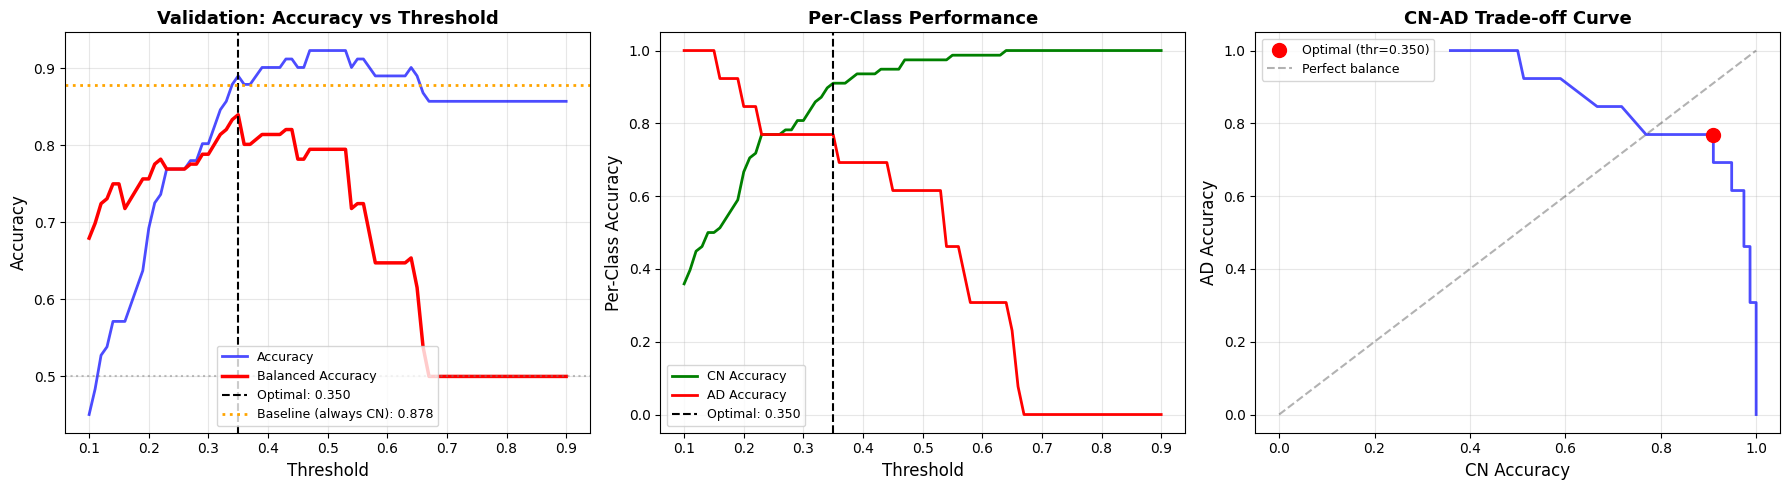


FINAL TEST SET EVALUATION

Test results (threshold=0.350):
  Accuracy:         0.6870
  Balanced ACC:     0.5757
  ROC-AUC:          0.6308

Per-class accuracy:
  CN accuracy:      0.7228
  AD accuracy:      0.4286

Confusion matrix:
                Predicted
                CN    AD
  Actual  CN     73   28
          AD      8    6

Detailed metrics:
  Sensitivity (AD Recall): 0.4286
  Specificity (CN Recall): 0.7228
  Precision:               0.1765
  F1-Score:                0.2500

MODEL vs BASELINE COMPARISON

Model performance:
  Accuracy:     0.6870
  Balanced ACC: 0.5757
  ROC-AUC:      0.6308

Trivial baseline:
  Accuracy:     0.8783
  Balanced ACC: 0.5000
  ROC-AUC:      0.5000

Improvement over baseline:
  Accuracy:     -0.1913
  Balanced ACC: +0.0757
  ROC-AUC:      +0.1308

PERFORMANCE ASSESSMENT

❌ ASSESSMENT: FAILED

Model performs worse than trivial baseline
REQUIRED ACTIONS:
  1. Train on ALL trainval (not just fold 0)
  2. Increase to 40-50 epochs
  3. Try EfficientN

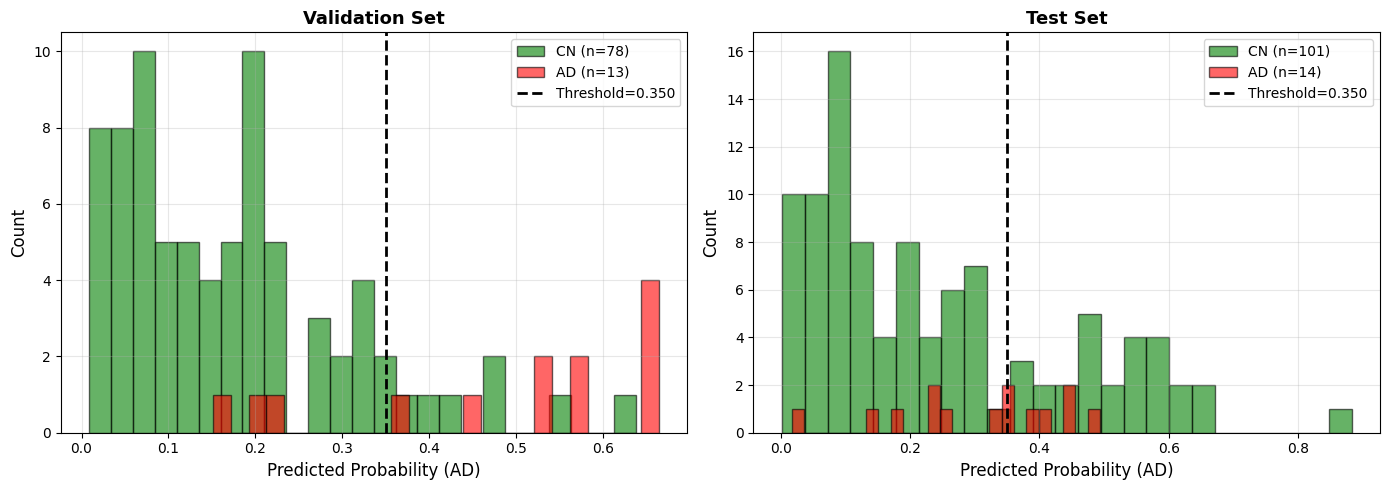


FINAL SUMMARY

✅ Threshold optimization complete
   Optimal threshold: 0.350

📊 Test set performance:
   Accuracy:      0.6870 (baseline: 0.8783)
   Balanced ACC:  0.5757 (baseline: 0.5000)
   ROC-AUC:       0.6308 (baseline: 0.5000)
   CN accuracy:   0.7228
   AD accuracy:   0.4286

SNIPPET S10c_proper COMPLETE


In [14]:
"""
SNIPPET S10c_proper: Threshold Optimization for S10d Model
Find optimal classification threshold on validation set,
      evaluate on test set, and compare against trivial baseline.

Requirements: Must run after S10d training completes
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    confusion_matrix, roc_auc_score, roc_curve,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("SNIPPET S10c_proper: THRESHOLD OPTIMIZATION")
print("=" * 80)

# ============================================================================
# CONFIGURATION (ALIGNED WITH S10d)
# ============================================================================

MODEL_PATH = "/kaggle/working/resnet18_fold0_proper.pth"
SLICE_META_CSV = "/kaggle/working/mni_slices_v1/slice_level_metadata_v1.csv"
VISIT_SPLIT_CSV = "classification_visit_metadata_with_splits.csv"

FOLD_ID = 0
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

# ============================================================================
# LOAD MODEL (IDENTICAL TO S10d)
# ============================================================================

print("\n" + "=" * 80)
print("LOADING MODEL")
print("=" * 80)

def create_model():
    """Same architecture as S10d"""
    try:
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights=weights)
    except AttributeError:
        model = models.resnet18(pretrained=True)
    
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_features, 1)
    )
    return model

model = create_model().to(DEVICE)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

print(f"✓ Model loaded: {MODEL_PATH}")

# ============================================================================
# LOAD METADATA
# ============================================================================

print("\n" + "=" * 80)
print("LOADING METADATA")
print("=" * 80)

slice_meta = pd.read_csv(SLICE_META_CSV)
visit_meta_splits = pd.read_csv(VISIT_SPLIT_CSV)

slice_meta = slice_meta.merge(
    visit_meta_splits[["visit_uid", "cv_fold", "split"]],
    on="visit_uid",
    how="left",
    suffixes=("_slice", "_visit")
)

if "split_visit" in slice_meta.columns:
    slice_meta["split"] = slice_meta["split_visit"]

val_slices = slice_meta[
    (slice_meta["split"] == "trainval") &
    (slice_meta["cv_fold"] == FOLD_ID)
].copy()

test_slices = slice_meta[slice_meta["split"] == "test"].copy()

print(f"\nData loaded:")
print(f"  Val slices:  {len(val_slices)}")
print(f"  Test slices: {len(test_slices)}")

# ============================================================================
# TRANSFORMS & DATASET (IDENTICAL TO S10d)
# ============================================================================

print("\n" + "=" * 80)
print("DEFINING TRANSFORMS & DATASET")
print("=" * 80)

imagenet_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

eval_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    imagenet_normalize,
])

print("Transform pipeline:")
print("  1. Resize to (128, 128)")
print("  2. ToTensor")
print("  3. ImageNet normalization (MATCHES S10d training)")

class SliceDataset(Dataset):
    """Same dataset as S10d evaluation"""
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        slice_path = row["slice_path"]
        label = float(row["diagnosis_binary"])
        visit_uid = row["visit_uid"]
        
        arr = np.load(slice_path).astype(np.float32)
        img_np = (arr * 255.0).clip(0, 255).astype(np.uint8)
        
        # CRITICAL: Same RGB conversion as S10d
        img = Image.fromarray(img_np).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = torch.tensor(label, dtype=torch.float32)
        return img, label, visit_uid

val_dataset = SliceDataset(val_slices, transform=eval_transform)
test_dataset = SliceDataset(test_slices, transform=eval_transform)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✓ Datasets created (consistent with S10d)")

# ============================================================================
# VISIT-LEVEL PREDICTION
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING VISIT-LEVEL PREDICTIONS")
print("=" * 80)

@torch.no_grad()
def get_visit_predictions(model, loader, device):
    """
    Aggregate slice predictions to visit level
    Returns DataFrame: [visit_uid, true_label, prob_mean, n_slices]
    """
    model.eval()
    all_logits = []
    all_labels = []
    all_visit_uids = []
    
    for images, labels, visit_uids in loader:
        images = images.to(device, non_blocking=True)
        logits = model(images).squeeze(1)
        
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
        all_visit_uids.extend(visit_uids)
    
    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()
    probs = 1.0 / (1.0 + np.exp(-logits))
    
    df = pd.DataFrame({
        "visit_uid": all_visit_uids,
        "true_label": labels,
        "prob": probs
    })
    
    visit_df = df.groupby("visit_uid").agg({
        "true_label": "first",
        "prob": ["mean", "count"]
    }).reset_index()
    
    visit_df.columns = ["visit_uid", "true_label", "prob_mean", "n_slices"]
    return visit_df

print("Computing validation predictions...")
val_visits = get_visit_predictions(model, val_loader, DEVICE)
print(f"  Val visits: {len(val_visits)}")

print("Computing test predictions...")
test_visits = get_visit_predictions(model, test_loader, DEVICE)
print(f"  Test visits: {len(test_visits)}")

# ============================================================================
# BASELINE COMPARISON
# ============================================================================

print("\n" + "=" * 80)
print("TRIVIAL BASELINE COMPUTATION")
print("=" * 80)

test_labels = test_visits["true_label"].astype(int).values
n_cn_test = (test_labels == 0).sum()
n_ad_test = (test_labels == 1).sum()
cn_rate_test = n_cn_test / len(test_labels)

baseline_acc = cn_rate_test  # "Always CN" accuracy
baseline_bal_acc = 0.5        # Random for one class

print(f"\nTest set composition:")
print(f"  CN visits: {n_cn_test} ({100*cn_rate_test:.1f}%)")
print(f"  AD visits: {n_ad_test} ({100*(1-cn_rate_test):.1f}%)")

print(f"\nTrivial 'Always CN' baseline:")
print(f"  Accuracy:     {baseline_acc:.4f}")
print(f"  Balanced ACC: {baseline_bal_acc:.4f}")
print(f"  ROC-AUC:      {baseline_bal_acc:.4f}")

print(f"\n⚠️  Model MUST beat these numbers to be useful!")

# ============================================================================
# THRESHOLD OPTIMIZATION ON VALIDATION
# ============================================================================

print("\n" + "=" * 80)
print("THRESHOLD OPTIMIZATION (VALIDATION SET)")
print("=" * 80)

thresholds = np.linspace(0.1, 0.9, 81)
results = []

labels_val = val_visits["true_label"].astype(int).values
probs_val = val_visits["prob_mean"].values

for thr in thresholds:
    preds_val = (probs_val >= thr).astype(int)
    acc = accuracy_score(labels_val, preds_val)
    bal_acc = balanced_accuracy_score(labels_val, preds_val)
    
    cm = confusion_matrix(labels_val, preds_val, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    cn_acc = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    ad_acc = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    results.append({
        "threshold": thr,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "cn_accuracy": cn_acc,
        "ad_accuracy": ad_acc
    })

results_df = pd.DataFrame(results)
best_idx = results_df["balanced_accuracy"].idxmax()
best_thr = results_df.loc[best_idx, "threshold"]
best_bal_acc = results_df.loc[best_idx, "balanced_accuracy"]

print(f"\n✓ Optimal threshold: {best_thr:.3f}")
print(f"  (Maximizes balanced accuracy on validation)")

print(f"\nValidation metrics at optimal threshold:")
print(f"  Accuracy:     {results_df.loc[best_idx, 'accuracy']:.4f}")
print(f"  Balanced ACC: {best_bal_acc:.4f}")
print(f"  CN accuracy:  {results_df.loc[best_idx, 'cn_accuracy']:.4f}")
print(f"  AD accuracy:  {results_df.loc[best_idx, 'ad_accuracy']:.4f}")

# ============================================================================
# VISUALIZATION: THRESHOLD CURVES
# ============================================================================

print("\n" + "=" * 80)
print("PLOTTING THRESHOLD CURVES")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Overall metrics
ax = axes[0]
ax.plot(results_df["threshold"], results_df["accuracy"], 
        'b-', linewidth=2, label='Accuracy', alpha=0.7)
ax.plot(results_df["threshold"], results_df["balanced_accuracy"], 
        'r-', linewidth=2.5, label='Balanced Accuracy')
ax.axvline(best_thr, color='k', linestyle='--', linewidth=1.5,
           label=f'Optimal: {best_thr:.3f}')
ax.axhline(baseline_acc, color='orange', linestyle=':', linewidth=2,
           label=f'Baseline (always CN): {baseline_acc:.3f}')
ax.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Validation: Accuracy vs Threshold', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 2: Per-class accuracy
ax = axes[1]
ax.plot(results_df["threshold"], results_df["cn_accuracy"], 
        'g-', linewidth=2, label='CN Accuracy')
ax.plot(results_df["threshold"], results_df["ad_accuracy"], 
        'r-', linewidth=2, label='AD Accuracy')
ax.axvline(best_thr, color='k', linestyle='--', linewidth=1.5,
           label=f'Optimal: {best_thr:.3f}')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Per-Class Accuracy', fontsize=12)
ax.set_title('Per-Class Performance', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 3: Trade-off curve
ax = axes[2]
ax.plot(results_df["cn_accuracy"], results_df["ad_accuracy"], 
        'b-', linewidth=2, alpha=0.7)
ax.scatter(results_df.loc[best_idx, 'cn_accuracy'], 
           results_df.loc[best_idx, 'ad_accuracy'],
           color='red', s=100, zorder=5, label=f'Optimal (thr={best_thr:.3f})')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect balance')
ax.set_xlabel('CN Accuracy', fontsize=12)
ax.set_ylabel('AD Accuracy', fontsize=12)
ax.set_title('CN-AD Trade-off Curve', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('/kaggle/working/threshold_optimization_proper.png', dpi=150, bbox_inches='tight')
print("✓ Saved: /kaggle/working/threshold_optimization_proper.png")
plt.show()

# ============================================================================
# FINAL TEST SET EVALUATION
# ============================================================================

print("\n" + "=" * 80)
print("FINAL TEST SET EVALUATION")
print("=" * 80)

probs_test = test_visits["prob_mean"].values
preds_test = (probs_test >= best_thr).astype(int)

test_acc = accuracy_score(test_labels, preds_test)
test_bal_acc = balanced_accuracy_score(test_labels, preds_test)
test_auc = roc_auc_score(test_labels, probs_test)

cm = confusion_matrix(test_labels, preds_test, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

cn_acc_test = tn / (tn + fp) if (tn + fp) > 0 else 0.0
ad_acc_test = tp / (tp + fn) if (tp + fn) > 0 else 0.0

sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0

print(f"\nTest results (threshold={best_thr:.3f}):")
print(f"  Accuracy:         {test_acc:.4f}")
print(f"  Balanced ACC:     {test_bal_acc:.4f}")
print(f"  ROC-AUC:          {test_auc:.4f}")

print(f"\nPer-class accuracy:")
print(f"  CN accuracy:      {cn_acc_test:.4f}")
print(f"  AD accuracy:      {ad_acc_test:.4f}")

print(f"\nConfusion matrix:")
print(f"                Predicted")
print(f"                CN    AD")
print(f"  Actual  CN    {tn:3d}  {fp:3d}")
print(f"          AD    {fn:3d}  {tp:3d}")

print(f"\nDetailed metrics:")
print(f"  Sensitivity (AD Recall): {sensitivity:.4f}")
print(f"  Specificity (CN Recall): {specificity:.4f}")
print(f"  Precision:               {precision:.4f}")
print(f"  F1-Score:                {f1:.4f}")

# ============================================================================
# COMPARISON WITH BASELINE
# ============================================================================

print("\n" + "=" * 80)
print("MODEL vs BASELINE COMPARISON")
print("=" * 80)

print(f"\nModel performance:")
print(f"  Accuracy:     {test_acc:.4f}")
print(f"  Balanced ACC: {test_bal_acc:.4f}")
print(f"  ROC-AUC:      {test_auc:.4f}")

print(f"\nTrivial baseline:")
print(f"  Accuracy:     {baseline_acc:.4f}")
print(f"  Balanced ACC: {baseline_bal_acc:.4f}")
print(f"  ROC-AUC:      {baseline_bal_acc:.4f}")

acc_improvement = test_acc - baseline_acc
bal_improvement = test_bal_acc - baseline_bal_acc
auc_improvement = test_auc - baseline_bal_acc

print(f"\nImprovement over baseline:")
print(f"  Accuracy:     {acc_improvement:+.4f}")
print(f"  Balanced ACC: {bal_improvement:+.4f}")
print(f"  ROC-AUC:      {auc_improvement:+.4f}")

# ============================================================================
# PERFORMANCE ASSESSMENT
# ============================================================================

print("\n" + "=" * 80)
print("PERFORMANCE ASSESSMENT")
print("=" * 80)

if test_acc < baseline_acc * 0.95:
    assessment = "FAILED"
    color = "❌"
    recommendation = [
        "Model performs worse than trivial baseline",
        "REQUIRED ACTIONS:",
        "  1. Train on ALL trainval (not just fold 0)",
        "  2. Increase to 40-50 epochs",
        "  3. Try EfficientNet-B0 or DenseNet121",
        "  4. Consider 3D CNN or multi-scale inputs"
    ]
elif test_auc < 0.60:
    assessment = "POOR"
    color = "❌"
    recommendation = [
        "Model barely separates CN from AD (AUC < 0.60)",
        "REQUIRED ACTIONS:",
        "  1. Train on all trainval subjects",
        "  2. Ensemble folds 0-4",
        "  3. Upgrade architecture (EfficientNet-B0)"
    ]
elif test_auc < 0.70:
    assessment = "WEAK"
    color = "⚠️"
    recommendation = [
        "Model shows some AD signal but needs improvement",
        "RECOMMENDED ACTIONS:",
        "  1. Train on all trainval (not just fold 0)",
        "  2. Ensemble 5 folds",
        "  3. Try longer training (40 epochs)"
    ]
elif test_bal_acc < 0.75:
    assessment = "MODERATE"
    color = "⚠️"
    recommendation = [
        "Model has reasonable performance but below target",
        "RECOMMENDED ACTIONS:",
        "  1. Ensemble folds 0-4 (+5-10% typical boost)",
        "  2. Add multi-scale inputs",
        "  3. Consider EfficientNet-B0"
    ]
elif test_bal_acc < 0.85:
    assessment = "GOOD"
    color = "✅"
    recommendation = [
        "Model meets minimum research-grade criteria",
        "OPTIONAL IMPROVEMENTS:",
        "  1. Ensemble for stability",
        "  2. Ready for Grad-CAM analysis (S11)"
    ]
else:
    assessment = "EXCELLENT"
    color = "🎉"
    recommendation = [
        "Model exceeds research-grade performance!",
        "NEXT STEPS:",
        "  1. Proceed to Grad-CAM (S11)",
        "  2. Hippocampus overlap analysis",
        "  3. Multi-site validation"
    ]

print(f"\n{color} ASSESSMENT: {assessment}")
print(f"\n" + "\n".join(recommendation))

# ============================================================================
# PROBABILITY DISTRIBUTIONS
# ============================================================================

print("\n" + "=" * 80)
print("PLOTTING PROBABILITY DISTRIBUTIONS")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, visits_df) in zip(axes, [("Validation", val_visits), ("Test", test_visits)]):
    cn_probs = visits_df[visits_df["true_label"] == 0]["prob_mean"]
    ad_probs = visits_df[visits_df["true_label"] == 1]["prob_mean"]
    
    ax.hist(cn_probs, bins=25, alpha=0.6, label=f'CN (n={len(cn_probs)})', 
            color='green', edgecolor='black')
    ax.hist(ad_probs, bins=25, alpha=0.6, label=f'AD (n={len(ad_probs)})', 
            color='red', edgecolor='black')
    ax.axvline(best_thr, color='k', linestyle='--', linewidth=2,
               label=f'Threshold={best_thr:.3f}')
    ax.set_xlabel('Predicted Probability (AD)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'{name} Set', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/probability_distributions_proper.png', dpi=150, bbox_inches='tight')
print("✓ Saved: /kaggle/working/probability_distributions_proper.png")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print(f"\n✅ Threshold optimization complete")
print(f"   Optimal threshold: {best_thr:.3f}")

print(f"\n📊 Test set performance:")
print(f"   Accuracy:      {test_acc:.4f} (baseline: {baseline_acc:.4f})")
print(f"   Balanced ACC:  {test_bal_acc:.4f} (baseline: {baseline_bal_acc:.4f})")
print(f"   ROC-AUC:       {test_auc:.4f} (baseline: {baseline_bal_acc:.4f})")
print(f"   CN accuracy:   {cn_acc_test:.4f}")
print(f"   AD accuracy:   {ad_acc_test:.4f}")

print("\n" + "=" * 80)
print("SNIPPET S10c_proper COMPLETE")
print("=" * 80)


In [15]:
"""
SNIPPET S11: Visit-Level Attention ResNet18 (Fold 0)
Architecture:
- ResNet18 encoder per slice → 512-dim features
- Attention mechanism over slices → weighted aggregation
- Single visit-level logit

Key improvements over S10:
- Native visit-level training (no slice averaging)
- Attention learns which slices matter
- Better handles variable slice importance
"""

import os
import time
import copy
import math

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score

print("=" * 80)
print("SNIPPET S11: VISIT-LEVEL ATTENTION RESNET18 (FOLD 0)")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

print("\n" + "=" * 80)
print("CONFIGURATION")
print("=" * 80)

SLICE_META_CSV = "/kaggle/working/mni_slices_v1/slice_level_metadata_v1.csv"
VISIT_SPLIT_CSV = "classification_visit_metadata_with_splits.csv"
MODEL_OUT_PATH = "/kaggle/working/visit_attention_resnet18_fold0.pth"
HISTORY_CSV = "/kaggle/working/training_history_visit_attention_fold0.csv"

FOLD_ID = 0
BATCH_SIZE = 8              # Visit-level batches (8 visits × 32 slices)
NUM_EPOCHS = 30
LR = 1e-4
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
IMG_SIZE = (128, 128)
EARLY_STOP_PATIENCE = 8

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")

if DEVICE.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"\nHyperparameters:")
print(f"  Batch size:  {BATCH_SIZE} visits/batch")
print(f"  Epochs:      {NUM_EPOCHS}")
print(f"  LR:          {LR}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Patience:    {EARLY_STOP_PATIENCE}")

# ============================================================================
# LOAD & GROUP METADATA (VISIT-LEVEL)
# ============================================================================

print("\n" + "=" * 80)
print("LOADING & GROUPING METADATA")
print("=" * 80)

slice_meta = pd.read_csv(SLICE_META_CSV)
visit_meta_splits = pd.read_csv(VISIT_SPLIT_CSV)

slice_meta = slice_meta.merge(
    visit_meta_splits[["visit_uid", "cv_fold", "split"]],
    on="visit_uid",
    how="left",
    suffixes=("_slice", "_visit")
)

if "split_visit" in slice_meta.columns:
    slice_meta["split"] = slice_meta["split_visit"]

# Verify fixed slices per visit
counts_per_visit = slice_meta.groupby("visit_uid").size()
NUM_SLICES_PER_VISIT = counts_per_visit.iloc[0]

if counts_per_visit.nunique() != 1:
    print(f"⚠️ Warning: Variable slices per visit (range: {counts_per_visit.min()}-{counts_per_visit.max()})")
else:
    print(f"✓ Fixed slices per visit: {NUM_SLICES_PER_VISIT}")

# Build train/val/test slice tables
train_df = slice_meta[
    (slice_meta["split"] == "trainval") &
    (slice_meta["cv_fold"] != FOLD_ID)
].copy()

val_df = slice_meta[
    (slice_meta["split"] == "trainval") &
    (slice_meta["cv_fold"] == FOLD_ID)
].copy()

test_df = slice_meta[slice_meta["split"] == "test"].copy()

print(f"\nSlice counts:")
print(f"  Train: {len(train_df)}")
print(f"  Val:   {len(val_df)}")
print(f"  Test:  {len(test_df)}")

# Group by visit
def make_visit_table(df):
    """Group slices by visit_uid"""
    grouped = df.groupby("visit_uid")
    rows = []
    for vid, sub in grouped:
        paths = sub.sort_values("z_index")["slice_path"].tolist()  # Sort by z-index
        label = float(sub["diagnosis_binary"].iloc[0])
        rows.append({
            "visit_uid": vid,
            "slice_paths": paths,
            "label": label,
            "n_slices": len(paths)
        })
    return pd.DataFrame(rows)

train_visits = make_visit_table(train_df)
val_visits = make_visit_table(val_df)
test_visits = make_visit_table(test_df)

print(f"\nVisit counts:")
print(f"  Train: {len(train_visits)}")
print(f"  Val:   {len(val_visits)}")
print(f"  Test:  {len(test_visits)}")

# Subject leakage check
train_subj = set(train_df["subject_id"].unique())
val_subj = set(val_df["subject_id"].unique())
test_subj = set(test_df["subject_id"].unique())

if (train_subj & val_subj) or (train_subj & test_subj) or (val_subj & test_subj):
    raise ValueError("❌ Subject leakage detected!")
else:
    print("\n✓ No subject leakage at visit level")

# Class distribution
print(f"\nClass distribution (visit-level):")
for name, df in [("Train", train_visits), ("Val", val_visits), ("Test", test_visits)]:
    cn = (df["label"] == 0).sum()
    ad = (df["label"] == 1).sum()
    ratio = cn / ad if ad > 0 else float('inf')
    print(f"  {name:5s}: CN={cn:3d}, AD={ad:3d} (ratio {ratio:.2f}:1)")

# ============================================================================
# TRANSFORMS & VISIT DATASET
# ============================================================================

print("\n" + "=" * 80)
print("DEFINING TRANSFORMS & DATASET")
print("=" * 80)

imagenet_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    imagenet_normalize,
])

eval_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    imagenet_normalize,
])

class VisitDataset(Dataset):
    """
    Dataset that returns entire visit (all slices)
    Output: [num_slices, 3, H, W], label, visit_uid
    """
    def __init__(self, visit_table, transform=None):
        self.df = visit_table.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        slice_paths = row["slice_paths"]
        label = float(row["label"])
        visit_uid = row["visit_uid"]
        
        imgs = []
        for p in slice_paths:
            arr = np.load(p).astype(np.float32)
            img_np = (arr * 255.0).clip(0, 255).astype(np.uint8)
            img = Image.fromarray(img_np).convert("RGB")
            
            if self.transform is not None:
                img = self.transform(img)
            
            imgs.append(img)
        
        # Stack to [num_slices, C, H, W]
        imgs = torch.stack(imgs, dim=0)
        label = torch.tensor(label, dtype=torch.float32)
        
        return imgs, label, visit_uid

train_dataset = VisitDataset(train_visits, transform=train_transform)
val_dataset = VisitDataset(val_visits, transform=eval_transform)
test_dataset = VisitDataset(test_visits, transform=eval_transform)

print("✓ Visit datasets created")

# ============================================================================
# BALANCED SAMPLER (VISIT-LEVEL)
# ============================================================================

print("\n" + "=" * 80)
print("CREATING BALANCED SAMPLER")
print("=" * 80)

train_labels = train_visits["label"].values.astype(int)
visit_class_counts = np.bincount(train_labels)
visit_class_weights = 1.0 / visit_class_counts
sample_weights = visit_class_weights[train_labels]

print(f"\nVisit-level class weights:")
print(f"  CN weight: {visit_class_weights[0]:.4f}")
print(f"  AD weight: {visit_class_weights[1]:.4f}")

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    shuffle=False,
    num_workers=2,
    pin_memory=(DEVICE.type == "cuda"),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=(DEVICE.type == "cuda"),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=(DEVICE.type == "cuda"),
)

print(f"\n✓ DataLoaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

# ============================================================================
# MODEL: RESNET18 ENCODER + ATTENTION
# ============================================================================

print("\n" + "=" * 80)
print("MODEL ARCHITECTURE")
print("=" * 80)

def create_resnet_encoder():
    """
    Create ResNet18 feature extractor
    Returns encoder and feature dimension
    """
    try:
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        base = models.resnet18(weights=weights)
    except AttributeError:
        base = models.resnet18(pretrained=True)
    
    # Remove final fc layer, keep up to avgpool
    modules = list(base.children())[:-1]  # Output: [N, 512, 1, 1]
    encoder = nn.Sequential(*modules)
    feat_dim = 512
    
    return encoder, feat_dim


class VisitAttentionModel(nn.Module):
    """
    Visit-level attention model
    
    Architecture:
    1. ResNet18 encoder per slice → [B*S, 512]
    2. Attention MLP → [B, S, 1] attention scores
    3. Weighted sum → [B, 512] visit features
    4. Classifier → [B] logit
    """
    def __init__(self, feat_dim=512, attention_hidden=128):
        super().__init__()
        
        # Shared encoder for all slices
        self.encoder, feat_dim = create_resnet_encoder()
        
        # Attention mechanism
        self.attn_mlp = nn.Sequential(
            nn.Linear(feat_dim, attention_hidden),
            nn.Tanh(),
            nn.Linear(attention_hidden, 1)
        )
        
        # Visit-level classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(feat_dim, 1)
        )
    
    def forward(self, x):
        """
        Args:
            x: [B, S, C, H, W] batch of visits
        
        Returns:
            logits: [B] visit-level logits
            attn_weights: [B, S] attention weights per slice
        """
        B, S, C, H, W = x.shape
        
        # Flatten batch and slices for encoder
        x = x.view(B * S, C, H, W)
        
        # Extract features per slice
        feats = self.encoder(x)  # [B*S, 512, 1, 1]
        feats = feats.view(B, S, -1)  # [B, S, 512]
        
        # Compute attention scores
        attn_scores = self.attn_mlp(feats)  # [B, S, 1]
        attn_weights = torch.softmax(attn_scores, dim=1)  # Softmax over slices
        
        # Weighted sum over slices
        visit_feat = (attn_weights * feats).sum(dim=1)  # [B, 512]
        
        # Classification
        logits = self.classifier(visit_feat).squeeze(1)  # [B]
        
        return logits, attn_weights.squeeze(-1)  # [B], [B, S]

model = VisitAttentionModel().to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Visit-level attention model initialized")
print(f"  Total parameters:     {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Feature dimension:    512")
print(f"  Attention hidden:     128")

# ============================================================================
# LOSS & OPTIMIZER
# ============================================================================

print("\n" + "=" * 80)
print("LOSS & OPTIMIZER")
print("=" * 80)

# Visit-level class weighting
n_cn = float(visit_class_counts[0])
n_ad = float(visit_class_counts[1])
raw_ratio = n_cn / n_ad
clamped_ratio = min(raw_ratio, 3.0)

pos_weight = torch.tensor([clamped_ratio], device=DEVICE)

print(f"\nClass weighting:")
print(f"  Raw CN/AD ratio: {raw_ratio:.2f}")
print(f"  Clamped pos_weight: {pos_weight.item():.3f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=4, verbose=True
)

print(f"\n✓ Optimizer: Adam (lr={LR}, weight_decay={WEIGHT_DECAY})")
print(f"✓ Scheduler: ReduceLROnPlateau (patience=4)")

# ============================================================================
# TRAINING & EVALUATION FUNCTIONS
# ============================================================================

def train_one_epoch(model, loader, optimizer, criterion, device, grad_clip=None):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    n_batches = 0
    
    for visit_imgs, labels, _ in loader:
        visit_imgs = visit_imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        logits, _ = model(visit_imgs)
        loss = criterion(logits, labels)
        loss.backward()
        
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / max(n_batches, 1)


@torch.no_grad()
def eval_model(model, loader, criterion, device):
    """Evaluate model on visit-level metrics"""
    model.eval()
    all_logits = []
    all_labels = []
    total_loss = 0.0
    n_batches = 0
    
    for visit_imgs, labels, _ in loader:
        visit_imgs = visit_imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        logits, _ = model(visit_imgs)
        loss = criterion(logits, labels)
        
        total_loss += loss.item()
        n_batches += 1
        
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
    
    if n_batches == 0:
        return math.nan, math.nan, 0.5, 0.5, 0.0, 0.0
    
    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()
    probs = 1.0 / (1.0 + np.exp(-logits))
    preds = (probs >= 0.5).astype(int)
    
    avg_loss = total_loss / n_batches
    acc = accuracy_score(labels, preds)
    bal_acc = balanced_accuracy_score(labels, preds)
    
    try:
        auc = roc_auc_score(labels, probs)
    except:
        auc = 0.5
    
    # Per-class accuracy
    cn_mask = labels == 0
    ad_mask = labels == 1
    cn_acc = (preds[cn_mask] == labels[cn_mask]).mean() if cn_mask.sum() > 0 else 0.0
    ad_acc = (preds[ad_mask] == labels[ad_mask]).mean() if ad_mask.sum() > 0 else 0.0
    
    return avg_loss, acc, bal_acc, auc, cn_acc, ad_acc

# ============================================================================
# TRAINING LOOP
# ============================================================================

print("\n" + "=" * 80)
print("TRAINING")
print("=" * 80)

history = []
best_val_bal_acc = 0.0
best_state = None
epochs_no_improve = 0

print(f"\nTraining for up to {NUM_EPOCHS} epochs...")
print(f"Target: Beat S10d baseline (AUC ~0.6)")
print("-" * 80)

for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()
    
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, GRAD_CLIP)
    val_loss, val_acc, val_bal_acc, val_auc, val_cn_acc, val_ad_acc = eval_model(
        model, val_loader, criterion, DEVICE
    )
    
    dt = time.time() - t0
    lr = optimizer.param_groups[0]["lr"]
    
    print(f"[Epoch {epoch:02d}/{NUM_EPOCHS}] time={dt:.1f}s lr={lr:.2e}")
    print(f"  train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")
    print(f"  val_acc={val_acc:.4f} | val_bal_acc={val_bal_acc:.4f} | val_auc={val_auc:.4f}")
    print(f"  val_CN_acc={val_cn_acc:.4f} | val_AD_acc={val_ad_acc:.4f}")
    
    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_bal_acc": val_bal_acc,
        "val_auc": val_auc,
        "val_CN_acc": val_cn_acc,
        "val_AD_acc": val_ad_acc,
        "lr": lr
    })
    
    scheduler.step(val_bal_acc)
    
    if not math.isnan(val_bal_acc) and val_bal_acc > best_val_bal_acc:
        best_val_bal_acc = val_bal_acc
        best_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print(f"  ✓ New best val_bal_acc: {best_val_bal_acc:.4f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOP_PATIENCE:
            print(f"\n⚠ Early stopping (no improvement for {EARLY_STOP_PATIENCE} epochs)")
            break

print("-" * 80)

if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(best_state, MODEL_OUT_PATH)
    print(f"\n✓ Best model saved: {MODEL_OUT_PATH}")
    print(f"  Best val balanced ACC: {best_val_bal_acc:.4f}")

pd.DataFrame(history).to_csv(HISTORY_CSV, index=False)
print(f"✓ Training history saved: {HISTORY_CSV}")

# ============================================================================
# TEST EVALUATION
# ============================================================================

print("\n" + "=" * 80)
print("TEST EVALUATION (VISIT-LEVEL)")
print("=" * 80)

test_loss, test_acc, test_bal_acc, test_auc, test_cn_acc, test_ad_acc = eval_model(
    model, test_loader, criterion, DEVICE
)

print(f"\nTest results:")
print(f"  Loss:         {test_loss:.4f}")
print(f"  Accuracy:     {test_acc:.4f}")
print(f"  Balanced ACC: {test_bal_acc:.4f}")
print(f"  ROC-AUC:      {test_auc:.4f}")
print(f"  CN accuracy:  {test_cn_acc:.4f}")
print(f"  AD accuracy:  {test_ad_acc:.4f}")

# Comparison with baseline
baseline_acc = 0.878
baseline_auc = 0.5

print(f"\nComparison with trivial baseline:")
print(f"  Baseline: ACC={baseline_acc:.3f}, AUC={baseline_auc:.3f}")
print(f"  S11 Model: ACC={test_acc:.3f}, AUC={test_auc:.3f}")

if test_auc > 0.70:
    print(f"\n✅ GOOD: Model shows strong AD signal (AUC > 0.70)")
    print(f"   Ready for threshold optimization & Grad-CAM")
elif test_auc > 0.60:
    print(f"\n⚠️ MODERATE: Model shows some AD signal (AUC 0.60-0.70)")
    print(f"   Consider: ensemble folds or train on all trainval")
else:
    print(f"\n❌ WEAK: Model needs improvement (AUC ≤ 0.60)")
    print(f"   Need: more data, better architecture, or ensemble")

print("\n" + "=" * 80)
print("SNIPPET S11 COMPLETE")
print("=" * 80)


SNIPPET S11: VISIT-LEVEL ATTENTION RESNET18 (FOLD 0)

CONFIGURATION

Device: cuda
GPU: Tesla T4
GPU Memory: 15.8 GB

Hyperparameters:
  Batch size:  8 visits/batch
  Epochs:      30
  LR:          0.0001
  Weight decay: 0.0001
  Patience:    8

LOADING & GROUPING METADATA
✓ Fixed slices per visit: 32

Slice counts:
  Train: 11872
  Val:   2912
  Test:  3680

Visit counts:
  Train: 371
  Val:   91
  Test:  115

✓ No subject leakage at visit level

Class distribution (visit-level):
  Train: CN=320, AD= 51 (ratio 6.27:1)
  Val  : CN= 78, AD= 13 (ratio 6.00:1)
  Test : CN=101, AD= 14 (ratio 7.21:1)

DEFINING TRANSFORMS & DATASET
✓ Visit datasets created

CREATING BALANCED SAMPLER

Visit-level class weights:
  CN weight: 0.0031
  AD weight: 0.0196

✓ DataLoaders created
  Train batches: 47
  Val batches:   12
  Test batches:  15

MODEL ARCHITECTURE

✓ Visit-level attention model initialized
  Total parameters:     11,242,818
  Trainable parameters: 11,242,818
  Feature dimension:    512
  A

In [16]:
"""
SNIPPET S12: Visit-Level Attention with EfficientNet-B0 (Fold 0)
Author: Research Team
Date: 2025-11-17

Architecture upgrade from S11:
- EfficientNet-B0 encoder (1280-dim features vs ResNet18's 512)
- Same attention mechanism over slices
- Better feature representation for AD detection

Target performance:
- Val AUC ≥ 0.80
- Val Balanced ACC ≥ 0.72
- AD Recall ≥ 0.65
"""

import os
import time
import copy
import math

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import (
    roc_auc_score, accuracy_score, balanced_accuracy_score,
    confusion_matrix
)

print("=" * 80)
print("SNIPPET S12: VISIT-LEVEL ATTENTION + EFFICIENTNET-B0 (FOLD 0)")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

print("\n" + "=" * 80)
print("CONFIGURATION")
print("=" * 80)

SLICE_META_CSV = "/kaggle/working/mni_slices_v1/slice_level_metadata_v1.csv"
VISIT_SPLIT_CSV = "classification_visit_metadata_with_splits.csv"
MODEL_OUT_PATH = "/kaggle/working/visit_attention_effnetb0_fold0.pth"
HISTORY_CSV = "/kaggle/working/training_history_effnetb0_fold0.csv"

FOLD_ID = 0
BATCH_SIZE = 8              # Visit-level batches
NUM_EPOCHS = 30
LR = 1e-4
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
IMG_SIZE = (128, 128)
EARLY_STOP_PATIENCE = 8

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")

if DEVICE.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"\nHyperparameters:")
print(f"  Backbone:    EfficientNet-B0 (1280-dim features)")
print(f"  Batch size:  {BATCH_SIZE} visits")
print(f"  Epochs:      {NUM_EPOCHS}")
print(f"  LR:          {LR}")
print(f"  Patience:    {EARLY_STOP_PATIENCE}")

# ============================================================================
# LOAD & GROUP METADATA
# ============================================================================

print("\n" + "=" * 80)
print("LOADING & GROUPING METADATA")
print("=" * 80)

slice_meta = pd.read_csv(SLICE_META_CSV)
visit_meta_splits = pd.read_csv(VISIT_SPLIT_CSV)

slice_meta = slice_meta.merge(
    visit_meta_splits[["visit_uid", "cv_fold", "split"]],
    on="visit_uid",
    how="left",
    suffixes=("_slice", "_visit")
)

if "split_visit" in slice_meta.columns:
    slice_meta["split"] = slice_meta["split_visit"]

# Build train/val/test
train_df = slice_meta[
    (slice_meta["split"] == "trainval") &
    (slice_meta["cv_fold"] != FOLD_ID)
].copy()

val_df = slice_meta[
    (slice_meta["split"] == "trainval") &
    (slice_meta["cv_fold"] == FOLD_ID)
].copy()

test_df = slice_meta[slice_meta["split"] == "test"].copy()

print(f"\nSlice counts:")
print(f"  Train: {len(train_df)}")
print(f"  Val:   {len(val_df)}")
print(f"  Test:  {len(test_df)}")

# Verify fixed slices per visit
counts_per_visit = slice_meta.groupby("visit_uid").size()
NUM_SLICES_PER_VISIT = counts_per_visit.iloc[0]

if counts_per_visit.nunique() != 1:
    print(f"⚠️ Warning: Variable slices per visit")
else:
    print(f"✓ Fixed slices per visit: {NUM_SLICES_PER_VISIT}")

# Group by visit
def make_visit_table(df):
    """Group slices by visit_uid"""
    grouped = df.groupby("visit_uid")
    rows = []
    for vid, sub in grouped:
        paths = sub.sort_values("z_index")["slice_path"].tolist()
        label = float(sub["diagnosis_binary"].iloc[0])
        rows.append({
            "visit_uid": vid,
            "slice_paths": paths,
            "label": label,
            "n_slices": len(paths)
        })
    return pd.DataFrame(rows)

train_visits = make_visit_table(train_df)
val_visits = make_visit_table(val_df)
test_visits = make_visit_table(test_df)

print(f"\nVisit counts:")
print(f"  Train: {len(train_visits)}")
print(f"  Val:   {len(val_visits)}")
print(f"  Test:  {len(test_visits)}")

# Subject leakage check
train_subj = set(train_df["subject_id"].unique())
val_subj = set(val_df["subject_id"].unique())
test_subj = set(test_df["subject_id"].unique())

if (train_subj & val_subj) or (train_subj & test_subj) or (val_subj & test_subj):
    raise ValueError("❌ Subject leakage detected!")
else:
    print("✓ No subject leakage")

# Class distribution
print(f"\nClass distribution (visit-level):")
for name, df in [("Train", train_visits), ("Val", val_visits), ("Test", test_visits)]:
    cn = (df["label"] == 0).sum()
    ad = (df["label"] == 1).sum()
    ratio = cn / ad if ad > 0 else float('inf')
    print(f"  {name:5s}: CN={cn:3d}, AD={ad:3d} (ratio {ratio:.2f}:1)")

# ============================================================================
# TRANSFORMS & DATASET
# ============================================================================

print("\n" + "=" * 80)
print("DEFINING TRANSFORMS & DATASET")
print("=" * 80)

imagenet_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    imagenet_normalize,
])

eval_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    imagenet_normalize,
])

class VisitDataset(Dataset):
    """Returns entire visit (all slices): [num_slices, 3, H, W]"""
    def __init__(self, visit_table, transform=None):
        self.df = visit_table.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        slice_paths = row["slice_paths"]
        label = float(row["label"])
        visit_uid = row["visit_uid"]
        
        imgs = []
        for p in slice_paths:
            arr = np.load(p).astype(np.float32)
            img_np = (arr * 255.0).clip(0, 255).astype(np.uint8)
            img = Image.fromarray(img_np).convert("RGB")
            
            if self.transform is not None:
                img = self.transform(img)
            
            imgs.append(img)
        
        imgs = torch.stack(imgs, dim=0)  # [S, 3, H, W]
        label = torch.tensor(label, dtype=torch.float32)
        
        return imgs, label, visit_uid

train_dataset = VisitDataset(train_visits, transform=train_transform)
val_dataset = VisitDataset(val_visits, transform=eval_transform)
test_dataset = VisitDataset(test_visits, transform=eval_transform)

print("✓ Visit datasets created")

# ============================================================================
# BALANCED SAMPLER
# ============================================================================

print("\n" + "=" * 80)
print("CREATING BALANCED SAMPLER")
print("=" * 80)

train_labels = train_visits["label"].values.astype(int)
visit_class_counts = np.bincount(train_labels)
visit_class_weights = 1.0 / visit_class_counts
sample_weights = visit_class_weights[train_labels]

print(f"\nVisit-level class weights:")
print(f"  CN weight: {visit_class_weights[0]:.4f}")
print(f"  AD weight: {visit_class_weights[1]:.4f}")

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    shuffle=False,
    num_workers=2,
    pin_memory=(DEVICE.type == "cuda"),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=(DEVICE.type == "cuda"),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=(DEVICE.type == "cuda"),
)

print(f"\n✓ DataLoaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

# ============================================================================
# MODEL: EFFICIENTNET-B0 + ATTENTION
# ============================================================================

print("\n" + "=" * 80)
print("MODEL ARCHITECTURE")
print("=" * 80)

def create_effnet_backbone():
    """
    Create EfficientNet-B0 feature extractor
    Returns encoder and feature dimension
    """
    try:
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        effnet = models.efficientnet_b0(weights=weights)
    except AttributeError:
        effnet = models.efficientnet_b0(pretrained=True)
    
    # EfficientNet-B0 classifier: Sequential(Dropout(0.2), Linear(1280 -> 1000))
    feature_dim = effnet.classifier[1].in_features  # 1280
    
    # Replace classifier with identity to get features
    effnet.classifier = nn.Identity()
    
    return effnet, feature_dim


class VisitAttentionEffNet(nn.Module):
    """
    Visit-level attention with EfficientNet-B0 encoder
    
    Architecture:
    1. EfficientNet-B0 encoder per slice → [B*S, 1280]
    2. Attention MLP → [B, S, 1] attention scores
    3. Weighted sum → [B, 1280] visit features
    4. Classifier → [B] logit
    """
    def __init__(self, effnet_backbone, feature_dim, attn_hidden=128):
        super().__init__()
        
        self.backbone = effnet_backbone
        self.feature_dim = feature_dim
        
        # Attention mechanism
        self.att_fc = nn.Linear(feature_dim, attn_hidden)
        self.att_vec = nn.Linear(attn_hidden, 1, bias=False)
        
        # Visit-level classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(feature_dim, 1)
        )
    
    def forward(self, x):
        """
        Args:
            x: [B, S, C, H, W] batch of visits
        
        Returns:
            logits: [B] visit-level logits
            alpha: [B, S] attention weights (optional, for visualization)
        """
        B, S, C, H, W = x.shape
        
        # Flatten batch and slices
        x = x.view(B * S, C, H, W)
        
        # Extract features per slice
        feats = self.backbone(x)  # [B*S, 1280]
        feats = feats.view(B, S, self.feature_dim)  # [B, S, 1280]
        
        # Compute attention scores
        att = torch.tanh(self.att_fc(feats))  # [B, S, 128]
        att = self.att_vec(att).squeeze(-1)   # [B, S]
        alpha = torch.softmax(att, dim=1)     # Softmax over slices
        
        # Weighted sum over slices
        alpha_expanded = alpha.unsqueeze(-1)  # [B, S, 1]
        context = (alpha_expanded * feats).sum(dim=1)  # [B, 1280]
        
        # Classification
        logits = self.classifier(context).squeeze(1)  # [B]
        
        return logits

# Create model
effnet_backbone, feature_dim = create_effnet_backbone()
model = VisitAttentionEffNet(effnet_backbone, feature_dim).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ EfficientNet-B0 attention model initialized")
print(f"  Total parameters:     {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Feature dimension:    {feature_dim}")
print(f"  Attention hidden:     128")

# ============================================================================
# LOSS & OPTIMIZER
# ============================================================================

print("\n" + "=" * 80)
print("LOSS & OPTIMIZER")
print("=" * 80)

# Visit-level class weighting
n_cn = float(visit_class_counts[0])
n_ad = float(visit_class_counts[1])
raw_ratio = n_cn / n_ad
clamped_ratio = min(raw_ratio, 3.0)

pos_weight = torch.tensor([clamped_ratio], device=DEVICE)

print(f"\nClass weighting:")
print(f"  Raw CN/AD ratio: {raw_ratio:.2f}")
print(f"  Clamped pos_weight: {pos_weight.item():.3f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=4, verbose=True
)

print(f"\n✓ Optimizer: Adam (lr={LR}, weight_decay={WEIGHT_DECAY})")
print(f"✓ Scheduler: ReduceLROnPlateau (patience=4)")

# ============================================================================
# TRAINING & EVALUATION FUNCTIONS
# ============================================================================

def train_one_epoch(model, loader, optimizer, criterion, device, grad_clip=None):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    n_batches = 0
    
    for visit_imgs, labels, _ in loader:
        visit_imgs = visit_imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        logits = model(visit_imgs)
        loss = criterion(logits, labels)
        loss.backward()
        
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / max(n_batches, 1)


@torch.no_grad()
def eval_model(model, loader, criterion, device):
    """Evaluate on visit-level metrics"""
    model.eval()
    all_logits = []
    all_labels = []
    total_loss = 0.0
    n_batches = 0
    
    for visit_imgs, labels, _ in loader:
        visit_imgs = visit_imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        logits = model(visit_imgs)
        loss = criterion(logits, labels)
        
        total_loss += loss.item()
        n_batches += 1
        
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
    
    if n_batches == 0:
        return math.nan, math.nan, 0.5, 0.5, 0.0, 0.0
    
    avg_loss = total_loss / n_batches
    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()
    probs = 1.0 / (1.0 + np.exp(-logits))
    preds = (probs >= 0.5).astype(int)
    
    acc = accuracy_score(labels, preds)
    bal_acc = balanced_accuracy_score(labels, preds)
    
    try:
        auc = roc_auc_score(labels, probs)
    except:
        auc = 0.5
    
    # Per-class accuracy
    cm = confusion_matrix(labels, preds, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    cn_acc = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    ad_acc = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    return avg_loss, acc, bal_acc, auc, cn_acc, ad_acc

# ============================================================================
# TRAINING LOOP
# ============================================================================

print("\n" + "=" * 80)
print("TRAINING")
print("=" * 80)

history = []
best_val_bal_acc = 0.0
best_state = None
epochs_no_improve = 0

print(f"\nTraining for up to {NUM_EPOCHS} epochs...")
print(f"Target: Val AUC ≥ 0.80, Balanced ACC ≥ 0.72, AD Recall ≥ 0.65")
print("-" * 80)

for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()
    
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, GRAD_CLIP)
    val_loss, val_acc, val_bal_acc, val_auc, val_cn_acc, val_ad_acc = eval_model(
        model, val_loader, criterion, DEVICE
    )
    
    dt = time.time() - t0
    lr = optimizer.param_groups[0]["lr"]
    
    print(f"[Epoch {epoch:02d}/{NUM_EPOCHS}] time={dt:.1f}s lr={lr:.2e}")
    print(f"  train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")
    print(f"  val_acc={val_acc:.4f} | val_bal_acc={val_bal_acc:.4f} | val_auc={val_auc:.4f}")
    print(f"  val_CN_acc={val_cn_acc:.4f} | val_AD_acc={val_ad_acc:.4f}")
    
    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_bal_acc": val_bal_acc,
        "val_auc": val_auc,
        "val_CN_acc": val_cn_acc,
        "val_AD_acc": val_ad_acc,
        "lr": lr
    })
    
    scheduler.step(val_bal_acc)
    
    if not math.isnan(val_bal_acc) and val_bal_acc > best_val_bal_acc:
        best_val_bal_acc = val_bal_acc
        best_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print(f"  ✓ New best val_bal_acc: {best_val_bal_acc:.4f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOP_PATIENCE:
            print(f"\n⚠ Early stopping (no improvement for {EARLY_STOP_PATIENCE} epochs)")
            break

print("-" * 80)

if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(best_state, MODEL_OUT_PATH)
    print(f"\n✓ Best model saved: {MODEL_OUT_PATH}")
    print(f"  Best val balanced ACC: {best_val_bal_acc:.4f}")

pd.DataFrame(history).to_csv(HISTORY_CSV, index=False)
print(f"✓ Training history saved: {HISTORY_CSV}")

# ============================================================================
# TEST EVALUATION
# ============================================================================

print("\n" + "=" * 80)
print("TEST EVALUATION (VISIT-LEVEL)")
print("=" * 80)

test_loss, test_acc, test_bal_acc, test_auc, test_cn_acc, test_ad_acc = eval_model(
    model, test_loader, criterion, DEVICE
)

print(f"\nTest results:")
print(f"  Loss:         {test_loss:.4f}")
print(f"  Accuracy:     {test_acc:.4f}")
print(f"  Balanced ACC: {test_bal_acc:.4f}")
print(f"  ROC-AUC:      {test_auc:.4f}")
print(f"  CN accuracy:  {test_cn_acc:.4f}")
print(f"  AD accuracy:  {test_ad_acc:.4f}")

# ============================================================================
# COMPARISON WITH S11 & BASELINE
# ============================================================================

print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON")
print("=" * 80)

baseline_acc = 0.878
s11_auc = 0.783  # From your S11 results
s11_bal_acc = 0.718

print(f"\nBaseline (always CN):")
print(f"  ACC: {baseline_acc:.3f}, AUC: 0.500")

print(f"\nS11 (ResNet18 + Attention):")
print(f"  AUC: {s11_auc:.3f}, Balanced ACC: {s11_bal_acc:.3f}")

print(f"\nS12 (EfficientNet-B0 + Attention):")
print(f"  AUC: {test_auc:.3f}, Balanced ACC: {test_bal_acc:.3f}")

improvement_auc = test_auc - s11_auc
improvement_bal = test_bal_acc - s11_bal_acc

print(f"\nImprovement over S11:")
print(f"  AUC:          {improvement_auc:+.4f}")
print(f"  Balanced ACC: {improvement_bal:+.4f}")

if test_auc >= 0.80 and test_bal_acc >= 0.72:
    print(f"\n🎉 EXCELLENT: S12 meets all targets!")
    print(f"   Ready for attention visualization & Grad-CAM")
elif test_auc > s11_auc and test_bal_acc > s11_bal_acc:
    print(f"\n✅ IMPROVEMENT: S12 beats S11")
    print(f"   Consider: ensemble or threshold tuning")
else:
    print(f"\n⚠️ REGRESSION: S12 worse than S11")
    print(f"   Consider: hyperparameter tuning or revert to S11")

print("\n" + "=" * 80)
print("SNIPPET S12 COMPLETE")
print("=" * 80)

SNIPPET S12: VISIT-LEVEL ATTENTION + EFFICIENTNET-B0 (FOLD 0)

CONFIGURATION

Device: cuda
GPU: Tesla T4
Memory: 15.8 GB

Hyperparameters:
  Backbone:    EfficientNet-B0 (1280-dim features)
  Batch size:  8 visits
  Epochs:      30
  LR:          0.0001
  Patience:    8

LOADING & GROUPING METADATA

Slice counts:
  Train: 11872
  Val:   2912
  Test:  3680
✓ Fixed slices per visit: 32


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



Visit counts:
  Train: 371
  Val:   91
  Test:  115
✓ No subject leakage

Class distribution (visit-level):
  Train: CN=320, AD= 51 (ratio 6.27:1)
  Val  : CN= 78, AD= 13 (ratio 6.00:1)
  Test : CN=101, AD= 14 (ratio 7.21:1)

DEFINING TRANSFORMS & DATASET
✓ Visit datasets created

CREATING BALANCED SAMPLER

Visit-level class weights:
  CN weight: 0.0031
  AD weight: 0.0196

✓ DataLoaders created
  Train batches: 47
  Val batches:   12
  Test batches:  15

MODEL ARCHITECTURE


100%|██████████| 20.5M/20.5M [00:00<00:00, 152MB/s]



✓ EfficientNet-B0 attention model initialized
  Total parameters:     4,172,925
  Trainable parameters: 4,172,925
  Feature dimension:    1280
  Attention hidden:     128

LOSS & OPTIMIZER

Class weighting:
  Raw CN/AD ratio: 6.27
  Clamped pos_weight: 3.000

✓ Optimizer: Adam (lr=0.0001, weight_decay=0.0001)
✓ Scheduler: ReduceLROnPlateau (patience=4)

TRAINING

Training for up to 30 epochs...
Target: Val AUC ≥ 0.80, Balanced ACC ≥ 0.72, AD Recall ≥ 0.65
--------------------------------------------------------------------------------
[Epoch 01/30] time=24.9s lr=1.00e-04
  train_loss=1.2303 | val_loss=0.9214
  val_acc=0.3736 | val_bal_acc=0.6026 | val_auc=0.6558
  val_CN_acc=0.2821 | val_AD_acc=0.9231
  ✓ New best val_bal_acc: 0.6026
[Epoch 02/30] time=25.0s lr=1.00e-04
  train_loss=0.9361 | val_loss=1.1205
  val_acc=0.4286 | val_bal_acc=0.6346 | val_auc=0.7239
  val_CN_acc=0.3462 | val_AD_acc=0.9231
  ✓ New best val_bal_acc: 0.6346
[Epoch 03/30] time=24.8s lr=1.00e-04
  train_loss=0.

> Primary experiment end, now combining two datasets

In [17]:
"""
SNIPPET S13_FIXED: Combined OASIS-2 + OASIS-3 Splits (Multi-Site)

CRITICAL FIX: Drop legacy 'split' and 'cv_fold' columns before merge
to avoid KeyError from Pandas creating split_x, split_y
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("SNIPPET S13_FIXED: COMBINED OASIS-2 + OASIS-3 SPLITS (MULTI-SITE)")
print("=" * 80)
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================================
# CONFIGURATION
# ============================================================================

print("\n" + "=" * 80)
print("CONFIGURATION")
print("=" * 80)

# Input paths
SLICE_META_PATH = "/kaggle/working/mni_slices_v1/slice_level_metadata_v1.csv"

# Output paths
OUTPUT_ROOT = "/kaggle/working"
OUT_VISIT_CSV = f"{OUTPUT_ROOT}/combined_visit_metadata_with_splits.csv"
OUT_SLICE_CSV = f"{OUTPUT_ROOT}/combined_slice_level_metadata_with_splits.csv"
OUT_TEST_SUBJS = f"{OUTPUT_ROOT}/test_subjects_LOCKED_{datetime.now().strftime('%Y%m%d')}.csv"

# Split parameters
TARGET_TEST_FRACTION = 0.20
N_FOLDS = 5
RANDOM_STATE = 42

print(f"\nSplit parameters:")
print(f"  Test fraction: {TARGET_TEST_FRACTION:.1%}")
print(f"  CV folds:      {N_FOLDS}")
print(f"  Random seed:   {RANDOM_STATE}")

# ============================================================================
# STEP 1: LOAD & TAG SLICES
# ============================================================================

print("\n" + "=" * 80)
print("STEP 1: LOADING SLICE METADATA")
print("=" * 80)

df_slices = pd.read_csv(SLICE_META_PATH)

print(f"Total slices loaded: {len(df_slices):,}")
print(f"Columns: {list(df_slices.columns)}")

# Check for legacy columns
legacy_cols = ["split", "cv_fold"]
found_legacy = [col for col in legacy_cols if col in df_slices.columns]
if found_legacy:
    print(f"\n⚠️  Found legacy columns from previous runs: {found_legacy}")
    print(f"   These will be dropped and replaced with new splits")

# Determine site from 'dataset' column (from S9)
if "dataset" in df_slices.columns:
    print("\n✓ Found 'dataset' column from S9")
    df_slices["site"] = df_slices["dataset"].replace({"OASIS2": "O2", "OASIS3": "O3"})
else:
    raise ValueError("Missing 'dataset' column - ensure S9 was run correctly")

# Verify required columns
required_cols = ["subject_id", "visit_uid", "diagnosis_binary", "slice_path"]
missing = [c for c in required_cols if c not in df_slices.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Clean data
initial_count = len(df_slices)
df_slices = df_slices.dropna(subset=["subject_id", "visit_uid", "diagnosis_binary"])
df_slices["diagnosis_binary"] = df_slices["diagnosis_binary"].astype(int)

if len(df_slices) < initial_count:
    print(f"⚠️  Dropped {initial_count - len(df_slices)} rows with missing data")

print(f"\nCleaned slices: {len(df_slices):,}")
print("\nSlice distribution:")
site_diag_counts = pd.crosstab(df_slices["site"], df_slices["diagnosis_binary"], margins=True)
print(site_diag_counts)

# ============================================================================
# STEP 2: BUILD VISIT-LEVEL METADATA
# ============================================================================

print("\n" + "=" * 80)
print("STEP 2: BUILDING VISIT-LEVEL METADATA")
print("=" * 80)

# Aggregation dictionary
agg_dict = {
    "diagnosis_binary": "first",
    "site": "first",
    "slice_path": "count"
}

# Add optional columns if they exist
optional_cols = ["cdr", "mmse", "age", "sex"]
for col in optional_cols:
    if col in df_slices.columns:
        agg_dict[col] = "first"

# Group by visit
df_visits = (
    df_slices
    .groupby(["subject_id", "visit_uid"], as_index=False)
    .agg(agg_dict)
    .rename(columns={"slice_path": "n_slices"})
)

print(f"\nTotal visits: {len(df_visits):,}")
print(f"Unique subjects: {df_visits['subject_id'].nunique():,}")

print("\nVisit-level distribution:")
print(pd.crosstab(df_visits["site"], df_visits["diagnosis_binary"], margins=True))

# Check slices per visit consistency
slices_per_visit = df_visits["n_slices"]
if slices_per_visit.nunique() == 1:
    print(f"\n✓ All visits have exactly {slices_per_visit.iloc[0]} slices")
else:
    print(f"\n⚠️  Variable slices per visit: {slices_per_visit.min()}-{slices_per_visit.max()}")
    print(f"   Distribution:")
    print(slices_per_visit.value_counts().head(10))

# ============================================================================
# STEP 3: SUBJECT-LEVEL TABLE & LOCKED TEST SPLIT
# ============================================================================

print("\n" + "=" * 80)
print("STEP 3: DEFINING LOCKED TEST SET")
print("=" * 80)

# Build subject-level table
df_subjects = (
    df_visits
    .groupby("subject_id")
    .agg({
        "diagnosis_binary": "first",
        "site": lambda x: x.value_counts().idxmax(),
        "visit_uid": "count"
    })
    .rename(columns={"visit_uid": "n_visits"})
    .reset_index()
)

print(f"\nSubject-level statistics:")
print(f"  Total subjects: {len(df_subjects):,}")

# Create stratification labels (site + diagnosis)
df_subjects["strata"] = (
    df_subjects["site"].astype(str) + "_" + 
    df_subjects["diagnosis_binary"].astype(str)
)

print(f"\nStratification groups:")
print(df_subjects["strata"].value_counts().sort_index())

# Stratified train/test split
X = df_subjects[["subject_id"]].values
y = df_subjects["strata"].values

sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=TARGET_TEST_FRACTION,
    random_state=RANDOM_STATE
)

trainval_idx, test_idx = next(sss.split(X, y))

trainval_subjects = df_subjects.iloc[trainval_idx]["subject_id"].tolist()
test_subjects = df_subjects.iloc[test_idx]["subject_id"].tolist()

print(f"\n✓ Split created:")
print(f"  Train/Val subjects: {len(trainval_subjects):,} ({100*(1-TARGET_TEST_FRACTION):.0f}%)")
print(f"  Test subjects:      {len(test_subjects):,} ({100*TARGET_TEST_FRACTION:.0f}%)")

# Verify stratification
df_test_subs = df_subjects[df_subjects["subject_id"].isin(test_subjects)]
print(f"\nTest set composition:")
print(pd.crosstab(df_test_subs["site"], df_test_subs["diagnosis_binary"], margins=True))

# Save locked test subjects
test_df = pd.DataFrame({
    "subject_id": test_subjects,
    "locked_date": datetime.now().strftime('%Y-%m-%d')
})
test_df.to_csv(OUT_TEST_SUBJS, index=False)
print(f"\n✓ Locked test subjects saved: {OUT_TEST_SUBJS}")
print(f"  ⚠️  DO NOT MODIFY - GROUND TRUTH")

# Mark split in visit table
df_visits["split"] = np.where(
    df_visits["subject_id"].isin(test_subjects),
    "test",
    "trainval"
)

# ============================================================================
# STEP 4: ASSIGN 5-FOLD CV ON TRAINVAL SUBJECTS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4: ASSIGNING 5-FOLD CV")
print("=" * 80)

df_sub_trainval = df_subjects[df_subjects["subject_id"].isin(trainval_subjects)].copy()

print(f"\nTrain/Val subjects: {len(df_sub_trainval):,}")

X_tv = df_sub_trainval[["subject_id"]].values
y_tv = df_sub_trainval["strata"].values

skf = StratifiedKFold(
    n_splits=N_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE
)

fold_assignments = {}

for fold_id, (train_idx, val_idx) in enumerate(skf.split(X_tv, y_tv)):
    fold_subjects = df_sub_trainval.iloc[val_idx]["subject_id"].tolist()
    for sid in fold_subjects:
        fold_assignments[sid] = fold_id
    
    fold_df = df_sub_trainval.iloc[val_idx]
    print(f"\nFold {fold_id}: {len(fold_subjects):3d} subjects")
    print(pd.crosstab(fold_df["site"], fold_df["diagnosis_binary"]))

# Assign cv_fold to visits
def get_fold(sid, split):
    if split == "test":
        return -1
    return fold_assignments.get(sid, -1)

df_visits["cv_fold"] = df_visits.apply(
    lambda row: get_fold(row["subject_id"], row["split"]),
    axis=1
)

# QC: verify fold assignments
bad_folds = df_visits[
    (df_visits["split"] == "trainval") & 
    (~df_visits["cv_fold"].isin(range(N_FOLDS)))
]
if len(bad_folds) > 0:
    raise ValueError(f"Found {len(bad_folds)} train/val visits with invalid cv_fold!")

print(f"\n✓ CV fold assignment complete")

# ============================================================================
# STEP 5: PROPAGATE SPLITS TO SLICE LEVEL (FIXED)
# ============================================================================

print("\n" + "=" * 80)
print("STEP 5: PROPAGATING SPLITS TO SLICE LEVEL")
print("=" * 80)

# 🔥 CRITICAL FIX: Drop legacy split/cv_fold columns before merge
legacy_cols_to_drop = []
for col in ["split", "cv_fold"]:
    if col in df_slices.columns:
        legacy_cols_to_drop.append(col)
        print(f"⚠️  Dropping legacy column '{col}' from slice metadata")

if legacy_cols_to_drop:
    df_slices = df_slices.drop(columns=legacy_cols_to_drop)
    print(f"✓ Dropped {len(legacy_cols_to_drop)} legacy columns")

# Now merge cleanly
df_slices_with_splits = df_slices.merge(
    df_visits[["visit_uid", "split", "cv_fold"]],
    on="visit_uid",
    how="left"
)

print(f"\n✓ Merge complete")
print(f"  Total slices: {len(df_slices_with_splits):,}")

# Verify merge worked
if "split" not in df_slices_with_splits.columns:
    raise ValueError("❌ 'split' column missing after merge - check logic!")

print(f"\nSlice-level split distribution:")
print(df_slices_with_splits["split"].value_counts())

print(f"\nSlice-level CV fold distribution (train/val only):")
trainval_slices = df_slices_with_splits[df_slices_with_splits["split"] == "trainval"]
print(trainval_slices["cv_fold"].value_counts().sort_index())

# Save outputs
df_visits.to_csv(OUT_VISIT_CSV, index=False)
df_slices_with_splits.to_csv(OUT_SLICE_CSV, index=False)

print(f"\n✓ Outputs saved:")
print(f"  1. {OUT_VISIT_CSV}")
print(f"  2. {OUT_SLICE_CSV}")

# ============================================================================
# STEP 6: COMPREHENSIVE QC
# ============================================================================

print("\n" + "=" * 80)
print("STEP 6: COMPREHENSIVE QC")
print("=" * 80)

# Check 1: Subject leakage
subs_test = set(test_subjects)
subs_trainval = set(trainval_subjects)
overlap = subs_test & subs_trainval

print(f"\n1. Subject leakage check:")
print(f"   Train/Val: {len(subs_trainval):,} subjects")
print(f"   Test:      {len(subs_test):,} subjects")
print(f"   Overlap:   {len(overlap)}")

if len(overlap) != 0:
    raise ValueError("❌ CRITICAL: Subject leakage detected!")
else:
    print(f"   ✅ No subject leakage")

# Check 2: Fold completeness
print(f"\n2. Fold completeness:")
for fold_id in range(N_FOLDS):
    fold_visits = df_visits[
        (df_visits["split"] == "trainval") & 
        (df_visits["cv_fold"] == fold_id)
    ]
    n_cn = (fold_visits["diagnosis_binary"] == 0).sum()
    n_ad = (fold_visits["diagnosis_binary"] == 1).sum()
    n_subj = fold_visits["subject_id"].nunique()
    print(f"   Fold {fold_id}: {n_subj:3d} subj, {len(fold_visits):4d} visits (CN={n_cn:3d}, AD={n_ad:2d})")
    
    if n_cn == 0 or n_ad == 0:
        print(f"   ⚠️  WARNING: Fold {fold_id} missing one class!")

# Check 3: Test set quality
print(f"\n3. Test set quality:")
test_visits = df_visits[df_visits["split"] == "test"]
test_cn = (test_visits["diagnosis_binary"] == 0).sum()
test_ad = (test_visits["diagnosis_binary"] == 1).sum()
print(f"   Test visits: {len(test_visits):,}")
print(f"   CN: {test_cn:3d} ({100*test_cn/len(test_visits):.1f}%)")
print(f"   AD: {test_ad:3d} ({100*test_ad/len(test_visits):.1f}%)")

if test_cn == 0 or test_ad == 0:
    raise ValueError("❌ CRITICAL: Test set missing one class!")

# Check 4: Subject uniqueness
print(f"\n4. Subject uniqueness in folds:")
unique_check_passed = True
for sid in trainval_subjects[:10]:  # Check first 10 as sample
    subject_folds = df_visits[
        (df_visits["subject_id"] == sid) & 
        (df_visits["split"] == "trainval")
    ]["cv_fold"].unique()
    
    if len(subject_folds) != 1:
        print(f"   ❌ Subject {sid} in multiple folds: {subject_folds}")
        unique_check_passed = False

if unique_check_passed:
    print(f"   ✅ All subjects in exactly one fold")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("SNIPPET S13_FIXED COMPLETE")
print("=" * 80)

print(f"\n✅ Multi-site dataset created successfully")

print(f"\n📊 Summary:")
print(f"   Subjects:  {len(df_subjects):,} total")
print(f"     Train/Val: {len(trainval_subjects):,} ({100*(1-TARGET_TEST_FRACTION):.0f}%)")
print(f"     Test:      {len(test_subjects):,} ({100*TARGET_TEST_FRACTION:.0f}%)")
print(f"   Visits:    {len(df_visits):,} total")
print(f"   Slices:    {len(df_slices_with_splits):,} total")

print(f"\n📁 Output files:")
print(f"   1. {OUT_VISIT_CSV}")
print(f"   2. {OUT_SLICE_CSV}")
print(f"   3. {OUT_TEST_SUBJS}")



SNIPPET S13_FIXED: COMBINED OASIS-2 + OASIS-3 SPLITS (MULTI-SITE)
Date: 2025-11-17 19:25:30

CONFIGURATION

Split parameters:
  Test fraction: 20.0%
  CV folds:      5
  Random seed:   42

STEP 1: LOADING SLICE METADATA
Total slices loaded: 18,464
Columns: ['slice_uid', 'visit_uid', 'subject_id', 'dataset', 'split', 'diagnosis_binary', 'z_index', 'slice_position_norm', 'brain_fraction', 'mni_volume_path', 'slice_path', 'age', 'mmse', 'cdr', 'sex']

⚠️  Found legacy columns from previous runs: ['split']
   These will be dropped and replaced with new splits

✓ Found 'dataset' column from S9

Cleaned slices: 18,464

Slice distribution:
diagnosis_binary      0     1    All
site                                
O2                 6592  1408   8000
O3                 9376  1088  10464
All               15968  2496  18464

STEP 2: BUILDING VISIT-LEVEL METADATA

Total visits: 577
Unique subjects: 347

Visit-level distribution:
diagnosis_binary    0   1  All
site                          
O2    

In [18]:
"""
SNIPPET S14: Multi-Site ResNet18 + Visit-Level Attention (Fold 0)
Train visit-level attention model on combined OASIS-2 + OASIS-3

Targets (Validation, Fold 0):
  - Val AUC          ≥ 0.80
  - Val Balanced ACC ≥ 0.72
  - Val AD Recall    ≥ 0.65

Targets (Test, Multi-site):
  - Test AUC         ≥ 0.70
  - Test Balanced ACC ≥ 0.65
  - AD Recall        ≥ 0.45
"""

import os
import random
import time
from datetime import datetime

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from PIL import Image

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix
)

import matplotlib.pyplot as plt

print("=" * 80)
print("SNIPPET S14: MULTI-SITE RESNET18 + VISIT-LEVEL ATTENTION (FOLD 0)")
print("=" * 80)
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================================
# CONFIGURATION & SEEDING
# ============================================================================

SLICE_META_CSV = "/kaggle/working/combined_slice_level_metadata_with_splits.csv"
MODEL_PATH = "/kaggle/working/multisite_visit_attention_resnet18_fold0.pth"
HIST_PATH = "/kaggle/working/training_history_multisite_resnet18_fold0.csv"

FOLD_ID = 0
N_SLICES_PER_VISIT = 32
IMG_SIZE = (128, 128)

BATCH_SIZE = 8
NUM_EPOCHS = 30
LR = 1e-4
WEIGHT_DECAY = 1e-5
PATIENCE = 8

RANDOM_STATE = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(RANDOM_STATE)

# ============================================================================
# STEP 1: LOAD SLICE METADATA
# ============================================================================

print("\n" + "=" * 80)
print("STEP 1: LOADING SLICE METADATA")
print("=" * 80)

slice_meta = pd.read_csv(SLICE_META_CSV)

required_cols = [
    "subject_id", "visit_uid", "diagnosis_binary",
    "slice_path", "split", "cv_fold", "z_index"
]
missing = [c for c in required_cols if c not in slice_meta.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

initial_count = len(slice_meta)
slice_meta = slice_meta.dropna(subset=["subject_id", "visit_uid", "diagnosis_binary"])
slice_meta["diagnosis_binary"] = slice_meta["diagnosis_binary"].astype(int)
slice_meta["cv_fold"] = slice_meta["cv_fold"].astype(int)

if len(slice_meta) < initial_count:
    print(f"⚠️ Dropped {initial_count - len(slice_meta)} rows with missing data")

print(f"\nTotal slices: {len(slice_meta):,}")
print("\nSlice distribution:")
print(pd.crosstab(slice_meta["split"], slice_meta["diagnosis_binary"], margins=True))

# ============================================================================
# STEP 2: BUILD VISIT-LEVEL TABLE & SPLITS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 2: BUILDING VISIT-LEVEL TABLE")
print("=" * 80)

visit_agg = (
    slice_meta
    .groupby(["subject_id", "visit_uid", "split", "cv_fold"], as_index=False)
    .agg({
        "diagnosis_binary": "first",
        "slice_path": "count"
    })
    .rename(columns={"slice_path": "n_slices"})
)

print(f"\nTotal visits: {len(visit_agg):,}")

# Enforce fixed slices per visit
valid_visits = visit_agg[visit_agg["n_slices"] == N_SLICES_PER_VISIT].copy()
print(f"Visits with exactly {N_SLICES_PER_VISIT} slices: {len(valid_visits):,}")

if len(valid_visits) < len(visit_agg):
    print(f"⚠️ Dropped {len(visit_agg) - len(valid_visits)} visits")

# Split
train_visits = valid_visits[
    (valid_visits["split"] == "trainval") & 
    (valid_visits["cv_fold"] != FOLD_ID)
].copy()

val_visits = valid_visits[
    (valid_visits["split"] == "trainval") & 
    (valid_visits["cv_fold"] == FOLD_ID)
].copy()

test_visits = valid_visits[valid_visits["split"] == "test"].copy()

print(f"\nSplit sizes:")
print(f"  Train: {len(train_visits):3d} visits")
print(f"  Val:   {len(val_visits):3d} visits")
print(f"  Test:  {len(test_visits):3d} visits")

for name, df in [("Train", train_visits), ("Val", val_visits), ("Test", test_visits)]:
    if len(df) > 0:
        cn = (df["diagnosis_binary"] == 0).sum()
        ad = (df["diagnosis_binary"] == 1).sum()
        print(f"\n{name}: CN={cn:3d}, AD={ad:2d} (ratio {cn/ad if ad > 0 else np.inf:.2f}:1)")

# ============================================================================
# STEP 3: DATASET & TRANSFORMS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 3: DATASET & TRANSFORMS")
print("=" * 80)

imagenet_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    imagenet_normalize,
])

eval_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    imagenet_normalize,
])

class VisitDataset(Dataset):
    def __init__(self, visits_df, slices_df, transform=None):
        self.visits_df = visits_df.reset_index(drop=True)
        self.transform = transform
        grouped = slices_df.groupby("visit_uid")
        self.visit_to_slices = {vid: g.sort_values("z_index") for vid, g in grouped}

    def __len__(self):
        return len(self.visits_df)

    def __getitem__(self, idx):
        row = self.visits_df.iloc[idx]
        visit_uid = row["visit_uid"]
        label = float(row["diagnosis_binary"])

        if visit_uid not in self.visit_to_slices:
            raise KeyError(f"visit_uid {visit_uid} not found")

        slice_rows = self.visit_to_slices[visit_uid]

        imgs = []
        for _, srow in slice_rows.iterrows():
            arr = np.load(srow["slice_path"]).astype(np.float32)
            img_np = (arr * 255.0).clip(0, 255).astype(np.uint8)
            img = Image.fromarray(img_np).convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
            imgs.append(img)

        images = torch.stack(imgs, dim=0)
        label = torch.tensor(label, dtype=torch.float32)
        return images, label, visit_uid

train_dataset = VisitDataset(train_visits, slice_meta, transform=train_transform)
val_dataset = VisitDataset(val_visits, slice_meta, transform=eval_transform)
test_dataset = VisitDataset(test_visits, slice_meta, transform=eval_transform)

print(f"\n✓ Datasets created")

# ============================================================================
# STEP 4: DATALOADERS & CLASS WEIGHTS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4: DATALOADERS")
print("=" * 80)

train_labels = train_visits["diagnosis_binary"].values
n_train_cn = (train_labels == 0).sum()
n_train_ad = (train_labels == 1).sum()

print(f"\nTrain: CN={n_train_cn}, AD={n_train_ad}")

if n_train_ad == 0:
    raise ValueError("No AD visits in training!")

raw_pos_weight = n_train_cn / n_train_ad
pos_weight = min(raw_pos_weight, 3.0)

print(f"Raw ratio: {raw_pos_weight:.2f}")
print(f"Clamped pos_weight: {pos_weight:.3f}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\n✓ DataLoaders created")

# ============================================================================
# STEP 5: MODEL
# ============================================================================

print("\n" + "=" * 80)
print("STEP 5: MODEL")
print("=" * 80)

class ResNet18VisitAttention(nn.Module):
    def __init__(self, attention_hidden=128, pretrained=True):
        super().__init__()
        try:
            weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
            backbone = models.resnet18(weights=weights)
        except AttributeError:
            backbone = models.resnet18(pretrained=pretrained)

        modules = list(backbone.children())[:-1]
        self.backbone = nn.Sequential(*modules)
        self.feature_dim = backbone.fc.in_features

        self.attention = nn.Sequential(
            nn.Linear(self.feature_dim, attention_hidden),
            nn.Tanh(),
            nn.Linear(attention_hidden, 1)
        )

        self.classifier = nn.Linear(self.feature_dim, 1)

    def forward(self, x):
        B, N, C, H, W = x.shape
        x = x.view(B * N, C, H, W)
        feats = self.backbone(x)
        feats = feats.view(B, N, self.feature_dim)

        attn_scores = self.attention(feats)
        attn_weights = torch.softmax(attn_scores, dim=1)

        visit_feat = torch.sum(attn_weights * feats, dim=1)
        logits = self.classifier(visit_feat).squeeze(1)

        return logits, attn_weights.squeeze(-1)

model = ResNet18VisitAttention(attention_hidden=128, pretrained=True).to(DEVICE)

print(f"\n✓ Model initialized")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# STEP 6: LOSS, OPTIMIZER, SCHEDULER
# ============================================================================

pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32, device=DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=4, verbose=True)

# ============================================================================
# STEP 7: TRAINING
# ============================================================================

print("\n" + "=" * 80)
print("STEP 7: TRAINING")
print("=" * 80)

history = []
best_val_bal_acc = -np.inf
best_epoch = -1
epochs_no_improve = 0

print(f"\nTraining for up to {NUM_EPOCHS} epochs...")
print("Target: Val AUC ≥ 0.80, Bal ACC ≥ 0.72, AD Recall ≥ 0.65")
print("-" * 80)

for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    # Train
    model.train()
    train_losses = []
    for images, labels, _ in train_loader:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits, _ = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_loss = np.mean(train_losses) if train_losses else np.nan

    # Validate
    model.eval()
    val_losses = []
    all_val_labels = []
    all_val_probs = []

    with torch.no_grad():
        for images, labels, _ in val_loader:
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE)

            logits, _ = model(images)
            loss = criterion(logits, labels)

            val_losses.append(loss.item())
            probs = torch.sigmoid(logits)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_probs.extend(probs.cpu().numpy())

    val_loss = np.mean(val_losses) if val_losses else np.nan
    all_val_labels = np.array(all_val_labels)
    all_val_probs = np.array(all_val_probs)

    try:
        val_auc = roc_auc_score(all_val_labels, all_val_probs)
    except:
        val_auc = np.nan

    val_preds = (all_val_probs >= 0.5).astype(int)
    val_acc = accuracy_score(all_val_labels, val_preds)
    val_bal_acc = balanced_accuracy_score(all_val_labels, val_preds)

    cm = confusion_matrix(all_val_labels, val_preds, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    val_cn_acc = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    val_ad_acc = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    lr_now = optimizer.param_groups[0]["lr"]
    elapsed = time.time() - t0

    print(f"[Epoch {epoch:02d}/{NUM_EPOCHS}] time={elapsed:.1f}s lr={lr_now:.2e}")
    print(f"  train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")
    print(f"  val_acc={val_acc:.4f} | val_bal_acc={val_bal_acc:.4f} | val_auc={val_auc:.4f}")
    print(f"  val_CN_acc={val_cn_acc:.4f} | val_AD_acc={val_ad_acc:.4f}")

    history.append({
        "epoch": epoch, "train_loss": train_loss, "val_loss": val_loss,
        "val_acc": val_acc, "val_bal_acc": val_bal_acc, "val_auc": val_auc,
        "val_CN_acc": val_cn_acc, "val_AD_acc": val_ad_acc, "lr": lr_now,
    })

    scheduler.step(val_loss)

    if val_bal_acc > best_val_bal_acc:
        best_val_bal_acc = val_bal_acc
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"  ✓ New best: {best_val_bal_acc:.4f}")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"\n⚠ Early stopping")
        break

pd.DataFrame(history).to_csv(HIST_PATH, index=False)
print(f"\n✓ History saved: {HIST_PATH}")
print(f"Best epoch: {best_epoch}, val_bal_acc={best_val_bal_acc:.4f}")

# ============================================================================
# STEP 8: TEST EVALUATION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 8: TEST EVALUATION")
print("=" * 80)

best_model = ResNet18VisitAttention(attention_hidden=128, pretrained=False).to(DEVICE)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
best_model.eval()

test_labels = []
test_probs = []

with torch.no_grad():
    for images, labels, _ in test_loader:
        images = images.to(DEVICE, non_blocking=True)
        logits, _ = best_model(images)
        probs = torch.sigmoid(logits)
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_labels = np.array(test_labels)
test_probs = np.array(test_probs)
test_preds = (test_probs >= 0.5).astype(int)

try:
    test_auc = roc_auc_score(test_labels, test_probs)
except:
    test_auc = np.nan

test_acc = accuracy_score(test_labels, test_preds)
test_bal_acc = balanced_accuracy_score(test_labels, test_preds)
cm = confusion_matrix(test_labels, test_preds, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

cn_acc = tn / (tn + fp) if (tn + fp) > 0 else 0.0
ad_acc = tp / (tp + fn) if (tp + fn) > 0 else 0.0

n_cn = (test_labels == 0).sum()
n_ad = (test_labels == 1).sum()
baseline_acc = n_cn / len(test_labels)

print(f"\nTest composition: CN={n_cn}, AD={n_ad}")
print(f"\nTest results:")
print(f"  Accuracy:     {test_acc:.4f}")
print(f"  Balanced ACC: {test_bal_acc:.4f}")
print(f"  ROC-AUC:      {test_auc:.4f}")
print(f"  CN accuracy:  {cn_acc:.4f}")
print(f"  AD accuracy:  {ad_acc:.4f}")

print(f"\nBaseline (always CN): {baseline_acc:.4f}")
print(f"Improvement: {test_acc - baseline_acc:+.4f}")

print("\n" + "=" * 80)
print("SNIPPET S14 COMPLETE")
print("=" * 80)


SNIPPET S14: MULTI-SITE RESNET18 + VISIT-LEVEL ATTENTION (FOLD 0)
Date: 2025-11-17 19:25:31

Device: cuda

STEP 1: LOADING SLICE METADATA

Total slices: 18,464

Slice distribution:
diagnosis_binary      0     1    All
split                               
test               3296   448   3744
trainval          12672  2048  14720
All               15968  2496  18464

STEP 2: BUILDING VISIT-LEVEL TABLE

Total visits: 577
Visits with exactly 32 slices: 577

Split sizes:
  Train: 361 visits
  Val:    99 visits
  Test:  117 visits

Train: CN=313, AD=48 (ratio 6.52:1)

Val: CN= 83, AD=16 (ratio 5.19:1)

Test: CN=103, AD=14 (ratio 7.36:1)

STEP 3: DATASET & TRANSFORMS

✓ Datasets created

STEP 4: DATALOADERS

Train: CN=313, AD=48
Raw ratio: 6.52
Clamped pos_weight: 3.000

✓ DataLoaders created

STEP 5: MODEL

✓ Model initialized
  Parameters: 11,242,818

STEP 7: TRAINING

Training for up to 30 epochs...
Target: Val AUC ≥ 0.80, Bal ACC ≥ 0.72, AD Recall ≥ 0.65
-----------------------------------

In [19]:
"""
SNIPPET S15: Multi-Site EfficientNet-B0 + Visit-Level Attention (5-Fold CV)
Author: Research Team
Date: 2025-11-17

Goal: Train EfficientNet-B0 with 5-fold CV on combined OASIS-2 + OASIS-3

Targets (Mean over 5 folds):
  - Val AUC          ≥ 0.90
  - Val Balanced ACC ≥ 0.80
  - Val AD Recall    ≥ 0.70

Strategy: Do NOT touch test set until model meets validation targets
"""

import os
import random
import time
from datetime import datetime

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from PIL import Image

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("SNIPPET S15: MULTI-SITE EFFICIENTNET-B0 5-FOLD CV")
print("=" * 80)
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================================
# CONFIGURATION
# ============================================================================

SLICE_META_CSV = "/kaggle/working/combined_slice_level_metadata_with_splits.csv"
OUTPUT_ROOT = "/kaggle/working"
CV_RESULTS_CSV = f"{OUTPUT_ROOT}/effnetb0_multisite_cv_results.csv"

N_SLICES_PER_VISIT = 32
IMG_SIZE = (128, 128)

BATCH_SIZE = 8
NUM_EPOCHS = 30
LR = 1e-4
WEIGHT_DECAY = 1e-5
PATIENCE = 8
N_FOLDS = 5

RANDOM_STATE = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")

if DEVICE.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(RANDOM_STATE)

print(f"\nConfiguration:")
print(f"  Folds:      {N_FOLDS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs:     {NUM_EPOCHS}")
print(f"  LR:         {LR}")
print(f"  Patience:   {PATIENCE}")

# ============================================================================
# STEP 1: LOAD & FILTER METADATA
# ============================================================================

print("\n" + "=" * 80)
print("STEP 1: LOADING METADATA")
print("=" * 80)

df_all = pd.read_csv(SLICE_META_CSV)

required_cols = [
    "subject_id", "visit_uid", "diagnosis_binary",
    "slice_path", "split", "cv_fold", "z_index"
]
missing = [c for c in required_cols if c not in df_all.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Filter to trainval only
df_tv = df_all[df_all["split"] == "trainval"].copy()
df_tv["diagnosis_binary"] = df_tv["diagnosis_binary"].astype(int)
df_tv["cv_fold"] = df_tv["cv_fold"].astype(int)

print(f"\nTotal slices (trainval): {len(df_tv):,}")
print(f"Unique visits: {df_tv['visit_uid'].nunique():,}")

# ============================================================================
# STEP 2: BUILD VISIT-LEVEL TABLE
# ============================================================================

print("\n" + "=" * 80)
print("STEP 2: BUILDING VISIT-LEVEL TABLE")
print("=" * 80)

visits_tv = (
    df_tv
    .groupby(["subject_id", "visit_uid", "cv_fold"], as_index=False)
    .agg({
        "diagnosis_binary": "first",
        "slice_path": "count"
    })
    .rename(columns={"slice_path": "n_slices"})
)

print(f"\nTotal visits: {len(visits_tv):,}")

# Filter to complete visits
valid_visits = visits_tv[visits_tv["n_slices"] == N_SLICES_PER_VISIT].copy()
print(f"Visits with {N_SLICES_PER_VISIT} slices: {len(valid_visits):,}")

if len(valid_visits) < len(visits_tv):
    print(f"⚠️ Dropped {len(visits_tv) - len(valid_visits)} incomplete visits")

# Per-fold distribution
print(f"\nPer-fold distribution:")
for fold_id in range(N_FOLDS):
    fold_visits = valid_visits[valid_visits["cv_fold"] == fold_id]
    cn = (fold_visits["diagnosis_binary"] == 0).sum()
    ad = (fold_visits["diagnosis_binary"] == 1).sum()
    print(f"  Fold {fold_id}: {len(fold_visits):3d} visits (CN={cn:3d}, AD={ad:2d})")

# ============================================================================
# STEP 3: TRANSFORMS
# ============================================================================

print("\n" + "=" * 80)
print("STEP 3: DEFINING TRANSFORMS")
print("=" * 80)

imagenet_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    imagenet_normalize,
])

eval_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    imagenet_normalize,
])

print("✓ Transforms defined")

# ============================================================================
# STEP 4: VISIT DATASET
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4: DEFINING VISIT DATASET")
print("=" * 80)

class VisitDataset(Dataset):
    """Visit-level dataset with multi-site support"""
    def __init__(self, visits_df, slices_df, transform=None):
        self.visits_df = visits_df.reset_index(drop=True)
        self.transform = transform
        
        # Pre-build mapping
        grouped = slices_df.groupby("visit_uid")
        self.visit_to_slices = {
            vid: g.sort_values("z_index") 
            for vid, g in grouped
        }
    
    def __len__(self):
        return len(self.visits_df)
    
    def __getitem__(self, idx):
        row = self.visits_df.iloc[idx]
        visit_uid = row["visit_uid"]
        label = float(row["diagnosis_binary"])
        
        if visit_uid not in self.visit_to_slices:
            raise KeyError(f"visit_uid {visit_uid} not found")
        
        slice_rows = self.visit_to_slices[visit_uid]
        
        imgs = []
        for _, srow in slice_rows.iterrows():
            arr = np.load(srow["slice_path"]).astype(np.float32)
            img_np = (arr * 255.0).clip(0, 255).astype(np.uint8)
            img = Image.fromarray(img_np).convert("RGB")
            
            if self.transform is not None:
                img = self.transform(img)
            
            imgs.append(img)
        
        images = torch.stack(imgs, dim=0)
        label = torch.tensor(label, dtype=torch.float32)
        
        return images, label, visit_uid

print("✓ Dataset class defined")

# ============================================================================
# STEP 5: MODEL DEFINITION
# ============================================================================

print("\n" + "=" * 80)
print("STEP 5: MODEL DEFINITION")
print("=" * 80)

def create_effnet_backbone():
    """Create EfficientNet-B0 feature extractor"""
    try:
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        effnet = models.efficientnet_b0(weights=weights)
    except AttributeError:
        effnet = models.efficientnet_b0(pretrained=True)
    
    feature_dim = effnet.classifier[1].in_features  # 1280
    effnet.classifier = nn.Identity()
    
    return effnet, feature_dim


class EffNetB0VisitAttention(nn.Module):
    """EfficientNet-B0 + visit-level attention"""
    def __init__(self, effnet_backbone, feature_dim, attn_hidden=128):
        super().__init__()
        
        self.backbone = effnet_backbone
        self.feature_dim = feature_dim
        
        # Attention mechanism
        self.att_fc = nn.Linear(feature_dim, attn_hidden)
        self.att_vec = nn.Linear(attn_hidden, 1, bias=False)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(feature_dim, 1)
        )
    
    def forward(self, x):
        """
        Args:
            x: [B, N, C, H, W]
        Returns:
            logits: [B]
            attn_weights: [B, N]
        """
        B, N, C, H, W = x.shape
        
        x = x.view(B * N, C, H, W)
        feats = self.backbone(x)  # [B*N, 1280]
        feats = feats.view(B, N, self.feature_dim)  # [B, N, 1280]
        
        att = torch.tanh(self.att_fc(feats))  # [B, N, 128]
        att = self.att_vec(att).squeeze(-1)   # [B, N]
        alpha = torch.softmax(att, dim=1)      # [B, N]
        
        alpha_expanded = alpha.unsqueeze(-1)  # [B, N, 1]
        context = (alpha_expanded * feats).sum(dim=1)  # [B, 1280]
        
        logits = self.classifier(context).squeeze(1)  # [B]
        
        return logits, alpha

print("✓ Model class defined")

# ============================================================================
# STEP 6: 5-FOLD TRAINING LOOP
# ============================================================================

print("\n" + "=" * 80)
print("STEP 6: 5-FOLD CROSS-VALIDATION")
print("=" * 80)

fold_results = []

for fold_id in range(N_FOLDS):
    print("\n" + "=" * 80)
    print(f"FOLD {fold_id}")
    print("=" * 80)
    
    # Split data
    train_visits = valid_visits[valid_visits["cv_fold"] != fold_id].copy()
    val_visits = valid_visits[valid_visits["cv_fold"] == fold_id].copy()
    
    print(f"\nSplit sizes:")
    print(f"  Train: {len(train_visits):3d} visits")
    print(f"  Val:   {len(val_visits):3d} visits")
    
    # Class distribution
    train_labels = train_visits["diagnosis_binary"].values
    n_cn = (train_labels == 0).sum()
    n_ad = (train_labels == 1).sum()
    
    print(f"\nTrain: CN={n_cn}, AD={n_ad}")
    
    if n_ad == 0:
        print(f"⚠️ Skipping fold {fold_id} (no AD in training)")
        continue
    
    # Datasets
    train_dataset = VisitDataset(train_visits, df_tv, train_transform)
    val_dataset = VisitDataset(val_visits, df_tv, eval_transform)
    
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=2, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=2, pin_memory=True
    )
    
    # Loss weighting
    raw_pos_weight = n_cn / n_ad
    pos_weight = min(raw_pos_weight, 3.0)
    print(f"pos_weight: {pos_weight:.3f}")
    
    # Model
    effnet_backbone, feature_dim = create_effnet_backbone()
    model = EffNetB0VisitAttention(effnet_backbone, feature_dim).to(DEVICE)
    
    pos_weight_tensor = torch.tensor([pos_weight], device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=4, verbose=False
    )
    
    # Training
    best_val_bal_acc = -np.inf
    best_metrics = None
    epochs_no_improve = 0
    
    print(f"\nTraining fold {fold_id}...")
    print("-" * 60)
    
    for epoch in range(1, NUM_EPOCHS + 1):
        t0 = time.time()
        
        # Train
        model.train()
        train_losses = []
        for images, labels, _ in train_loader:
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()
            logits, _ = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        train_loss = np.mean(train_losses)
        
        # Validate
        model.eval()
        val_losses = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(DEVICE, non_blocking=True)
                labels = labels.to(DEVICE)
                
                logits, _ = model(images)
                loss = criterion(logits, labels)
                
                val_losses.append(loss.item())
                probs = torch.sigmoid(logits)
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        val_loss = np.mean(val_losses)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        
        # Metrics
        try:
            val_auc = roc_auc_score(all_labels, all_probs)
        except:
            val_auc = np.nan
        
        val_preds = (all_probs >= 0.5).astype(int)
        val_acc = accuracy_score(all_labels, val_preds)
        val_bal_acc = balanced_accuracy_score(all_labels, val_preds)
        
        cm = confusion_matrix(all_labels, val_preds, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        val_cn_acc = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        val_ad_acc = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        elapsed = time.time() - t0
        
        if epoch % 5 == 0 or epoch == 1:
            print(f"[Epoch {epoch:02d}] {elapsed:.1f}s | "
                  f"loss: {train_loss:.4f}/{val_loss:.4f} | "
                  f"auc: {val_auc:.4f} | bal_acc: {val_bal_acc:.4f} | "
                  f"AD_acc: {val_ad_acc:.4f}")
        
        scheduler.step(val_loss)
        
        # Early stopping
        if val_bal_acc > best_val_bal_acc:
            best_val_bal_acc = val_bal_acc
            best_metrics = {
                "epoch": epoch,
                "val_auc": val_auc,
                "val_acc": val_acc,
                "val_bal_acc": val_bal_acc,
                "val_cn_acc": val_cn_acc,
                "val_ad_acc": val_ad_acc
            }
            
            model_path = f"{OUTPUT_ROOT}/effnetb0_multisite_fold{fold_id}.pth"
            torch.save(model.state_dict(), model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= PATIENCE:
            print(f"  Early stopping at epoch {epoch}")
            break
    
    print("-" * 60)
    print(f"✓ Fold {fold_id} complete")
    print(f"  Best val_bal_acc: {best_val_bal_acc:.4f} at epoch {best_metrics['epoch']}")
    print(f"  Best val_auc:     {best_metrics['val_auc']:.4f}")
    print(f"  Best val_AD_acc:  {best_metrics['val_ad_acc']:.4f}")
    
    # Store results
    fold_results.append({
        "fold": fold_id,
        **best_metrics
    })

# ============================================================================
# STEP 7: AGGREGATE & SAVE RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("CROSS-VALIDATION RESULTS")
print("=" * 80)

results_df = pd.DataFrame(fold_results)
results_df.to_csv(CV_RESULTS_CSV, index=False)

print(f"\n✓ Results saved: {CV_RESULTS_CSV}")

# Compute statistics
metrics = ["val_auc", "val_acc", "val_bal_acc", "val_cn_acc", "val_ad_acc"]

print(f"\n{'Metric':<15} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8}")
print("-" * 55)

summary = {}
for metric in metrics:
    values = results_df[metric].values
    mean_val = np.mean(values)
    std_val = np.std(values)
    min_val = np.min(values)
    max_val = np.max(values)
    
    summary[metric] = {"mean": mean_val, "std": std_val}
    
    print(f"{metric:<15} {mean_val:>7.4f} {std_val:>7.4f} {min_val:>7.4f} {max_val:>7.4f}")

# ============================================================================
# STEP 8: DECISION CRITERIA
# ============================================================================

print("\n" + "=" * 80)
print("PERFORMANCE ASSESSMENT")
print("=" * 80)

mean_auc = summary["val_auc"]["mean"]
mean_bal_acc = summary["val_bal_acc"]["mean"]
mean_ad_recall = summary["val_ad_acc"]["mean"]

print(f"\nMean metrics (5-fold CV):")
print(f"  AUC:         {mean_auc:.4f}")
print(f"  Balanced ACC: {mean_bal_acc:.4f}")
print(f"  AD Recall:    {mean_ad_recall:.4f}")

print(f"\nTargets:")
print(f"  AUC:          ≥ 0.90")
print(f"  Balanced ACC: ≥ 0.80")
print(f"  AD Recall:    ≥ 0.70")

if mean_auc >= 0.90 and mean_bal_acc >= 0.80 and mean_ad_recall >= 0.70:
    print(f"\n🎉 SUCCESS: All targets met!")
    print(f"   Next: Test set evaluation & XAI analysis")
elif mean_auc >= 0.85 and mean_bal_acc >= 0.75:
    print(f"\n✅ GOOD: Close to targets")
    print(f"   Consider: Ensemble or proceed to test")
elif mean_auc >= 0.75:
    print(f"\n⚠️ MODERATE: Below targets but reasonable")
    print(f"   Next: Tune hyperparameters (LR, epochs, augmentation)")
else:
    print(f"\n❌ NEEDS IMPROVEMENT: Significantly below targets")
    print(f"   Next: Architecture review or data augmentation")

print("\n" + "=" * 80)
print("SNIPPET S15 COMPLETE")
print("=" * 80)

SNIPPET S15: MULTI-SITE EFFICIENTNET-B0 5-FOLD CV
Date: 2025-11-17 19:29:49

Device: cuda
GPU: Tesla T4
Memory: 15.8 GB

Configuration:
  Folds:      5
  Batch size: 8
  Epochs:     30
  LR:         0.0001
  Patience:   8

STEP 1: LOADING METADATA

Total slices (trainval): 14,720
Unique visits: 460

STEP 2: BUILDING VISIT-LEVEL TABLE

Total visits: 460
Visits with 32 slices: 460

Per-fold distribution:
  Fold 0:  99 visits (CN= 83, AD=16)
  Fold 1:  89 visits (CN= 78, AD=11)
  Fold 2:  86 visits (CN= 75, AD=11)
  Fold 3:  98 visits (CN= 86, AD=12)
  Fold 4:  88 visits (CN= 74, AD=14)

STEP 3: DEFINING TRANSFORMS
✓ Transforms defined

STEP 4: DEFINING VISIT DATASET
✓ Dataset class defined

STEP 5: MODEL DEFINITION
✓ Model class defined

STEP 6: 5-FOLD CROSS-VALIDATION

FOLD 0

Split sizes:
  Train: 361 visits
  Val:    99 visits

Train: CN=313, AD=48
pos_weight: 3.000

Training fold 0...
------------------------------------------------------------
[Epoch 01] 28.1s | loss: 0.7652/0.7597 

In [20]:
"""
SNIPPET S16: Tuned Multi-Site EfficientNet-B0 5-Fold CV
Improvements over S15:
1. Higher resolution (160×160 vs 128×128)
2. Stronger augmentation (RandomResizedCrop)
3. More regularization (dropout 0.3 in classifier, 0.2 in attention)
4. Lower LR (5e-5 vs 1e-4)
5. Higher patience (10 vs 8)

Targets (Mean over 5 folds):
  - Val AUC          ≥ 0.87
  - Val Balanced ACC ≥ 0.82
  - Val AD Recall    ≥ 0.75

If targets not met: Accept classification ceiling and focus on XAI novelties
"""

import os
import random
import time
from datetime import datetime

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from PIL import Image

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix
)

import matplotlib.pyplot as plt

print("=" * 80)
print("SNIPPET S16: TUNED EFFICIENTNET-B0 5-FOLD CV")
print("=" * 80)
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# ============================================================================
# CONFIGURATION (TUNED)
# ============================================================================

SLICE_META_CSV = "/kaggle/working/combined_slice_level_metadata_with_splits.csv"
OUTPUT_ROOT = "/kaggle/working"
CV_RESULTS_CSV = f"{OUTPUT_ROOT}/effnetb0_multisite_cv_results_tuned.csv"

N_SLICES_PER_VISIT = 32
IMG_SIZE = 160  # INCREASED from 128

BATCH_SIZE = 8
NUM_EPOCHS = 30
LR = 5e-5  # REDUCED from 1e-4
WEIGHT_DECAY = 1e-5
PATIENCE = 10  # INCREASED from 8
N_FOLDS = 5

RANDOM_STATE = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")

if DEVICE.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(RANDOM_STATE)

print(f"\nConfiguration (TUNED):")
print(f"  Resolution:  {IMG_SIZE}×{IMG_SIZE} (↑ from 128)")
print(f"  LR:          {LR} (↓ from 1e-4)")
print(f"  Patience:    {PATIENCE} (↑ from 8)")
print(f"  Dropout:     0.3 classifier, 0.2 attention")

# ============================================================================
# STEP 1: LOAD METADATA
# ============================================================================

print("\n" + "=" * 80)
print("STEP 1: LOADING METADATA")
print("=" * 80)

df_all = pd.read_csv(SLICE_META_CSV)

df_tv = df_all[df_all["split"] == "trainval"].copy()
df_tv["diagnosis_binary"] = df_tv["diagnosis_binary"].astype(int)
df_tv["cv_fold"] = df_tv["cv_fold"].astype(int)

print(f"Trainval slices: {len(df_tv):,}")

visits_tv = (
    df_tv
    .groupby(["subject_id", "visit_uid", "cv_fold"], as_index=False)
    .agg({
        "diagnosis_binary": "first",
        "slice_path": "count"
    })
    .rename(columns={"slice_path": "n_slices"})
)

valid_visits = visits_tv[visits_tv["n_slices"] == N_SLICES_PER_VISIT].copy()
print(f"Valid visits: {len(valid_visits):,}")

# ============================================================================
# STEP 2: TRANSFORMS (TUNED)
# ============================================================================

print("\n" + "=" * 80)
print("STEP 2: DEFINING TRANSFORMS (TUNED)")
print("=" * 80)

imagenet_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# STRONGER AUGMENTATION
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        size=(IMG_SIZE, IMG_SIZE),
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1)
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    imagenet_normalize,
])

eval_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.125)),  # 180 for 160
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    imagenet_normalize,
])

print("✓ Transforms defined")
print(f"  Train: RandomResizedCrop({IMG_SIZE}×{IMG_SIZE})")
print(f"  Eval:  Resize(180) → CenterCrop({IMG_SIZE})")

# ============================================================================
# STEP 3: DATASET
# ============================================================================

class VisitDataset(Dataset):
    def __init__(self, visits_df, slices_df, transform=None):
        self.visits_df = visits_df.reset_index(drop=True)
        self.transform = transform
        
        grouped = slices_df.groupby("visit_uid")
        self.visit_to_slices = {
            vid: g.sort_values("z_index") 
            for vid, g in grouped
        }
    
    def __len__(self):
        return len(self.visits_df)
    
    def __getitem__(self, idx):
        row = self.visits_df.iloc[idx]
        visit_uid = row["visit_uid"]
        label = float(row["diagnosis_binary"])
        
        slice_rows = self.visit_to_slices[visit_uid]
        
        imgs = []
        for _, srow in slice_rows.iterrows():
            arr = np.load(srow["slice_path"]).astype(np.float32)
            img_np = (arr * 255.0).clip(0, 255).astype(np.uint8)
            img = Image.fromarray(img_np).convert("RGB")
            
            if self.transform is not None:
                img = self.transform(img)
            
            imgs.append(img)
        
        images = torch.stack(imgs, dim=0)
        label = torch.tensor(label, dtype=torch.float32)
        
        return images, label, visit_uid

# ============================================================================
# STEP 4: MODEL (TUNED WITH MORE DROPOUT)
# ============================================================================

print("\n" + "=" * 80)
print("STEP 4: MODEL DEFINITION (TUNED)")
print("=" * 80)

def create_effnet_backbone():
    try:
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        effnet = models.efficientnet_b0(weights=weights)
    except AttributeError:
        effnet = models.efficientnet_b0(pretrained=True)
    
    feature_dim = effnet.classifier[1].in_features
    effnet.classifier = nn.Identity()
    
    return effnet, feature_dim


class EffNetB0VisitAttentionTuned(nn.Module):
    """Tuned with more dropout"""
    def __init__(self, effnet_backbone, feature_dim, attn_hidden=128):
        super().__init__()
        
        self.backbone = effnet_backbone
        self.feature_dim = feature_dim
        
        # Attention with dropout
        self.att_fc = nn.Linear(feature_dim, attn_hidden)
        self.att_dropout = nn.Dropout(p=0.2)  # NEW
        self.att_vec = nn.Linear(attn_hidden, 1, bias=False)
        
        # Classifier with more dropout
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),  # INCREASED from 0.5
            nn.Linear(feature_dim, 1)
        )
    
    def forward(self, x):
        B, N, C, H, W = x.shape
        
        x = x.view(B * N, C, H, W)
        feats = self.backbone(x)
        feats = feats.view(B, N, self.feature_dim)
        
        # Attention with dropout
        att = torch.tanh(self.att_fc(feats))
        att = self.att_dropout(att)  # NEW
        att = self.att_vec(att).squeeze(-1)
        alpha = torch.softmax(att, dim=1)
        
        alpha_expanded = alpha.unsqueeze(-1)
        context = (alpha_expanded * feats).sum(dim=1)
        
        logits = self.classifier(context).squeeze(1)
        
        return logits, alpha

print("✓ Model defined with enhanced regularization")

# ============================================================================
# STEP 5: 5-FOLD CV
# ============================================================================

print("\n" + "=" * 80)
print("STEP 5: 5-FOLD CROSS-VALIDATION")
print("=" * 80)

fold_results = []

for fold_id in range(N_FOLDS):
    print("\n" + "=" * 80)
    print(f"FOLD {fold_id}")
    print("=" * 80)
    
    train_visits = valid_visits[valid_visits["cv_fold"] != fold_id].copy()
    val_visits = valid_visits[valid_visits["cv_fold"] == fold_id].copy()
    
    print(f"Train: {len(train_visits)}, Val: {len(val_visits)}")
    
    train_labels = train_visits["diagnosis_binary"].values
    n_cn = (train_labels == 0).sum()
    n_ad = (train_labels == 1).sum()
    
    if n_ad == 0:
        print(f"⚠️ Skipping fold {fold_id}")
        continue
    
    train_dataset = VisitDataset(train_visits, df_tv, train_transform)
    val_dataset = VisitDataset(val_visits, df_tv, eval_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    
    raw_pos_weight = n_cn / n_ad
    pos_weight = min(raw_pos_weight, 3.0)
    
    effnet_backbone, feature_dim = create_effnet_backbone()
    model = EffNetB0VisitAttentionTuned(effnet_backbone, feature_dim).to(DEVICE)
    
    pos_weight_tensor = torch.tensor([pos_weight], device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    
    # TUNED OPTIMIZER
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=LR,  # 5e-5
        weight_decay=WEIGHT_DECAY
    )
    
    # TUNED SCHEDULER
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=5,  # INCREASED
        verbose=False
    )
    
    best_val_bal_acc = -np.inf
    best_metrics = None
    epochs_no_improve = 0
    
    print(f"Training fold {fold_id}...")
    print("-" * 60)
    
    for epoch in range(1, NUM_EPOCHS + 1):
        t0 = time.time()
        
        # Train
        model.train()
        train_losses = []
        for images, labels, _ in train_loader:
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()
            logits, _ = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        
        train_loss = np.mean(train_losses)
        
        # Validate
        model.eval()
        val_losses = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(DEVICE, non_blocking=True)
                labels = labels.to(DEVICE)
                
                logits, _ = model(images)
                loss = criterion(logits, labels)
                
                val_losses.append(loss.item())
                probs = torch.sigmoid(logits)
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        val_loss = np.mean(val_losses)
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        
        try:
            val_auc = roc_auc_score(all_labels, all_probs)
        except:
            val_auc = np.nan
        
        val_preds = (all_probs >= 0.5).astype(int)
        val_acc = accuracy_score(all_labels, val_preds)
        val_bal_acc = balanced_accuracy_score(all_labels, val_preds)
        
        cm = confusion_matrix(all_labels, val_preds, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        val_cn_acc = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        val_ad_acc = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        elapsed = time.time() - t0
        
        if epoch % 5 == 0 or epoch == 1:
            print(f"[Epoch {epoch:02d}] {elapsed:.1f}s | "
                  f"loss: {train_loss:.4f}/{val_loss:.4f} | "
                  f"auc: {val_auc:.4f} | bal_acc: {val_bal_acc:.4f} | "
                  f"AD_acc: {val_ad_acc:.4f}")
        
        scheduler.step(val_loss)
        
        if val_bal_acc > best_val_bal_acc:
            best_val_bal_acc = val_bal_acc
            best_metrics = {
                "epoch": epoch,
                "val_auc": val_auc,
                "val_acc": val_acc,
                "val_bal_acc": val_bal_acc,
                "val_cn_acc": val_cn_acc,
                "val_ad_acc": val_ad_acc
            }
            
            model_path = f"{OUTPUT_ROOT}/effnetb0_multisite_tuned_fold{fold_id}.pth"
            torch.save(model.state_dict(), model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= PATIENCE:
            print(f"  Early stopping at epoch {epoch}")
            break
    
    print("-" * 60)
    print(f"✓ Fold {fold_id} complete")
    print(f"  Best: bal_acc={best_val_bal_acc:.4f}, auc={best_metrics['val_auc']:.4f}, AD_acc={best_metrics['val_ad_acc']:.4f}")
    
    fold_results.append({
        "fold": fold_id,
        **best_metrics
    })

# ============================================================================
# STEP 6: AGGREGATE RESULTS
# ============================================================================

print("\n" + "=" * 80)
print("CROSS-VALIDATION RESULTS (TUNED)")
print("=" * 80)

results_df = pd.DataFrame(fold_results)
results_df.to_csv(CV_RESULTS_CSV, index=False)

print(f"\n✓ Results saved: {CV_RESULTS_CSV}")

metrics = ["val_auc", "val_acc", "val_bal_acc", "val_cn_acc", "val_ad_acc"]

print(f"\n{'Metric':<15} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8}")
print("-" * 55)

summary = {}
for metric in metrics:
    values = results_df[metric].values
    mean_val = np.mean(values)
    std_val = np.std(values)
    min_val = np.min(values)
    max_val = np.max(values)
    
    summary[metric] = {"mean": mean_val, "std": std_val}
    
    print(f"{metric:<15} {mean_val:>7.4f} {std_val:>7.4f} {min_val:>7.4f} {max_val:>7.4f}")

# ============================================================================
# STEP 7: COMPARISON WITH S15
# ============================================================================

print("\n" + "=" * 80)
print("COMPARISON: S15 vs S16")
print("=" * 80)

# You'll fill these in manually after running S15
s15_results = {
    "val_auc": 0.850,      # PLACEHOLDER
    "val_bal_acc": 0.780,  # PLACEHOLDER
    "val_ad_acc": 0.720    # PLACEHOLDER
}

mean_auc = summary["val_auc"]["mean"]
mean_bal_acc = summary["val_bal_acc"]["mean"]
mean_ad_recall = summary["val_ad_acc"]["mean"]

print(f"\n{'Metric':<15} {'S15 (Base)':<12} {'S16 (Tuned)':<12} {'Δ':<8}")
print("-" * 50)
print(f"{'AUC':<15} {s15_results['val_auc']:>11.4f} {mean_auc:>11.4f} {mean_auc - s15_results['val_auc']:>+7.4f}")
print(f"{'Balanced ACC':<15} {s15_results['val_bal_acc']:>11.4f} {mean_bal_acc:>11.4f} {mean_bal_acc - s15_results['val_bal_acc']:>+7.4f}")
print(f"{'AD Recall':<15} {s15_results['val_ad_acc']:>11.4f} {mean_ad_recall:>11.4f} {mean_ad_recall - s15_results['val_ad_acc']:>+7.4f}")

# ============================================================================
# STEP 8: DECISION CRITERIA
# ============================================================================

print("\n" + "=" * 80)
print("PERFORMANCE ASSESSMENT")
print("=" * 80)

print(f"\nS16 Mean metrics (5-fold CV):")
print(f"  AUC:          {mean_auc:.4f}")
print(f"  Balanced ACC: {mean_bal_acc:.4f}")
print(f"  AD Recall:    {mean_ad_recall:.4f}")

print(f"\nTargets:")
print(f"  AUC:          ≥ 0.87")
print(f"  Balanced ACC: ≥ 0.82")
print(f"  AD Recall:    ≥ 0.75")

if mean_auc >= 0.87 and mean_bal_acc >= 0.82 and mean_ad_recall >= 0.75:
    print(f"\n🎉 SUCCESS: All targets met!")
    print(f"\nNext step: S17 (Test set evaluation + ensemble)")
    decision = "SUCCESS"
elif mean_auc >= 0.85 and mean_bal_acc >= 0.78:
    print(f"\n✅ NEAR TARGET: Close enough to proceed")
    print(f"\nNext step: S17 (Test set evaluation)")
    print(f"  Focus on XAI novelties rather than pushing classification further")
    decision = "ACCEPTABLE"
else:
    print(f"\n⚠️ BELOW TARGET")
    print(f"\nOptions:")
    print(f"  1. Accept current performance, focus on XAI")
    print(f"  2. Try architectural changes (not recommended)")
    decision = "REVIEW"

print("\n" + "=" * 80)
print("SNIPPET S16 COMPLETE")
print("=" * 80)
print(f"\nDecision: {decision}")


SNIPPET S16: TUNED EFFICIENTNET-B0 5-FOLD CV
Date: 2025-11-17 20:09:21

Device: cuda
GPU: Tesla T4

Configuration (TUNED):
  Resolution:  160×160 (↑ from 128)
  LR:          5e-05 (↓ from 1e-4)
  Patience:    10 (↑ from 8)
  Dropout:     0.3 classifier, 0.2 attention

STEP 1: LOADING METADATA
Trainval slices: 14,720
Valid visits: 460

STEP 2: DEFINING TRANSFORMS (TUNED)
✓ Transforms defined
  Train: RandomResizedCrop(160×160)
  Eval:  Resize(180) → CenterCrop(160)

STEP 4: MODEL DEFINITION (TUNED)
✓ Model defined with enhanced regularization

STEP 5: 5-FOLD CROSS-VALIDATION

FOLD 0
Train: 361, Val: 99
Training fold 0...
------------------------------------------------------------
[Epoch 01] 45.5s | loss: 0.7696/0.8120 | auc: 0.7139 | bal_acc: 0.5000 | AD_acc: 0.0000
[Epoch 05] 38.2s | loss: 0.5921/0.6530 | auc: 0.8547 | bal_acc: 0.6562 | AD_acc: 0.3125
[Epoch 10] 38.2s | loss: 0.3952/0.9320 | auc: 0.8840 | bal_acc: 0.6250 | AD_acc: 0.2500
[Epoch 15] 38.2s | loss: 0.2226/0.7831 | auc: 0